## Problem Statement

To develop a predictive model that accurately predicts who are likely to show interest in the recommended policy based on their demographic and policy-related attributes. This model aims to optimize the marketing efforts of the insurance company by targeting individuals who are more likely to subscribe to the recommended policy. Ultimately, the goal is to increase the conversion rate of policy recommendations, leading to higher sales and revenue for the insurance company while also providing suitable insurance coverage to interested individuals

## Data Dictionary

## About the dataset (Graduate admissions prediction data)

**ID:** Unique identifier for each individua

**City_Code:** Code representing the city of the individual

**Region_Code:** Code representing the region of the individual

**Accommodation_Type:** Type of accommodation (Owned, Rented)

**Reco_Insurance_Type:** Type of recommended insurance (Individual, Joint)

**Upper_Age:** Upper age limit of the individual

**Lower_Age:** Lower age limit of the individual

**Is_Spouse:** Whether the individual has a spouse or not

**Health Indicator:** Indicator of the individual's health status

**Holding_Policy_Duration:** Duration of holding policy

**Holding_Policy_Type:** Type of holding policy

**Reco_Policy_Cat:** Category of recommended policy

**Reco_Policy_Premium:** Premium amount for the recommended policy

**Response:** Customer showing interest in the recommended policy recommendation (0 = No, 1 = Yes). Our Target variable


## Import Libraries

In [1]:
import numpy                    as     np
import pandas                   as     pd
import seaborn                  as     sns
import matplotlib.pyplot        as     plt
import plotly.express           as     plx
import statistics
import statsmodels.api          as     sm
import sklearn.metrics          as     metrics
from   sklearn.metrics          import recall_score
import warnings
warnings.filterwarnings("ignore")

from   sklearn                  import  tree
from   sklearn.tree             import  DecisionTreeClassifier
from   sklearn.tree             import _tree

from scipy import stats
from sklearn.model_selection    import train_test_split,cross_val_score,cross_val_predict
from sklearn.model_selection    import  StratifiedKFold
from sklearn.linear_model       import LogisticRegression
from sklearn.preprocessing      import StandardScaler,LabelEncoder
from sklearn.metrics            import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,f1_score,classification_report

from statsmodels.stats.outliers_influence  import variance_inflation_factor
from sklearn.tree                          import DecisionTreeClassifier,plot_tree
from statsmodels.stats.stattools           import durbin_watson
from sklearn.preprocessing                 import FunctionTransformer

In [2]:
def decision_tree_rules(model, X, y, flist, file_name):
    from sklearn.tree            import export_graphviz
    from six                     import StringIO 
    from IPython.core.pylabtools import figsize
    from IPython.display         import Image
    figsize(12.5, 6)
    import pydot

    #dot_data = StringIO()  
    file_name_dot = file_name + '.dot'
    file_name_png = file_name + '.png'
    
    export_graphviz(model, out_file = file_name_dot, feature_names = flist,\
                    class_names = ['Not interested' , 'Interested'],
                    filled = True, rounded = True)
    (graph,) = pydot.graph_from_dot_file(file_name_dot)
    graph.write_png(file_name_png)
    return Image(file_name_png)

In [3]:
'''
This function returns a set of rules defined in the Decision Tree which is easy to understand
'''
def tree_to_rules(tree, feature_names, class_names):

    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):

        indent = "  " * depth

        if (threshold[node] != -2):

            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")

            if left[node] != -1:

                recurse (left, right, threshold, features, left[node], depth+1)
                print(indent,"} else {")

                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)

                print(indent,"}")

        else:
            if value[node][0,0] > value[node][0,1]:
              classified = class_names[0]
            else:
              classified = class_names[1]
            print(indent,"Class = " + classified)
    recurse(left, right, threshold, features, 0)

In [4]:
def draw_cm( actual, predicted ):
    
    import matplotlib.pyplot as   plt
    import sklearn.metrics   as   metrics
    import seaborn           as   sns
    
    cm = metrics.confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels = ["Yes", "No"] , yticklabels = ["Yes", "No"] )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()   

In [5]:
def draw_roc( actual, probs ):

    import pandas            as   pd
    import numpy             as   np
    import seaborn           as   sns
    import matplotlib.pyplot as   plt
    import sklearn.metrics   as   metrics
    import seaborn           as   sns
    
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
    drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 4))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()
    return fpr, tpr, thresholds

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh = 5):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    ncdf = X[cols[variables]]
    return ncdf

## Load the Dataset

In [7]:
import  os
file  =  r'F:\DSE-Capstone\Nov 2023 -- PGPDSE-Hyd- GROUP 1\Data\Health.csv'

In [8]:
## data = pd.read_csv("Health.csv")
data = pd.read_csv(file, low_memory = False, encoding = 'Latin-1')
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'F:\\DSE-Capstone\\Nov 2023 -- PGPDSE-Hyd- GROUP 1\\Data\\Health.csv'

In [7]:
data = pd.read_csv("Health.csv")
data.head()

ID City_Code  Region_Code Accomodation_Type Reco_Insurance_Type  Upper_Age  \
0   1        C3         3213            Rented          Individual         36   
1   2        C5         1117             Owned               Joint         75   
2   3        C5         3732             Owned          Individual         32   
3   4       C24         4378             Owned               Joint         52   
4   5        C8         2190            Rented          Individual         44   

   Lower_Age Is_Spouse Health Indicator Holding_Policy_Duration  \
0         36        No               X1                     14+   
1         22        No               X2                     NaN   
2         32        No              NaN                     1.0   
3         48        No               X1                     14+   
4         44        No               X2                     3.0   

   Holding_Policy_Type  Reco_Policy_Cat  Reco_Policy_Premium  Response  
0                  3.0               22              11628.0         0  
1                  NaN               22              30510.0         0  
2                  1.0               19               7450.0         1  
3                  3.0               19              17780.0         0  
4                  1.0               16              10404.0         0

In [8]:
data["City_Code"].value_counts()

City_Code
C1     8973
C2     7747
C3     4889
C4     3671
C9     2185
C6     1950
C7     1910
C8     1806
C10    1611
C5     1364
C15    1186
C17    1159
C11    1147
C16    1135
C13    1005
C20     926
C19     899
C12     868
C18     797
C14     746
C21     679
C23     587
C24     553
C22     516
C26     499
C29     387
C25     366
C27     295
C33     286
C28     285
C32     160
C34     130
C30      58
C35      56
C36      36
C31      15
Name: count, dtype: int64

## Read the Data

In [9]:
data.shape

(50882, 14)

In [10]:
data.dtypes

ID                           int64
City_Code                   object
Region_Code                  int64
Accomodation_Type           object
Reco_Insurance_Type         object
Upper_Age                    int64
Lower_Age                    int64
Is_Spouse                   object
Health Indicator            object
Holding_Policy_Duration     object
Holding_Policy_Type        float64
Reco_Policy_Cat              int64
Reco_Policy_Premium        float64
Response                     int64
dtype: object

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

In [12]:
data.describe().T

count          mean           std     min       25%  \
ID                   50882.0  25441.500000  14688.512535     1.0  12721.25   
Region_Code          50882.0   1732.788707   1424.081652     1.0    523.00   
Upper_Age            50882.0     44.856275     17.310271    18.0     28.00   
Lower_Age            50882.0     42.738866     17.319375    16.0     27.00   
Holding_Policy_Type  30631.0      2.439228      1.025923     1.0      1.00   
Reco_Policy_Cat      50882.0     15.115188      6.340663     1.0     12.00   
Reco_Policy_Premium  50882.0  14183.950069   6590.074873  2280.0   9248.00   
Response             50882.0      0.239947      0.427055     0.0      0.00   

                         50%       75%      max  
ID                   25441.5  38161.75  50882.0  
Region_Code           1391.0   2667.00   6194.0  
Upper_Age               44.0     59.00     75.0  
Lower_Age               40.0     57.00     75.0  
Holding_Policy_Type      3.0      3.00      4.0  
Reco_Policy_Cat         17.0     20.00     22.0  
Reco_Policy_Premium  13178.0  18096.00  43350.4  
Response                 0.0      0.00      1.0

In [13]:
data.describe(include="object").T

count unique         top   freq
City_Code                50882     36          C1   8973
Accomodation_Type        50882      2       Owned  27951
Reco_Insurance_Type      50882      2  Individual  40536
Is_Spouse                50882      2          No  42460
Health Indicator         39191      9          X1  13010
Holding_Policy_Duration  30631     15         1.0   4499

**Observations:**

1) Data Shape: The dataset contains 50,882 rows and 14 columns.
2) Data Types: The dataset consists of integer, float, and object data types.
3) Missing Values: There are missing values in the 'Health Indicator', 'Holding_Policy_Duration', and 'Holding_Policy_Type' columns.
4) Categorical Variables: The dataset includes several categorical variables such as 'City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'Health Indicator', and 'Holding_Policy_Duration'.
5) Numerical Variables: Numerical variables include 'ID', 'Region_Code', 'Upper_Age', 'Lower_Age', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium', and 'Response'.
6) Statistical Summary:
    -The 'Region_Code' ranges from 1 to 6194, with a mean of 1732.79.
    -The 'Upper_Age' and 'Lower_Age' have similar mean values of around 44.86 and 42.74, respectively, indicating that the majority of individuals fall within this age range.
    -The 'Holding_Policy_Type' ranges from 1 to 4, with a mean of 2.44.
    -The 'Reco_Policy_Cat' ranges from 1 to 22, with a mean of 15.12.
    -The 'Reco_Policy_Premium' ranges from 2280 to 43350.4, with a mean of 14183.95.
    -The 'Response' variable indicates whether the individual responded or not, with a mean of 0.24, suggesting that around 24% of individuals responded.
7) Categorical Variable Summary:
    -'City_Code' has 36 unique values, with the most frequent value being 'C1'.
    -'Accomodation_Type' has 2 unique values, with 'Owned' being the most frequent.
    -'Reco_Insurance_Type' has 2 unique values, with 'Individual' being the most frequent.
    -'Is_Spouse' has 2 unique values, with 'No' being the most frequent.
    -'Health Indicator' has 9 unique values, with 'X1' being the most frequent.
    -'Holding_Policy_Duration' has 15 unique values, with '1.0' being the most frequent.
These inferences provide insights into the dataset's structure, variable types, missing values, and distribution, which are essential for further data preprocessing and analysis.


## Variable categorization (count of numeric and categorical)

The following **four (4)** are numeric variables:
1)  ID 
2)  Upper_Age                 
3)  Lower_Age                 
4)  Reco_Policy_Premium       

The following **ten (10)** are categorical variables each one is a code or an indicator:

1) City_Code                
2) Region_Code              
3) Accomodation_Type        
4) Reco_Insurance_Type        
5) Is_Spouse                 
6) Health Indicator          
7) Holding_Policy_Duration   
8) Holding_Policy_Type       
9) Reco_Policy_Cat          
10) Response  

We observe that the ID variable, **ID** will not add value to our analysis and hence we need to remove them for our analysis.

## Univariate Analysis

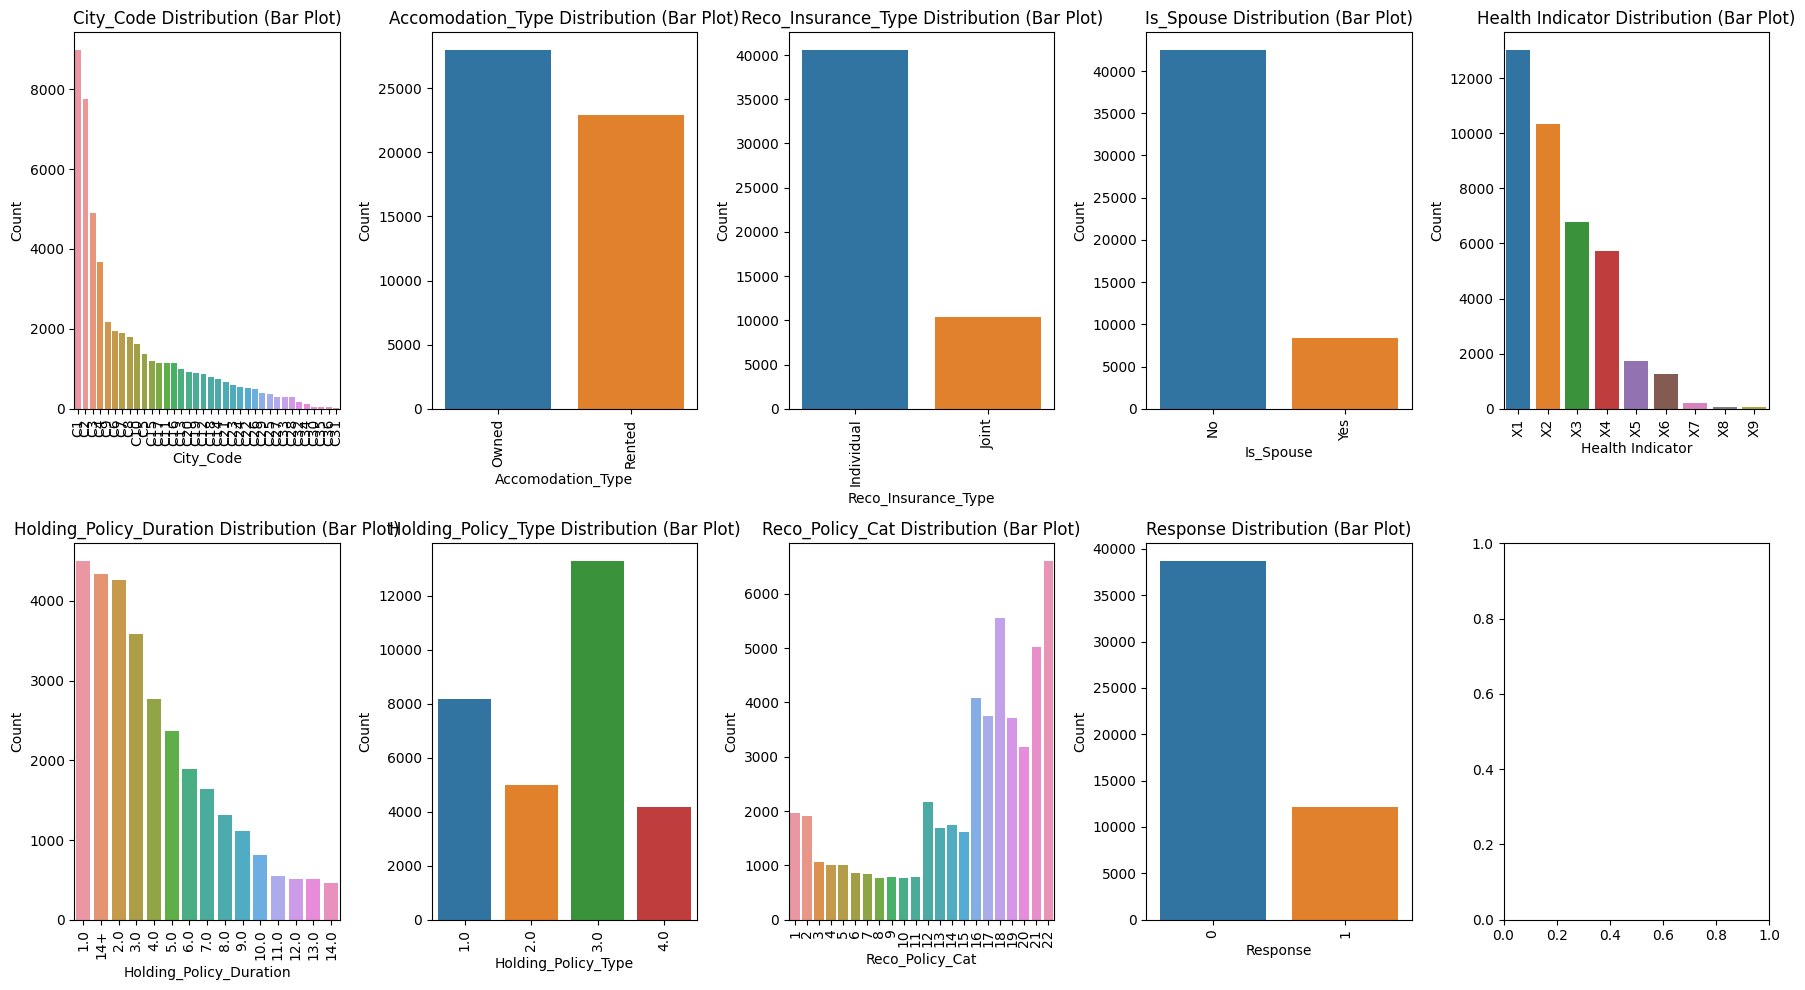

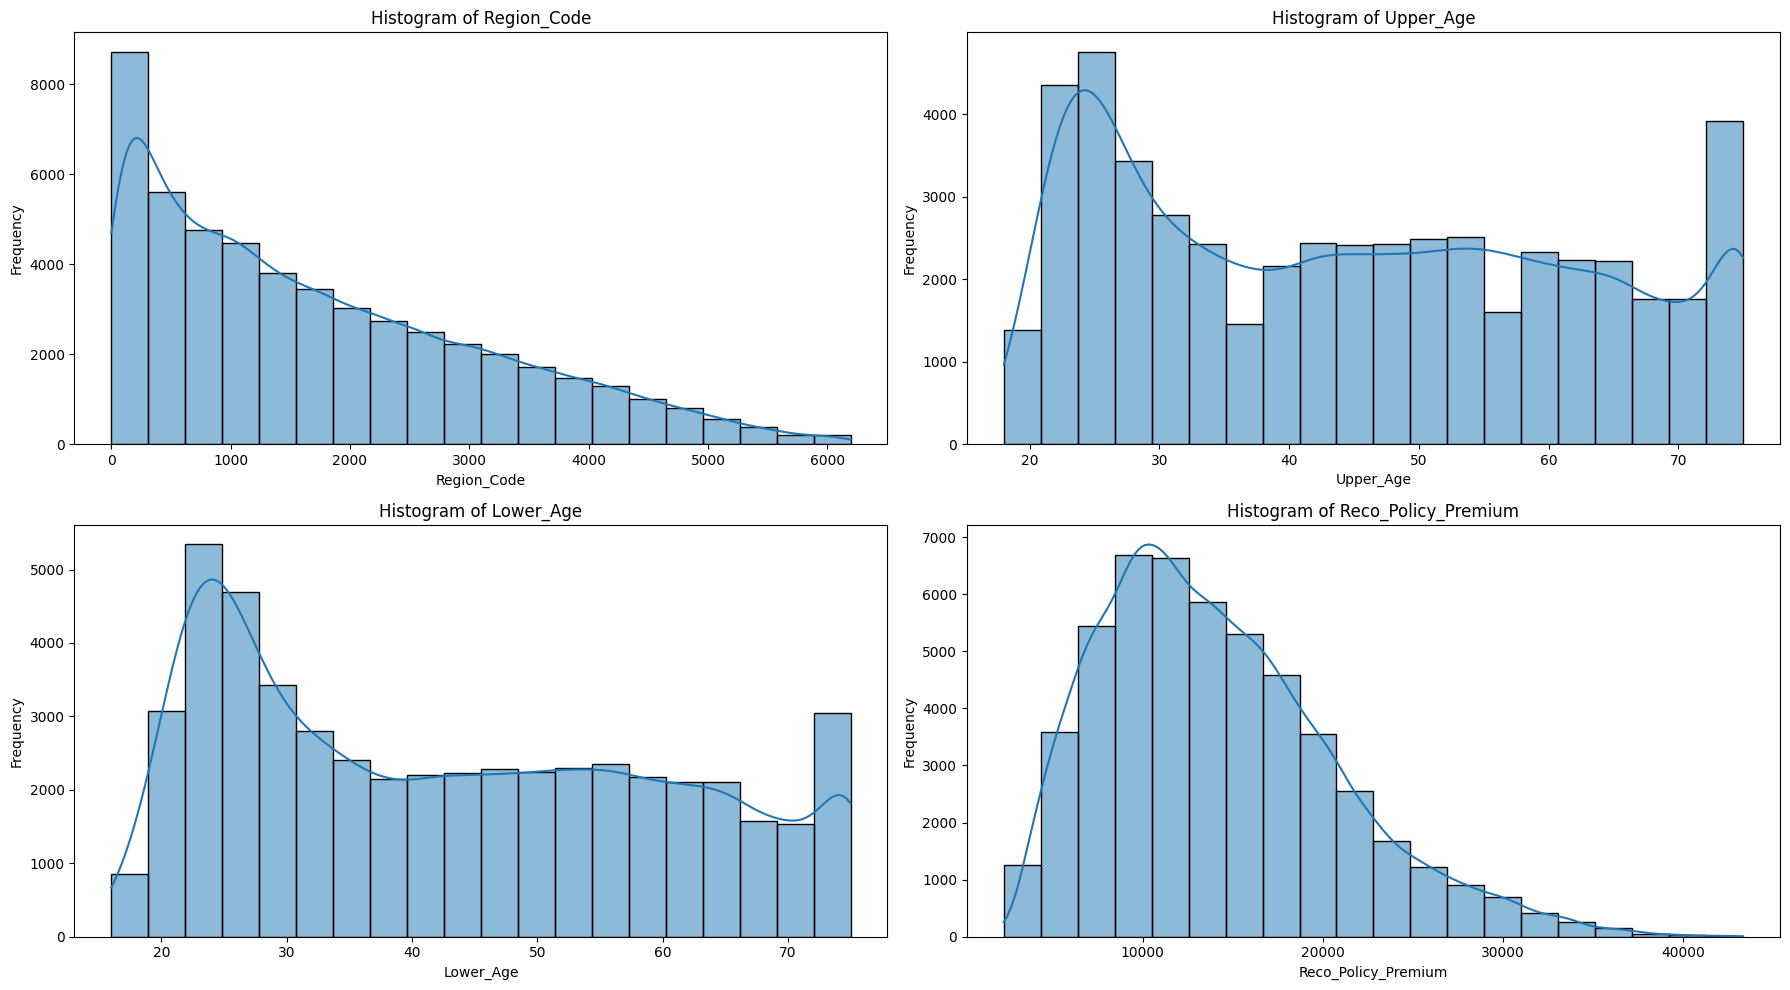

In [14]:
# Function to plot count distribution for categorical variables
def plot_count_distribution(data, column, ax):
    sns.barplot(x=data[column].value_counts().index, y=data[column].value_counts(),ax=ax)
    ax.set_title(f'{column} Distribution (Bar Plot)')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=90)

# Function to plot histogram for numerical variables
def plot_histogram(data, column, ax):
    sns.histplot(data[column], bins=20, kde=True, ax=ax)
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# List of categorical and numerical columns
categorical_columns = ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 
                       'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 
                       'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response']

numerical_columns = ['Region_Code', 'Upper_Age', 'Lower_Age', 'Reco_Policy_Premium']

# Create subplots for categorical variables
num_cat_cols = len(categorical_columns)
fig, axes = plt.subplots(nrows=2, ncols=num_cat_cols//2 + num_cat_cols%2, figsize=(18, 10))

# Plot count distribution for categorical variables
for i, column in enumerate(categorical_columns):
    row = i // (num_cat_cols//2 + num_cat_cols%2)
    col = i % (num_cat_cols//2 + num_cat_cols%2)
    plot_count_distribution(data, column, ax=axes[row, col])

plt.tight_layout()
plt.show()

# Create subplots for numerical variables
num_num_cols = len(numerical_columns)
fig, axes = plt.subplots(nrows=2, ncols=num_num_cols//2 + num_num_cols%2, figsize=(18, 10))

# Plot histogram for numerical variables
for i, column in enumerate(numerical_columns):
    row = i // (num_num_cols//2 + num_num_cols%2)
    col = i % (num_num_cols//2 + num_num_cols%2)
    plot_histogram(data, column, ax=axes[row, col])

plt.tight_layout()
plt.show()


In [15]:
data["City_Code"].value_counts()

City_Code
C1     8973
C2     7747
C3     4889
C4     3671
C9     2185
C6     1950
C7     1910
C8     1806
C10    1611
C5     1364
C15    1186
C17    1159
C11    1147
C16    1135
C13    1005
C20     926
C19     899
C12     868
C18     797
C14     746
C21     679
C23     587
C24     553
C22     516
C26     499
C29     387
C25     366
C27     295
C33     286
C28     285
C32     160
C34     130
C30      58
C35      56
C36      36
C31      15
Name: count, dtype: int64

**Observations:**

-Categorical Variables:

1)City_Code: The distribution of customers varies across different city codes, with some cities(C1,C2,C3,C4) having higher counts than others.
   
2)Accomodation_Type: Majority of the customers own their accommodation rather than renting.
    
3)Reco_Insurance_Type: Most customers have individual insurance rather than joint insurance.
    
4)Is_Spouse: The majority of customers are not spouses.
    
5)Health Indicator: The distribution of health indicators shows that most customers have health indicator X1 followed by X2,X3 etc.
     
6)Holding_Policy_Duration: There is a wide range of holding policy durations, with some durations being more common than others.
      
7)Holding_Policy_Type: Holding policy type 3 is the most common among customers.
    
8)Reco_Policy_Cat: Distribution of recommended policy categories varies, with some categories being more common than others.
    
9)Response: The distribution of responses indicates that the dataset is imbalanced, with a higher number of negative responses (0) compared to positive responses (1).
    
-Numerical Variables:

10)Region_Code: The distribution of region codes shows variability in the regions where customers are located.
    
11)Upper_Age and Lower_Age: The age distributions suggest that the majority of customers fall within a certain age (20-75) range.
    
12)Reco_Policy_Premium: There is variability in the premium amounts for recommended policies, with some customers paying higher premiums than others.

## Bivariate Analysis

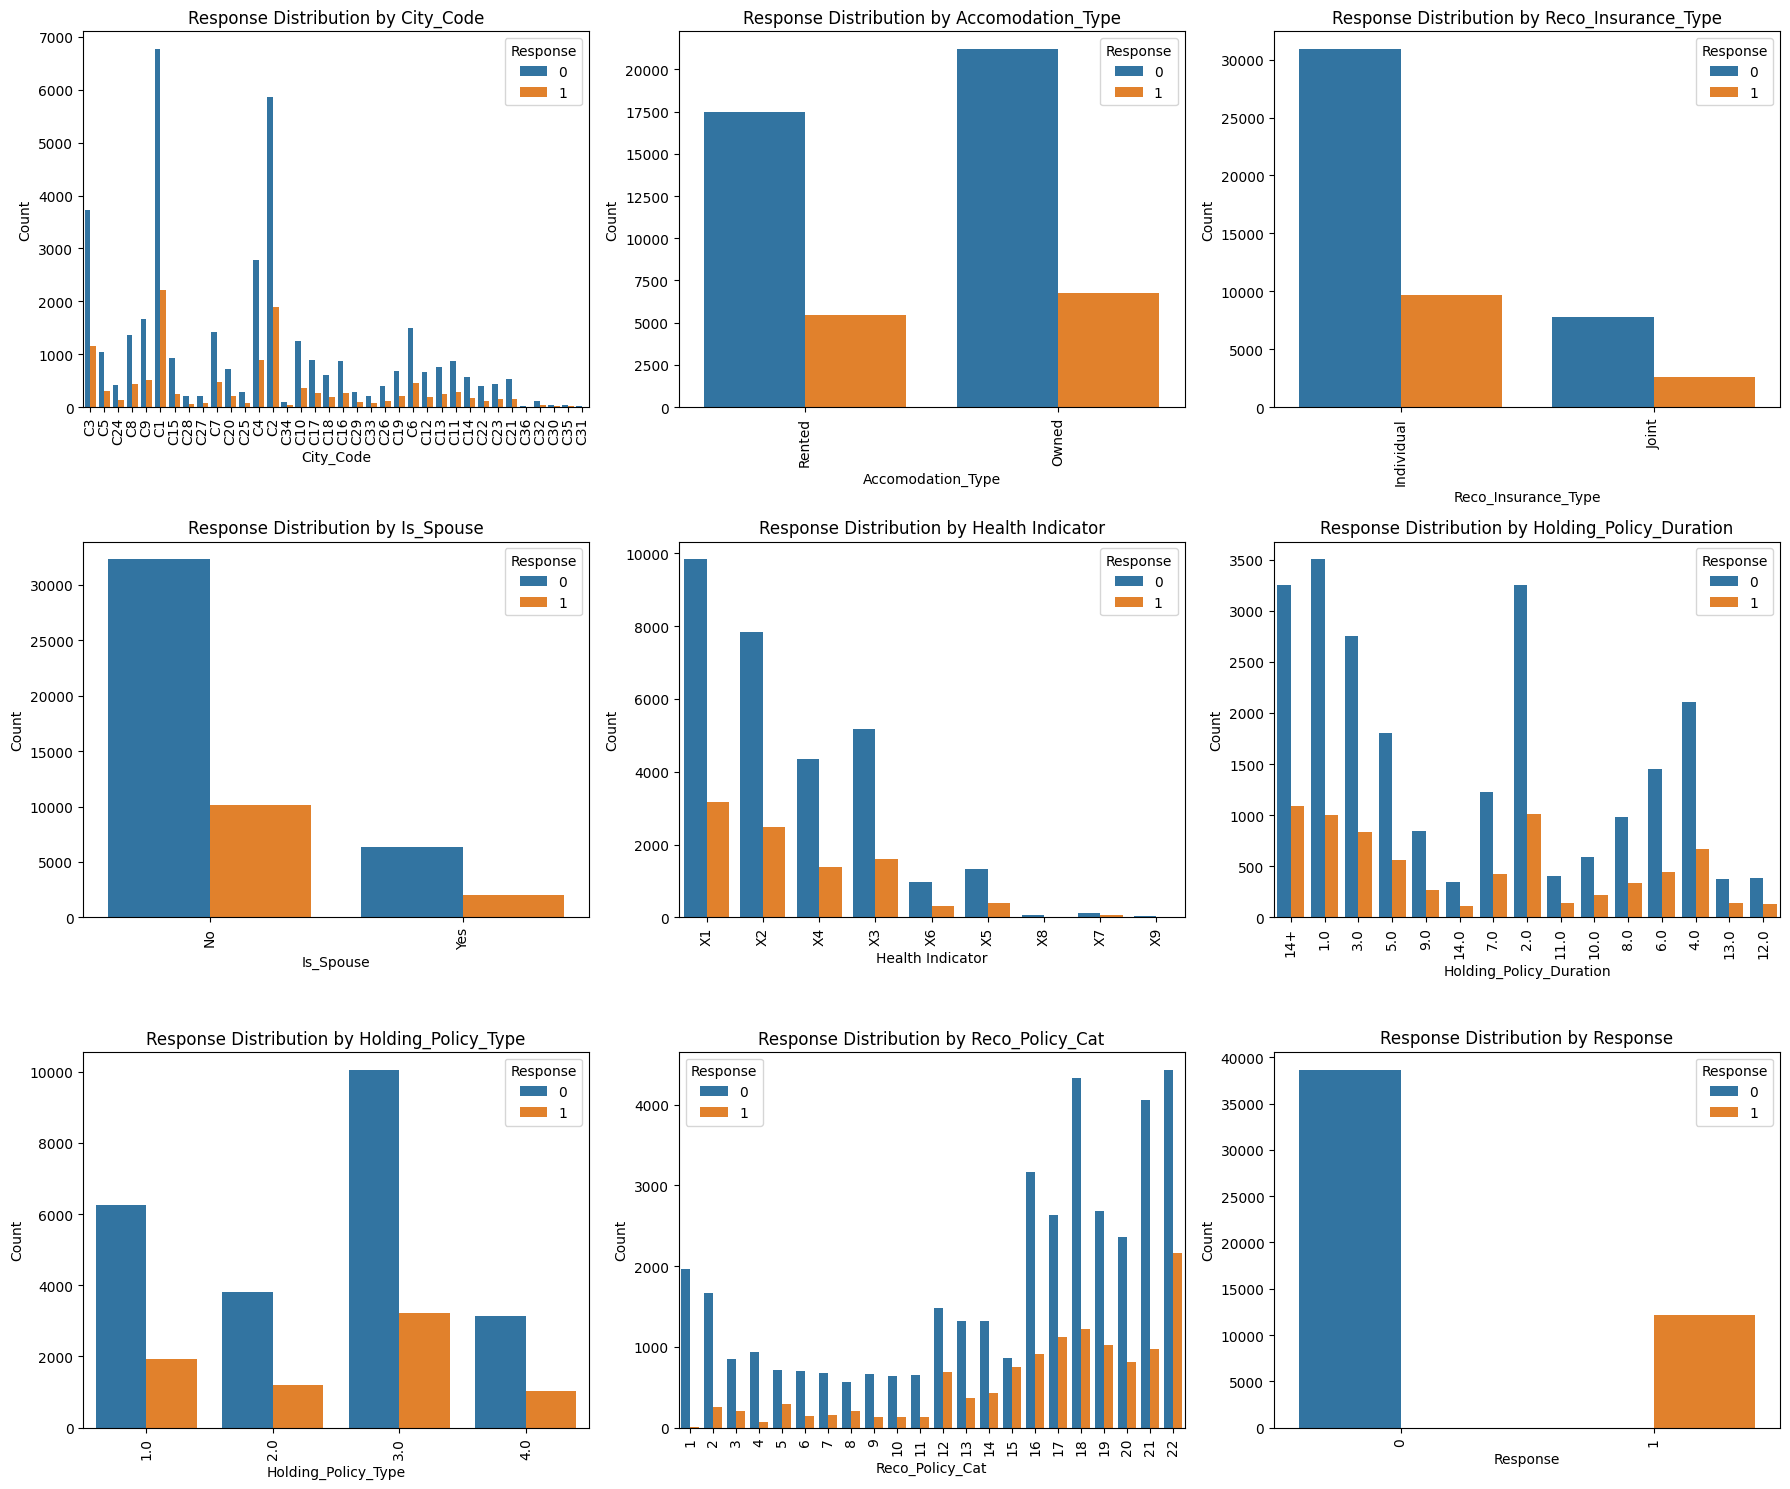

In [16]:
# Bivariate Analysis for Categorical Variables

# Function to plot count distribution of Response variable based on a categorical variable
def plot_response_distribution(data, column, ax):
    sns.countplot(x=column, hue='Response', data=data, ax=ax)
    ax.set_title(f'Response Distribution by {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=90)

# Create subplots for categorical variables
fig, axes = plt.subplots(nrows=3, ncols=num_cat_cols//3 + num_cat_cols%3, figsize=(18, 15))

# Plot Response distribution by each categorical variable
for i, column in enumerate(categorical_columns):
    row = i // (num_cat_cols//3 + num_cat_cols%3)
    col = i % (num_cat_cols//3 + num_cat_cols%3)
    plot_response_distribution(data, column, ax=axes[row, col])

plt.tight_layout()
plt.show()


**Observations:**

City_Code vs. Response: Certain city codes may have higher response with zero(C3,C1,C2) compared to others. This could indicate regional variations in customer behavior or preferences.

Accommodation_Type vs. Response: Customers with different accommodation types (e.g., Owned vs. Rented) may exhibit varying response rates. This could reflect differences in financial stability or risk perception. Accomodation_Type of Owned have high response where insurance is not taken.

Reco_Insurance_Type vs. Response: Individuals recommended for different insurance types (e.g., Individual vs. Joint) may respond differently to the recommendations, possibly influenced by factors like family size or financial planning.Most of the individuals have not preferred any insurances.

Is_Spouse vs. Response: The response to insurance recommendations might differ based on whether the individual is a spouse or not. This could relate to family-oriented decision-making or financial considerations. Those who don't have spouse has not preferred to take insurance.

Health Indicator vs. Response: Health indicators may play a role in determining the response to insurance recommendations, with individuals in better health potentially being more receptive to certain policies.

Holding_Policy_Duration vs. Response: The duration of holding policies may influence the response to new insurance recommendations, indicating whether individuals with longer-held policies are more or less likely to switch.

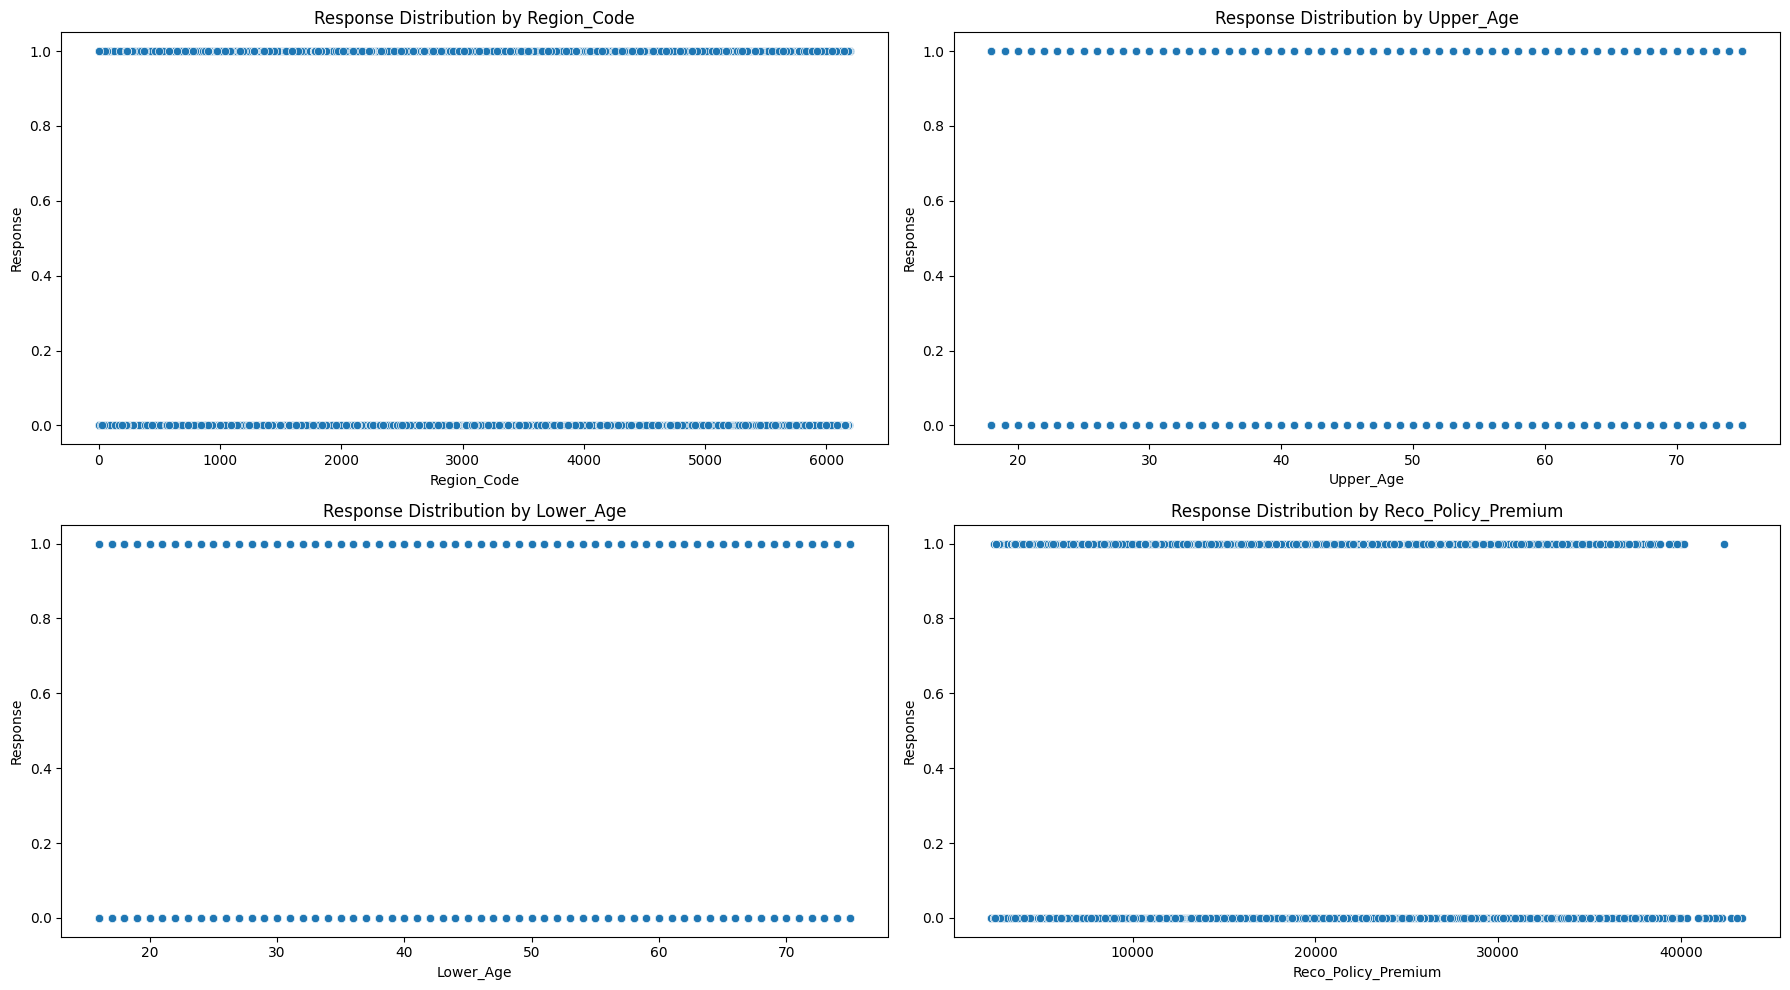

In [17]:
# Bivariate Analysis for Numerical variables

# Function to plot scatter plot of Response variable based on a numerical variable
def plot_response_scatter(data, column, ax):
    sns.scatterplot(x=column, y='Response', data=data, ax=ax)
    ax.set_title(f'Response Distribution by {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Response')

# Create subplots for numerical variables
fig, axes = plt.subplots(nrows=2, ncols=num_num_cols//2 + num_num_cols%2, figsize=(18, 10))

# Plot Response distribution by each numerical variable
for i, column in enumerate(numerical_columns):
    row = i // (num_num_cols//2 + num_num_cols%2)
    col = i % (num_num_cols//2 + num_num_cols%2)
    plot_response_scatter(data, column, ax=axes[row, col])

plt.tight_layout()
plt.show()

**Observations:**

Region_Code vs. Response: There may be variations in response rates across different region codes, suggesting geographical factors influencing customer decisions.

Upper_Age vs. Response: Response rates may vary with the age of the individual, with older or younger individuals showing different levels of interest in insurance recommendations.

Lower_Age vs. Response: Similar to upper age, lower age could also affect response rates, potentially indicating preferences or financial situations of younger individuals.

Reco_Policy_Premium vs. Response: The premium amount of recommended policies may impact response rates, with individuals more likely to respond to policies with certain price ranges.

**Summary**

Response rates vary across different categorical and numerical variables, indicating the influence of various factors on customer decisions regarding insurance recommendations.

Certain variables, such as city code, accommodation type, and health indicator, show notable differences in response rates, suggesting the importance of these factors in predicting customer behavior.

Further analysis and modeling should consider these insights to develop effective strategies for targeting customers and optimizing insurance recommendations.


## Multivariate Analysis

**Observation:**

Accommodation Type and Reco Insurance Type: There is a positive correlation between certain types of accommodation and certain types of recommended insurance. This suggests that individuals with a particular type of accommodation may be more likely to opt for a specific type of insurance.

Is Spouse and Reco Insurance Type: There is a positive correlation between whether an individual is a spouse and the type of recommended insurance. This could indicate that individuals who are spouses are more likely to opt for certain types of insurance compared to non-spouses.

Holding Policy Type and Response: There seems to be a weak positive correlation between the type of holding policy and the response variable. However, the correlation is not very strong, indicating that holding policy type alone may not be a strong predictor of the response variable.

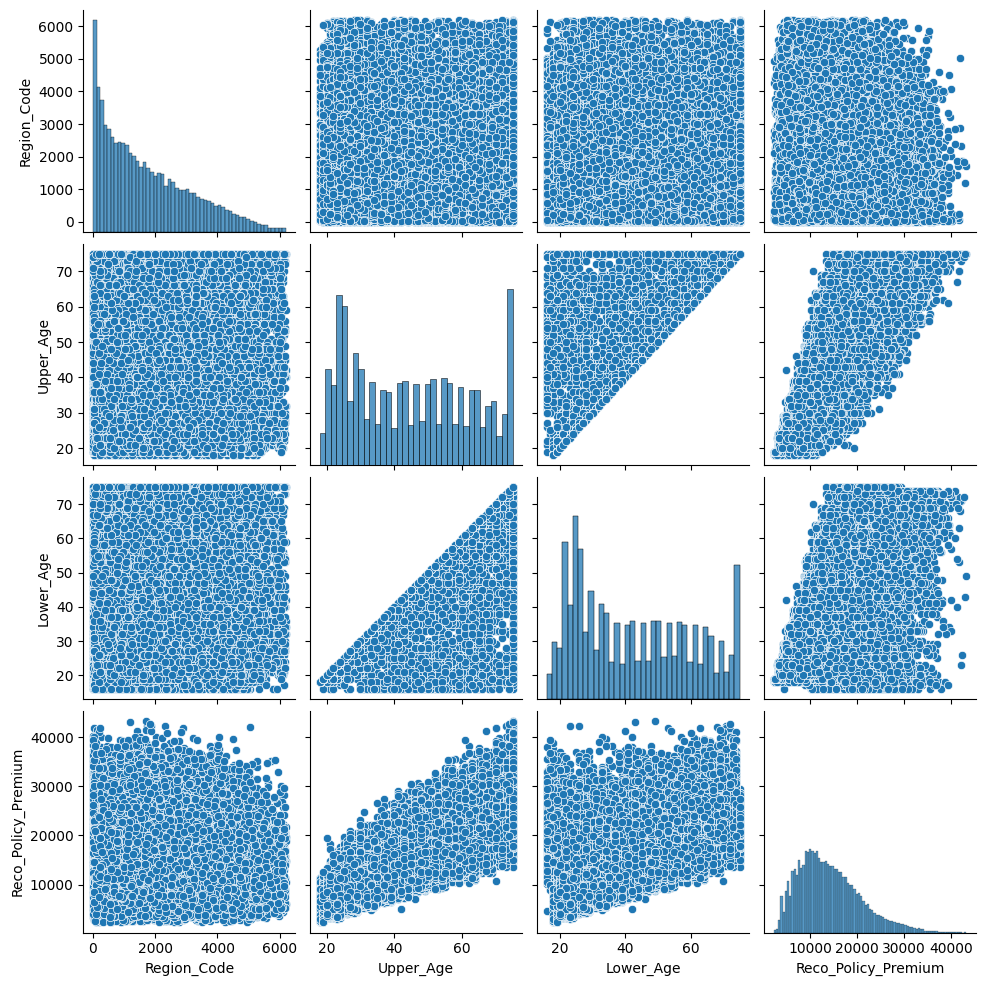

In [18]:
# Define numerical columns for analysis
numerical_columns = ['Region_Code', 'Upper_Age', 'Lower_Age', 'Reco_Policy_Premium']

# Plot pair plot to visualize relationships between numerical variables
sns.pairplot(data[numerical_columns])
plt.show()


**Observations:**

Region Code vs. Reco Policy Premium: There doesn't seem to be a clear linear relationship between region code and recommended policy premium. The scatter plot appears to show random distribution of points, indicating no significant correlation between these variables.

Upper Age vs. Lower Age: The scatter plot between upper age and lower age shows a strong positive linear relationship, which is expected since these two variables represent the same individual's age. The points form a straight line with a slope of 1, indicating a perfect positive correlation.

Upper Age vs. Reco Policy Premium: There appears to be a slight positive correlation between upper age and recommended policy premium. As the upper age increases, the recommended policy premium also tends to increase, although the relationship is not very strong.

Lower Age vs. Reco Policy Premium: Similar to upper age, there is a slight positive correlation between lower age and recommended policy premium. As the lower age increases, the recommended policy premium also tends to increase, although the relationship is not very strong.
    
    
Overall, the pair plot provides insights into the relationships between numerical variables in the dataset. While some variables exhibit clear correlations, others show more complex patterns or no significant relationships.

## Numerical Vs Categorical

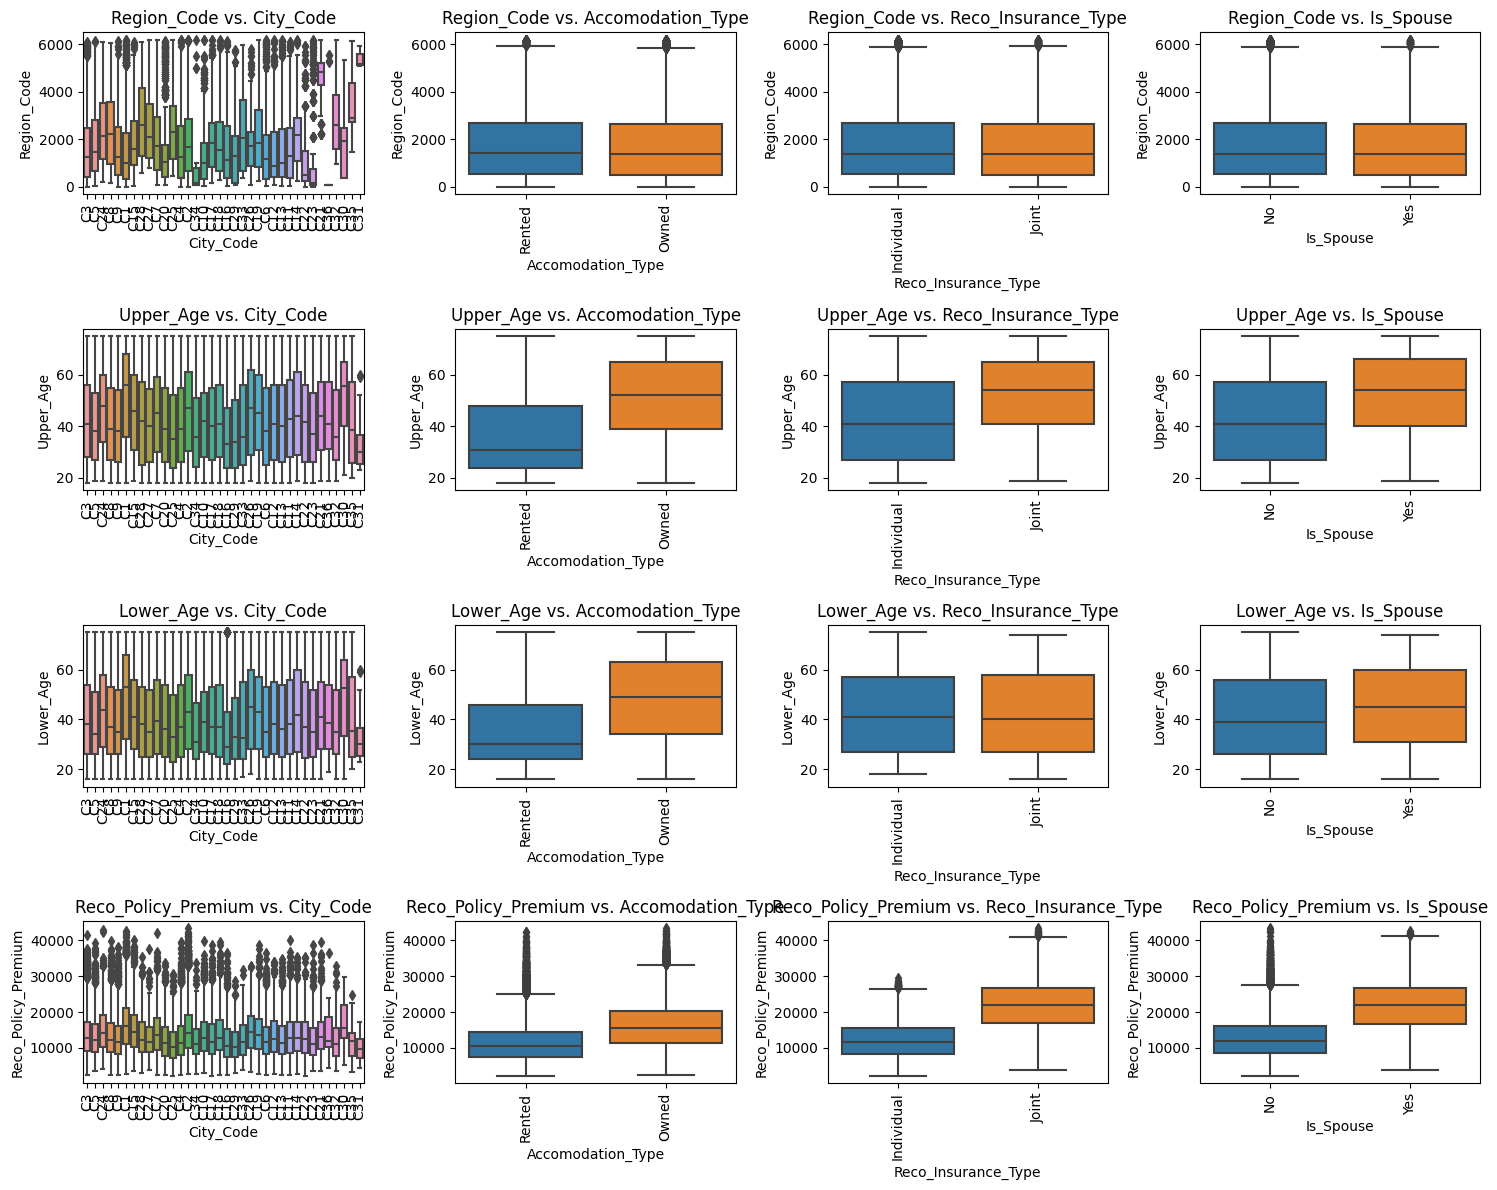

In [19]:
# Define the numerical and categorical columns for analysis
numerical_columns = ['Region_Code', 'Upper_Age', 'Lower_Age', 'Reco_Policy_Premium']
categorical_columns = ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse']

# Calculate the number of rows and columns needed for subplots
num_rows = len(numerical_columns)
num_cols = len(categorical_columns)

# Set up the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# Plot boxplots for numerical vs. categorical variables
for i, num_col in enumerate(numerical_columns):
    for j, cat_col in enumerate(categorical_columns):
        sns.boxplot(x=cat_col, y=num_col, data=data, ax=axes[i, j])
        axes[i, j].set_title(f'{num_col} vs. {cat_col}')
        axes[i, j].set_xlabel(cat_col)
        axes[i, j].set_ylabel(num_col)
        axes[i, j].tick_params(axis='x', rotation=90)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()



**Observations:**

Boxplots for each numerical variable (e.g., Region_Code, Upper_Age, etc.) are plotted against each categorical variable (e.g., City_Code, Accommodation_Type, etc.).

These boxplots help visualize the distribution of numerical variables within different categories of the categorical variables.

Inferences can be drawn based on the comparison of median values, interquartile ranges, and presence of outliers across different categories of the categorical variables.

## Categorical Vs Categorical

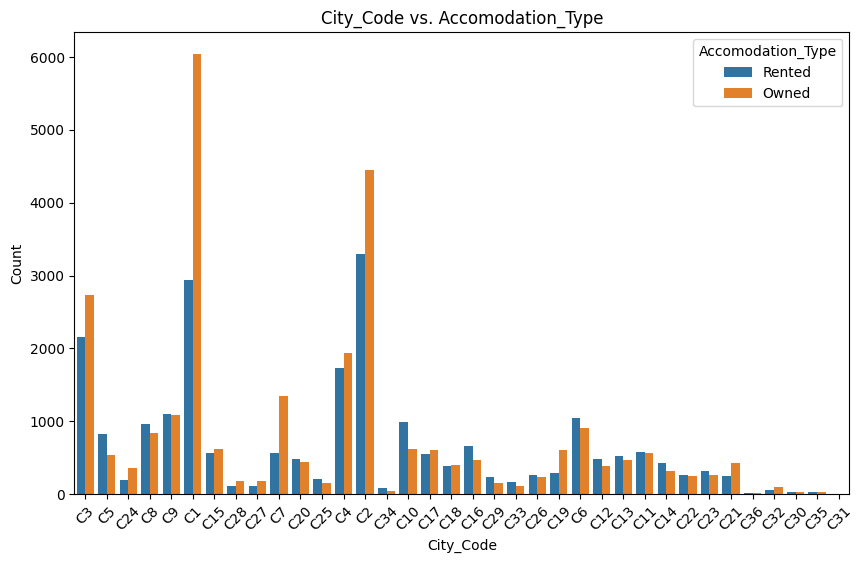

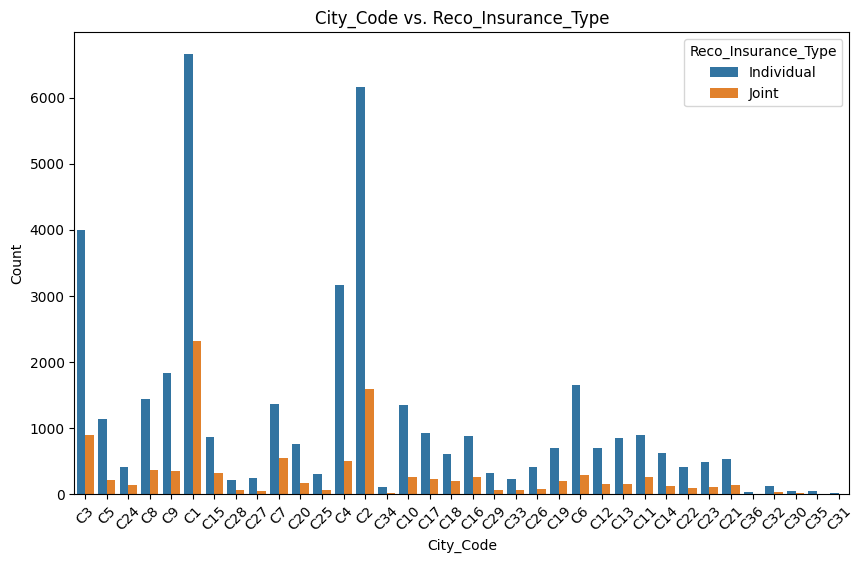

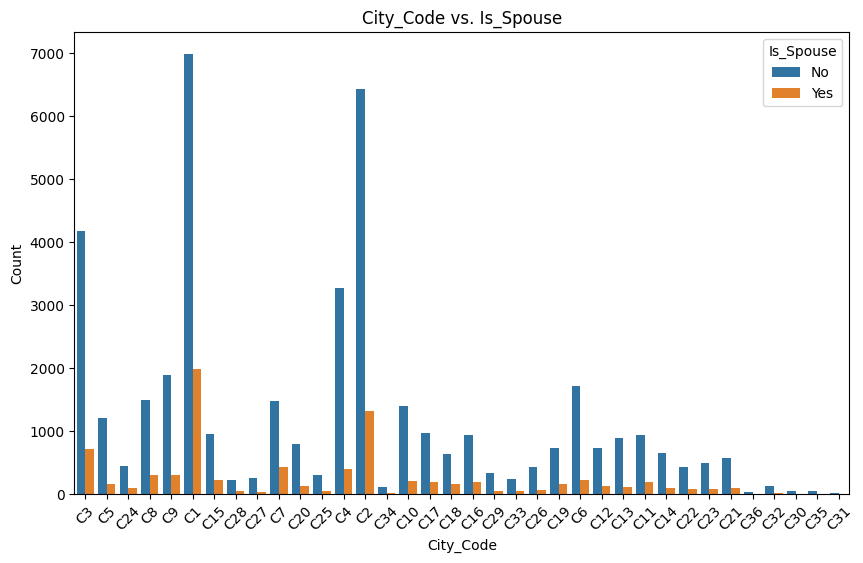

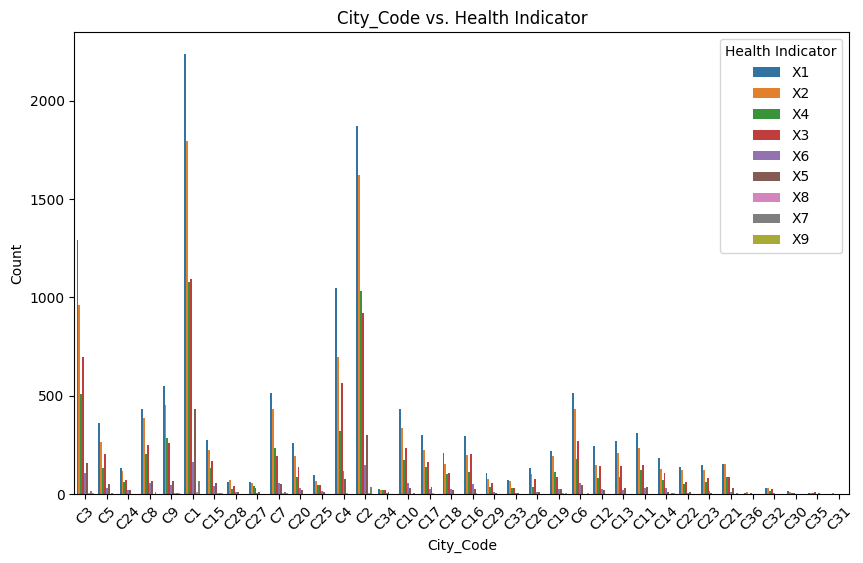

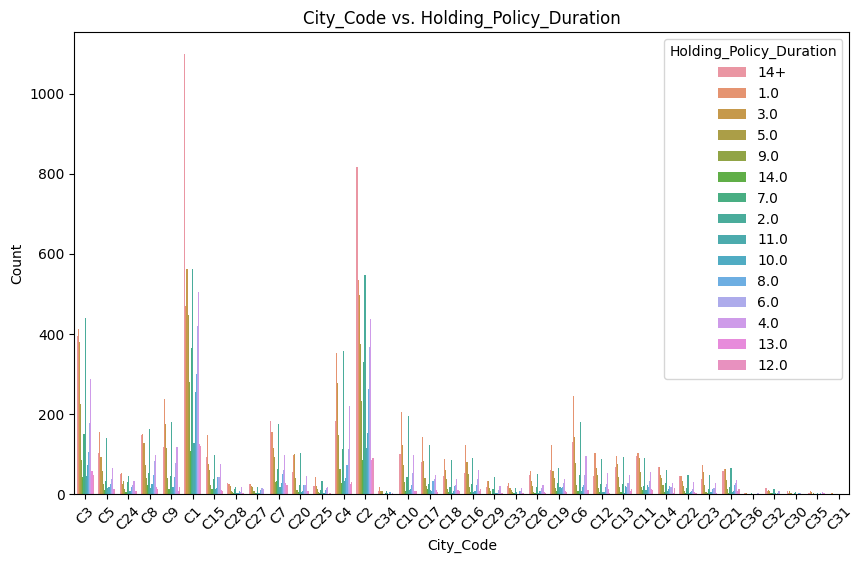

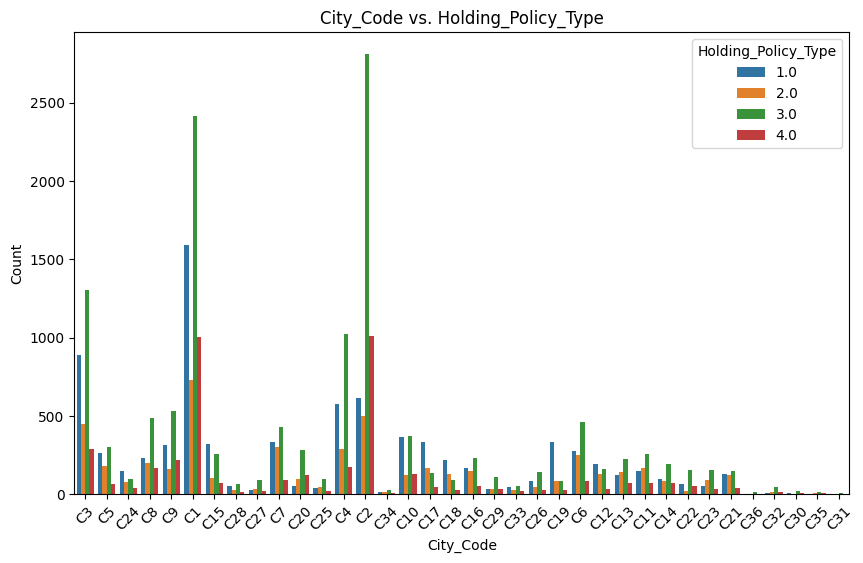

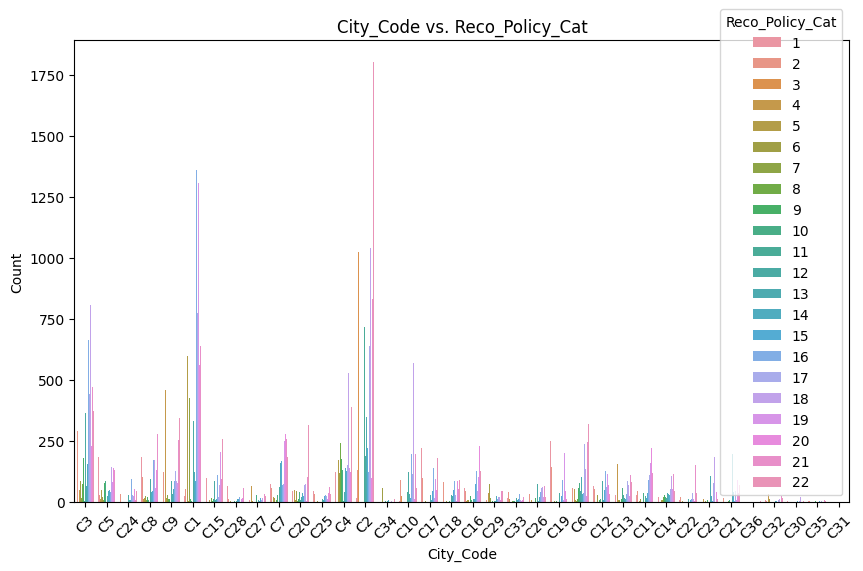

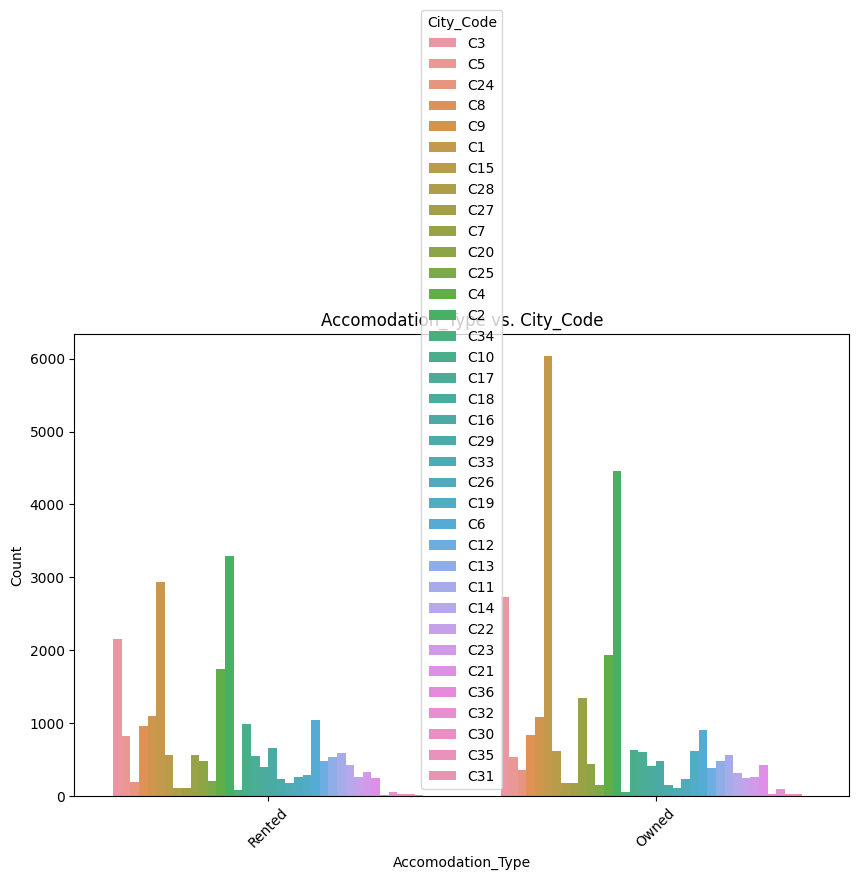

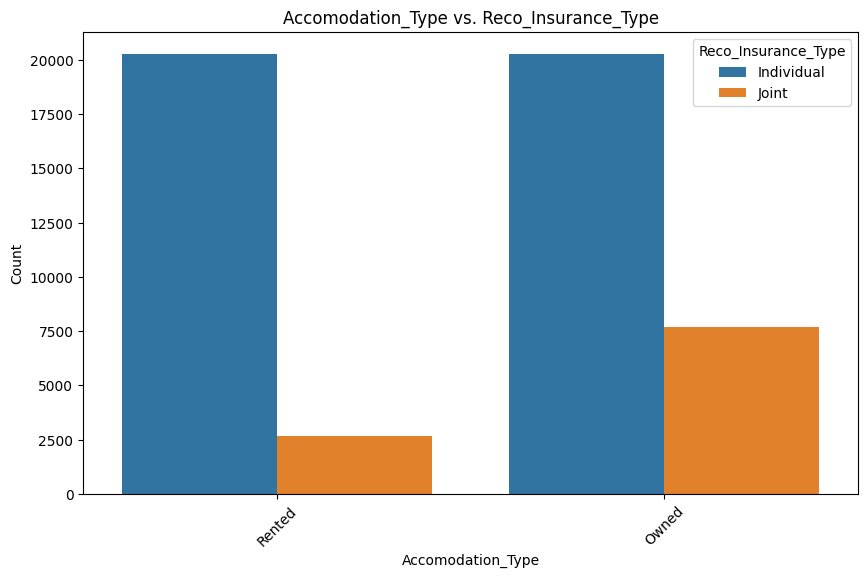

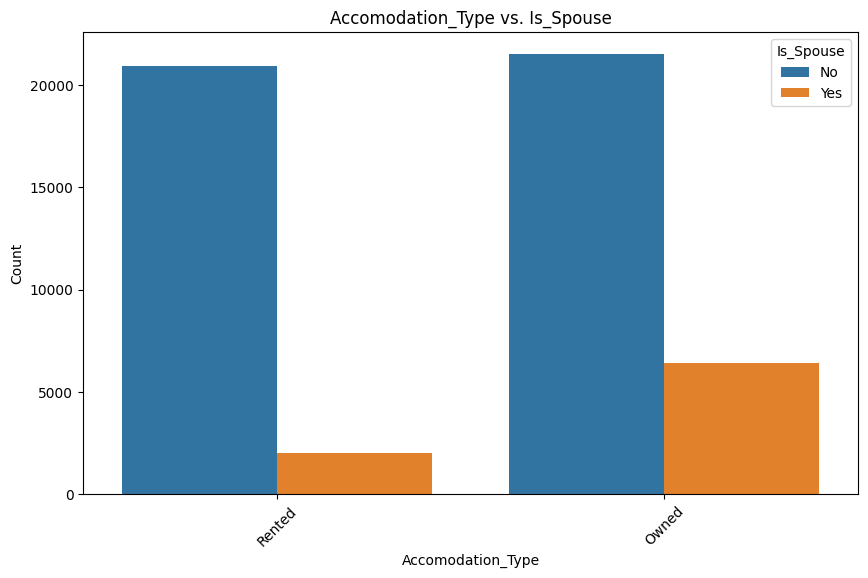

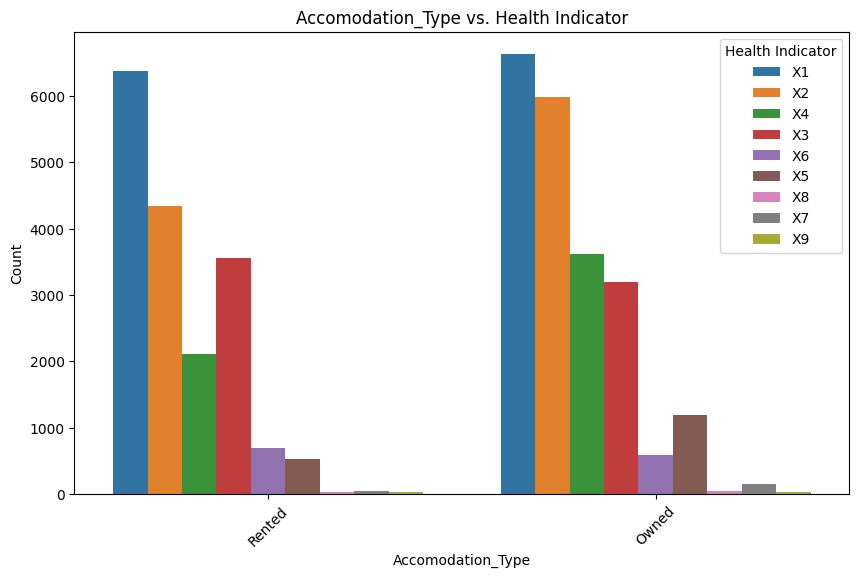

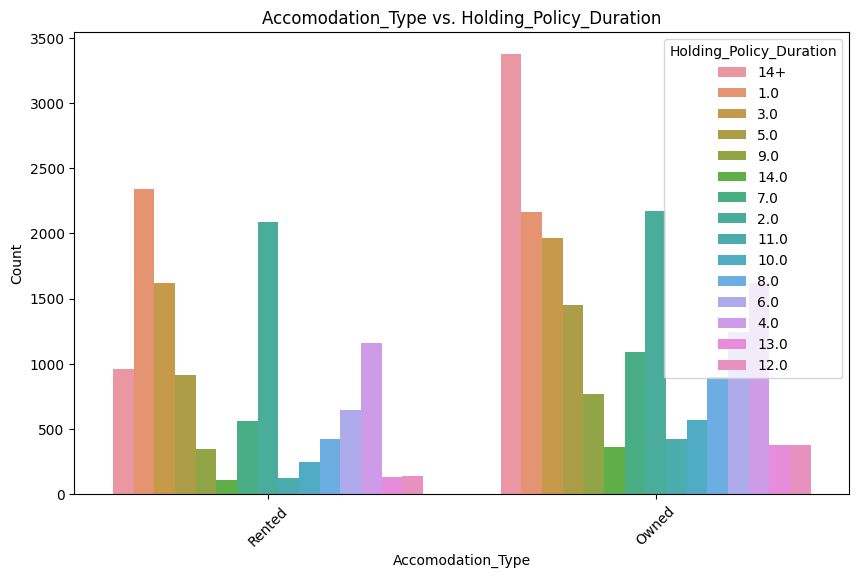

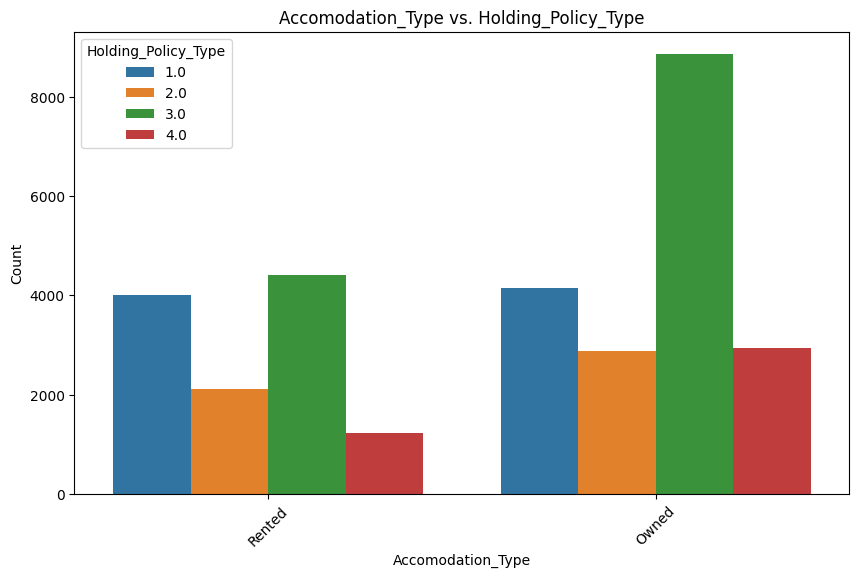

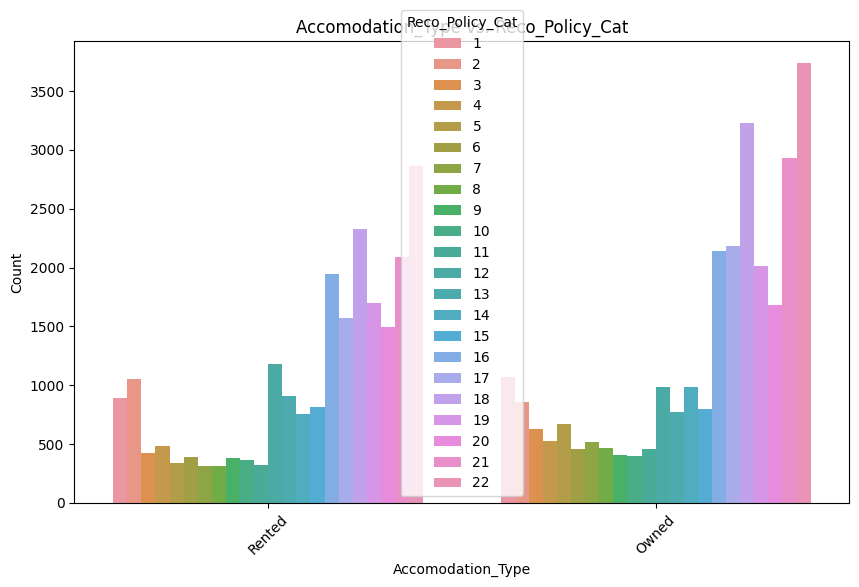

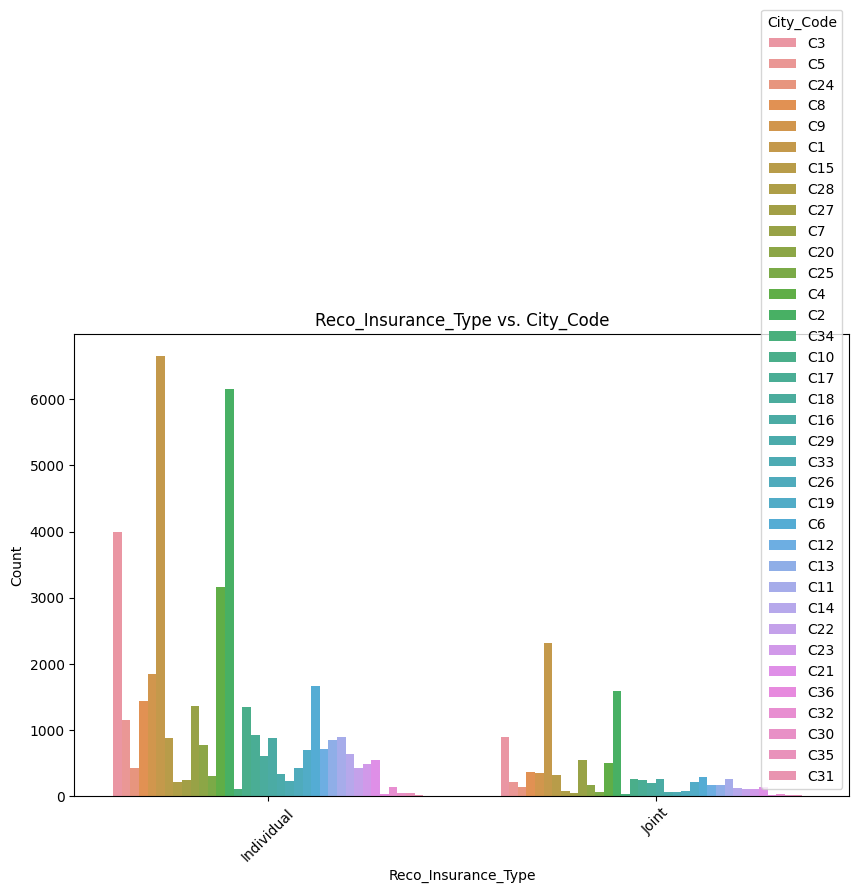

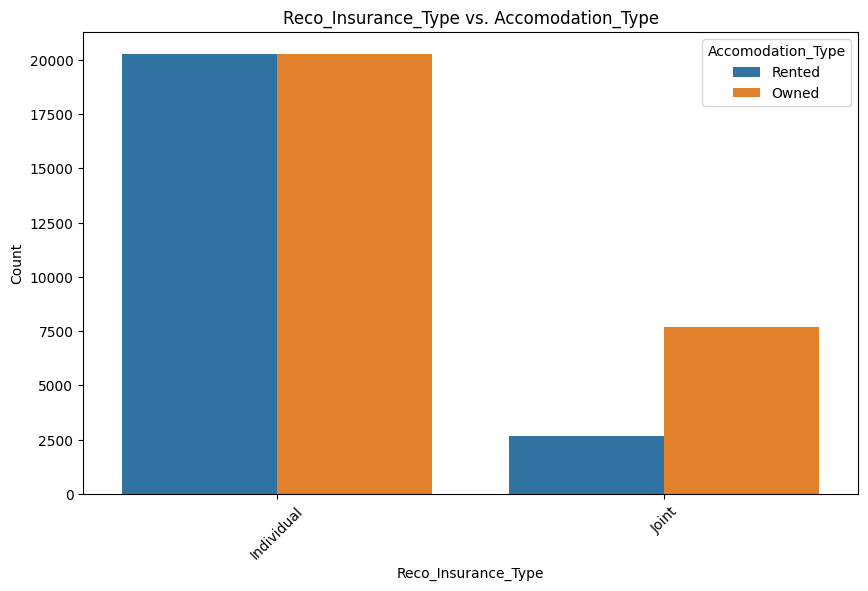

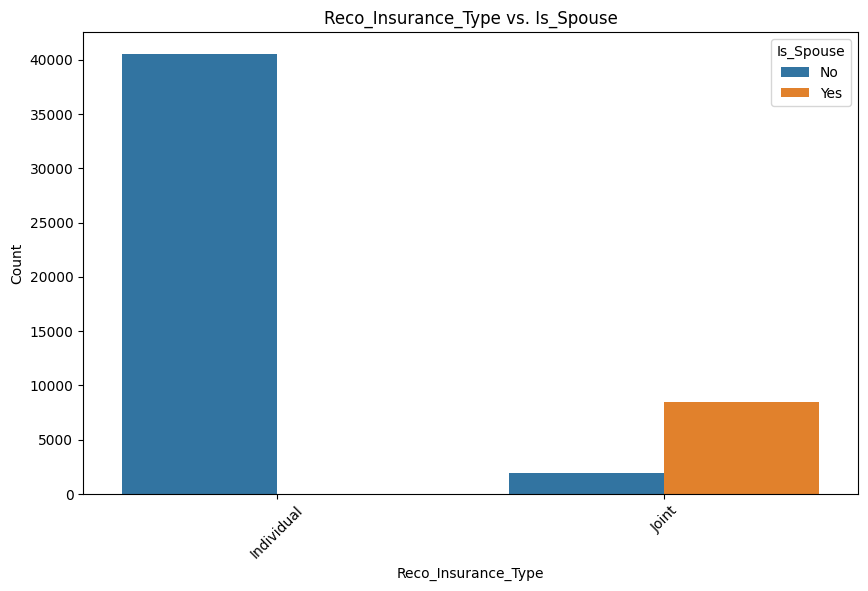

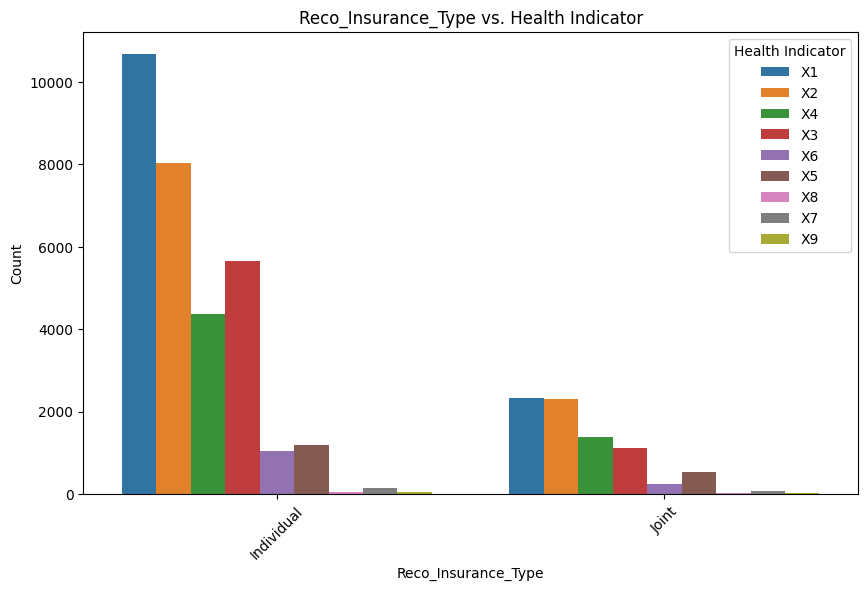

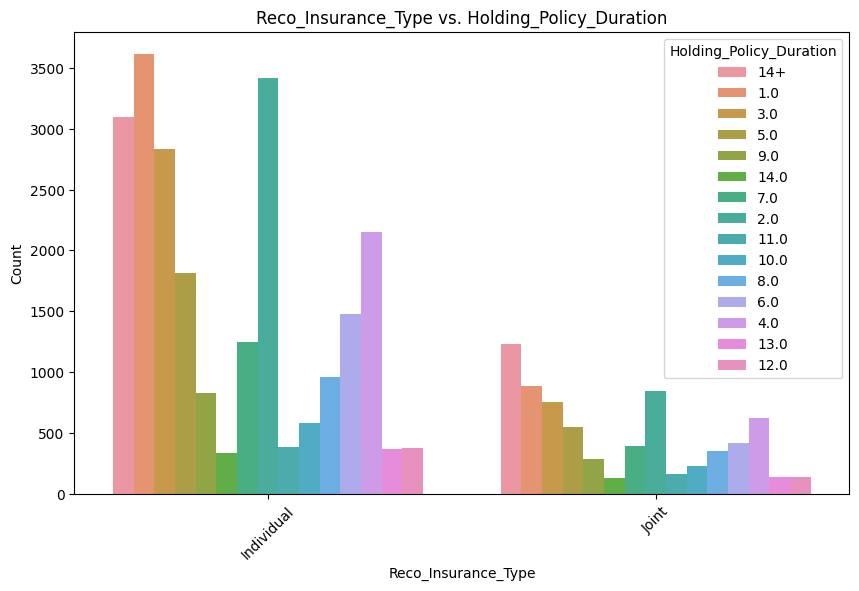

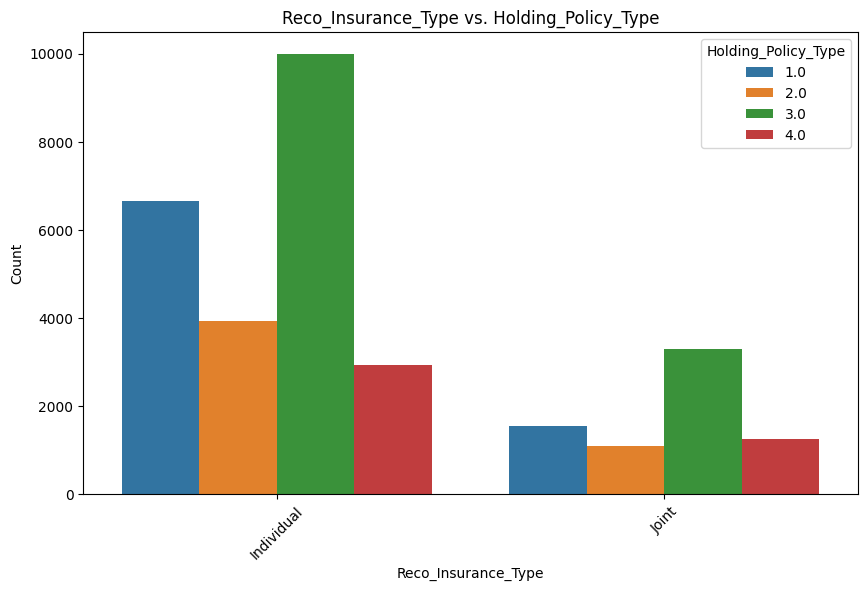

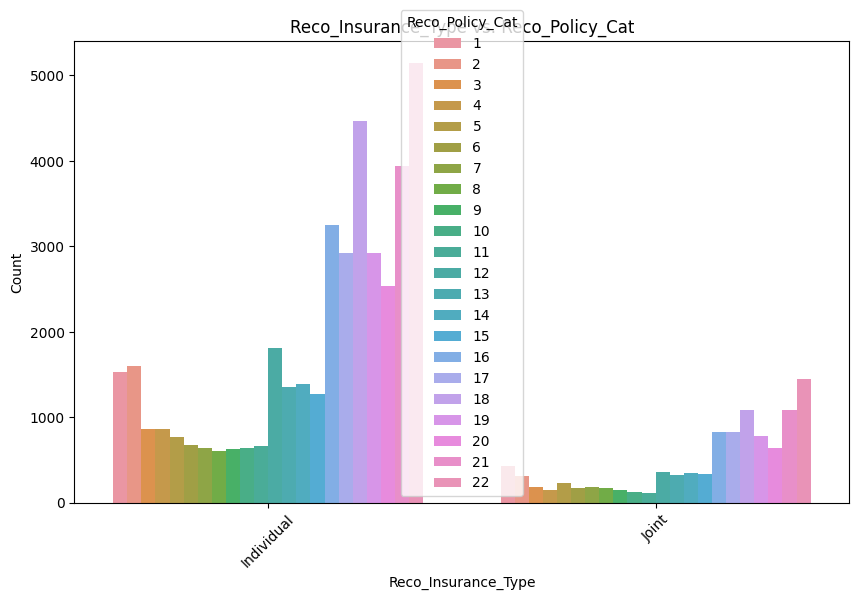

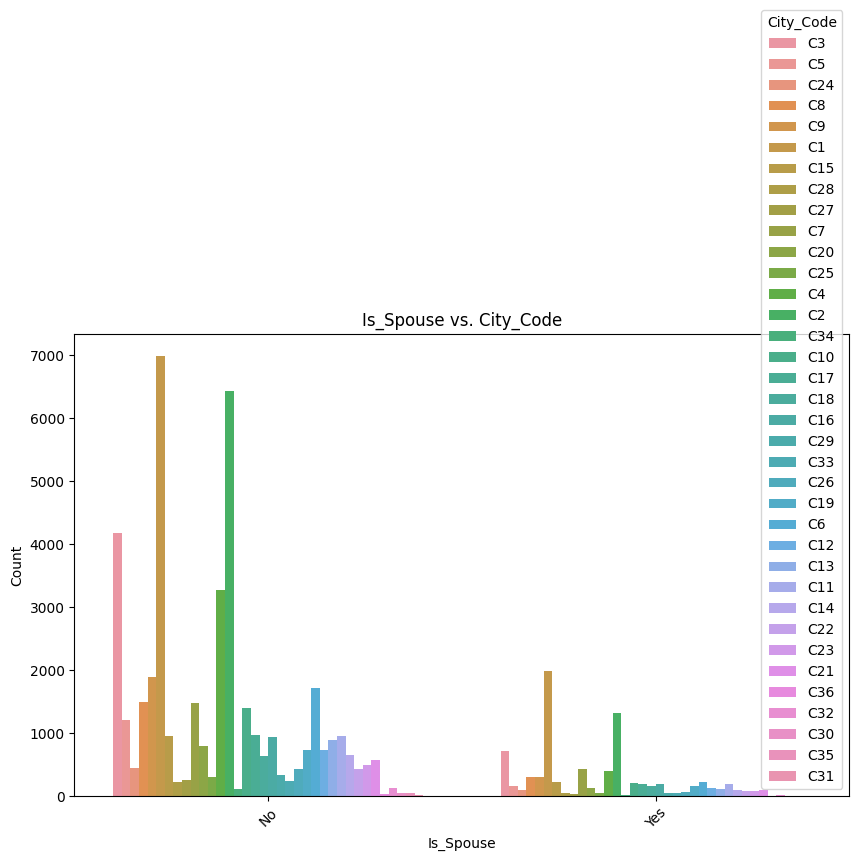

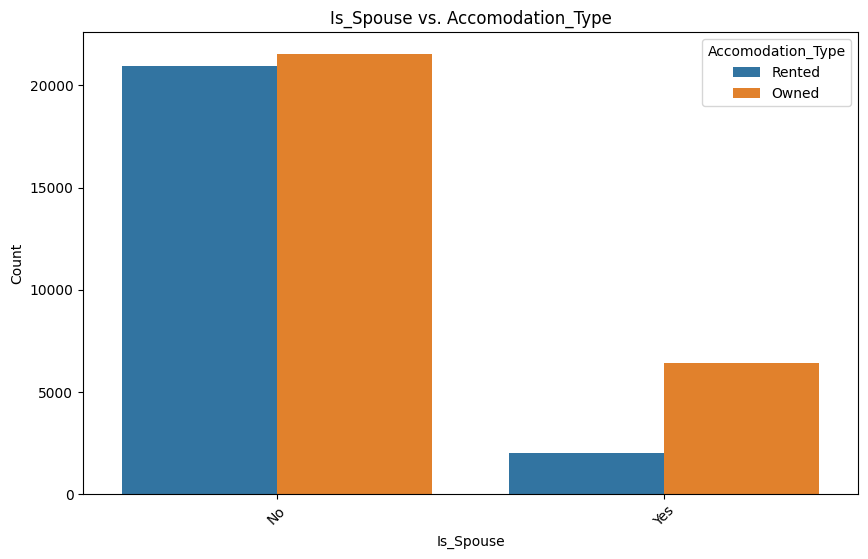

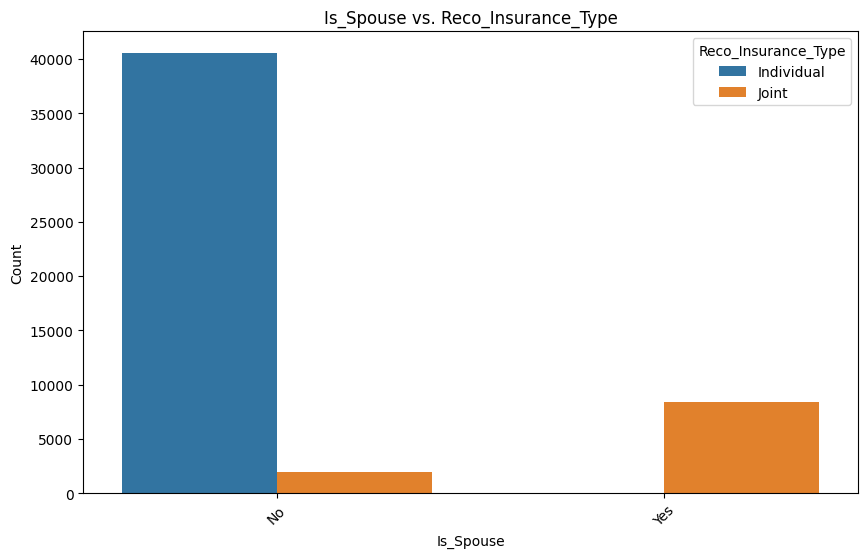

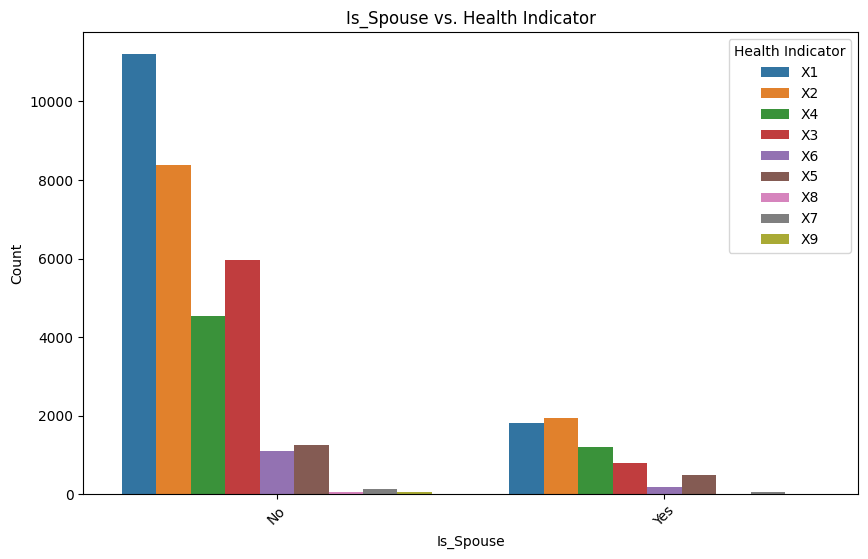

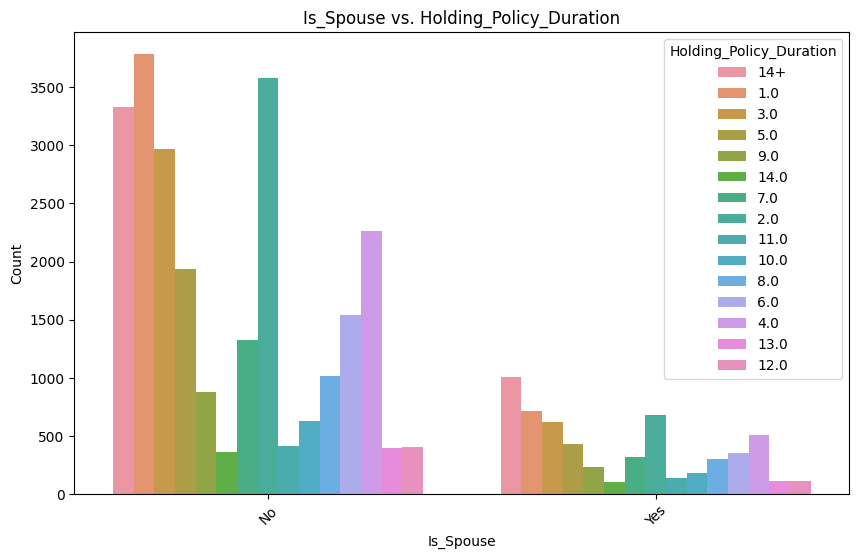

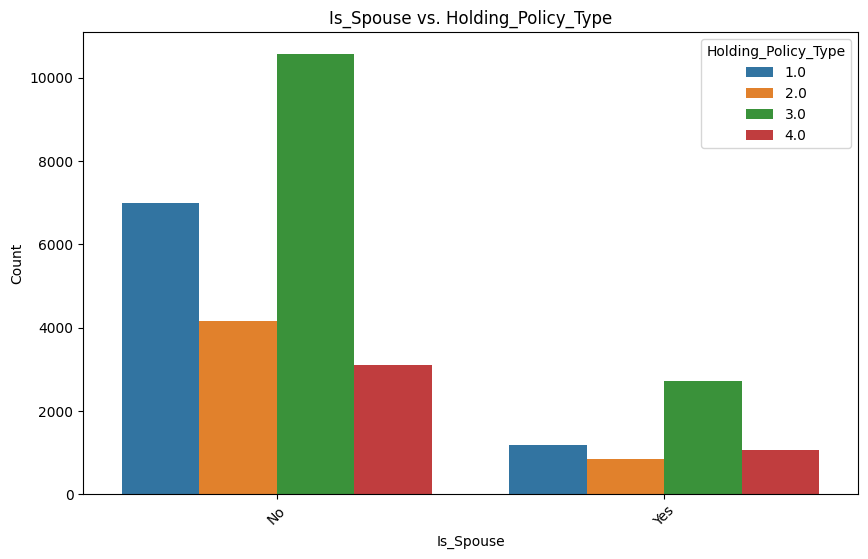

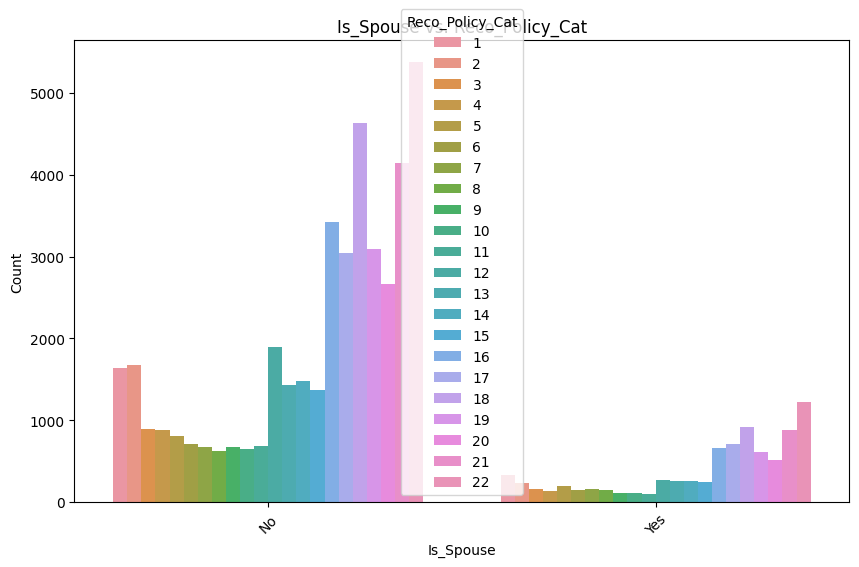

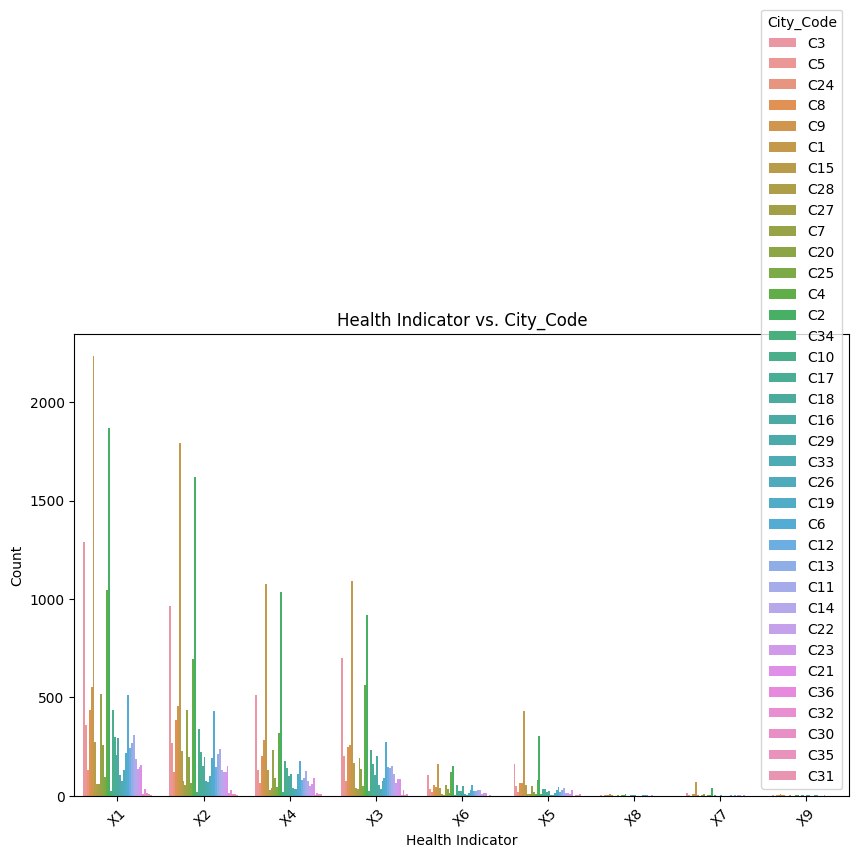

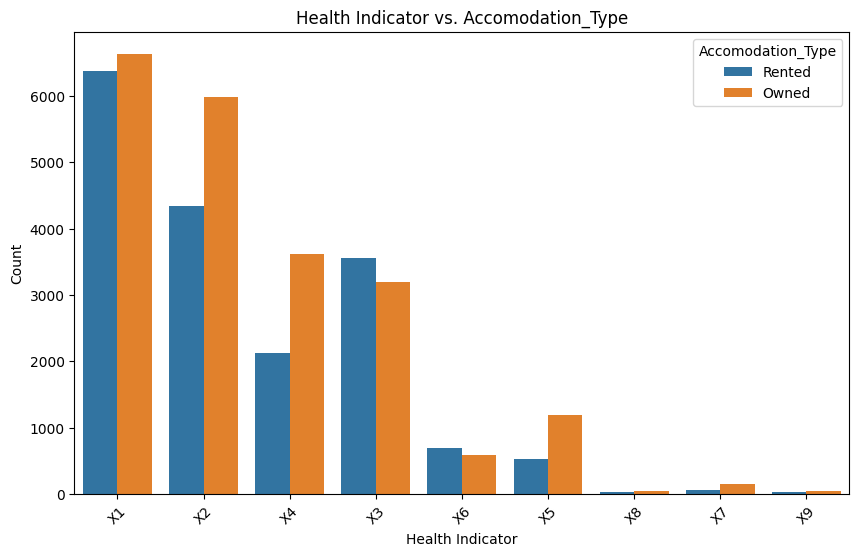

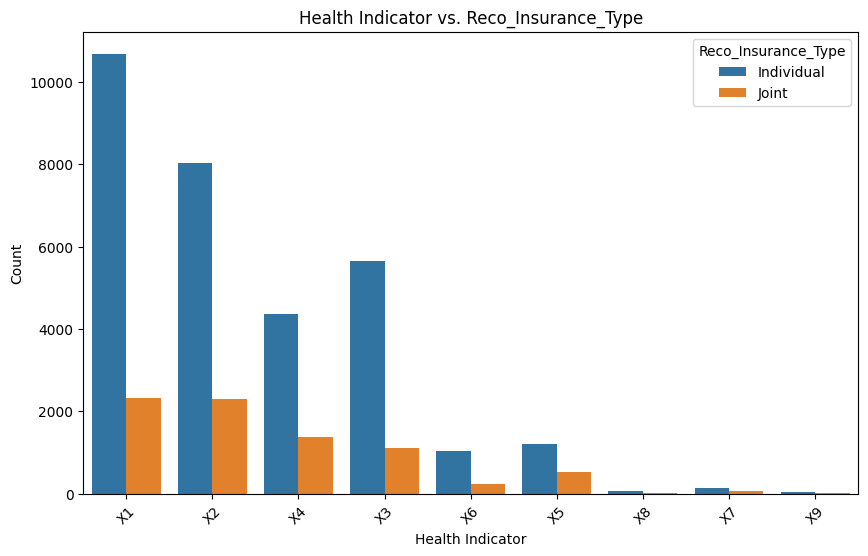

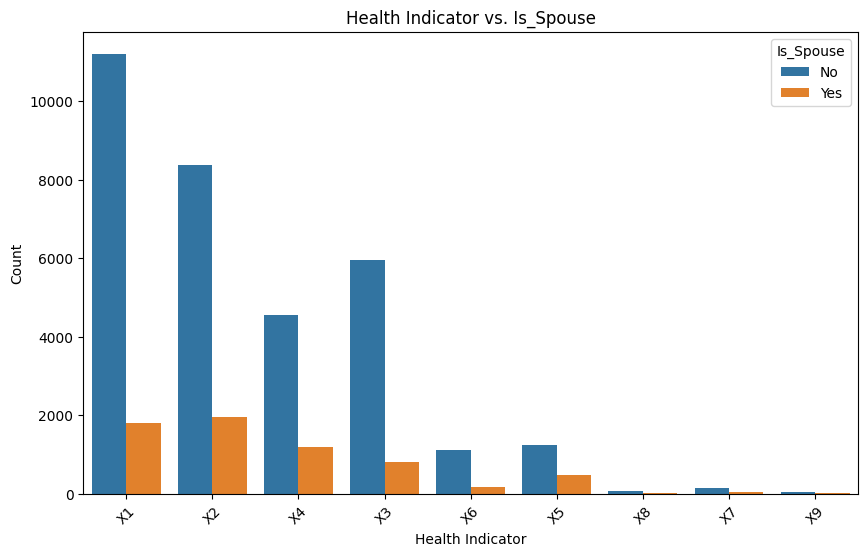

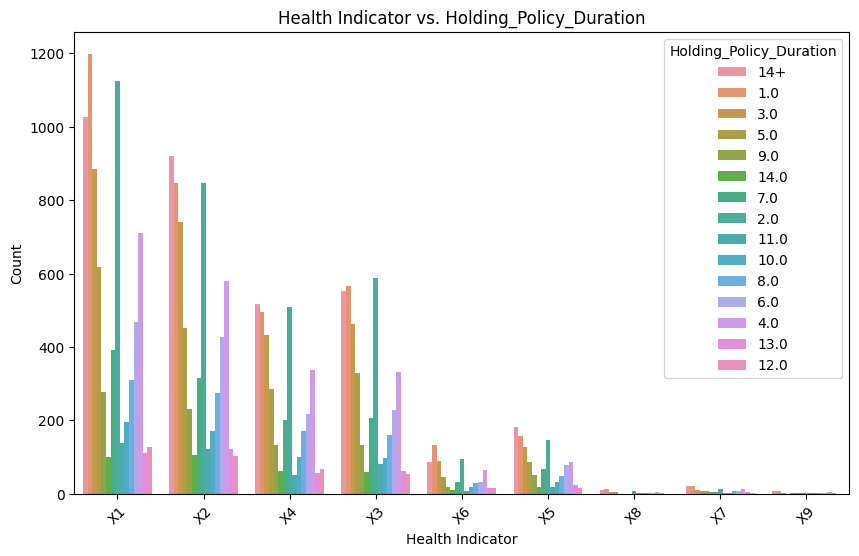

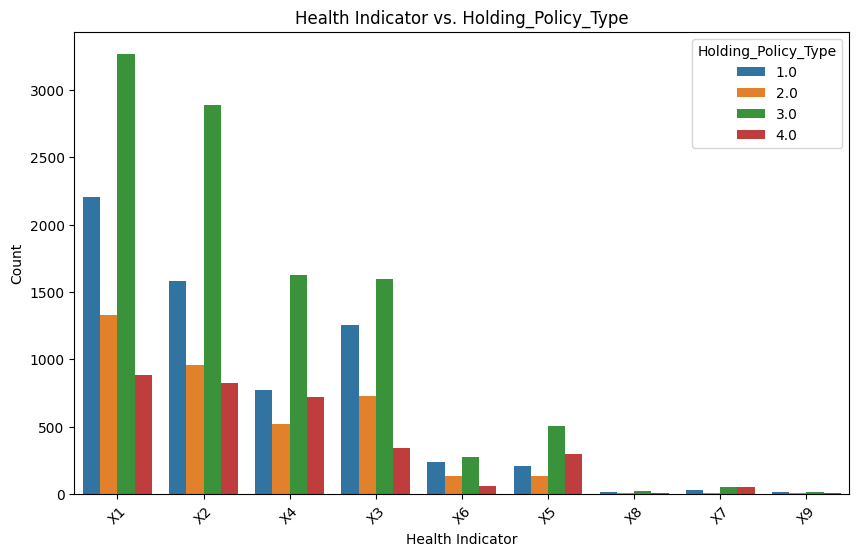

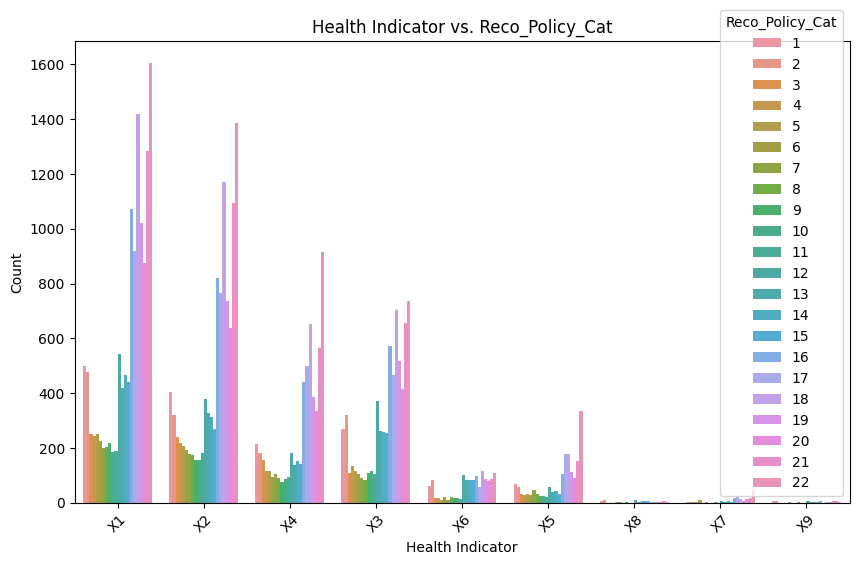

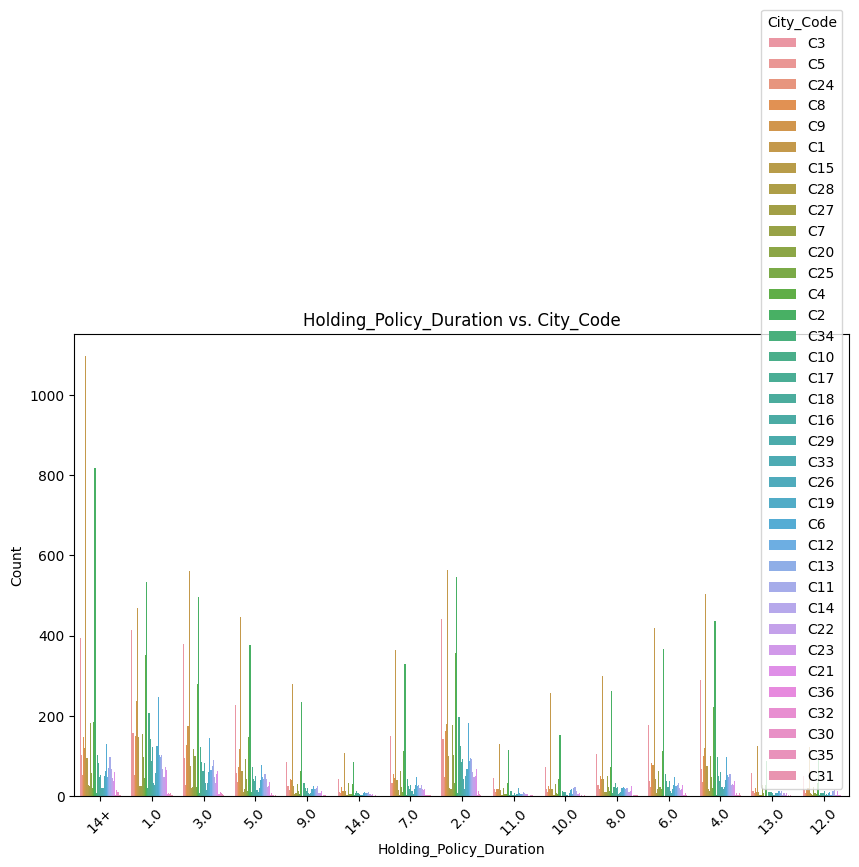

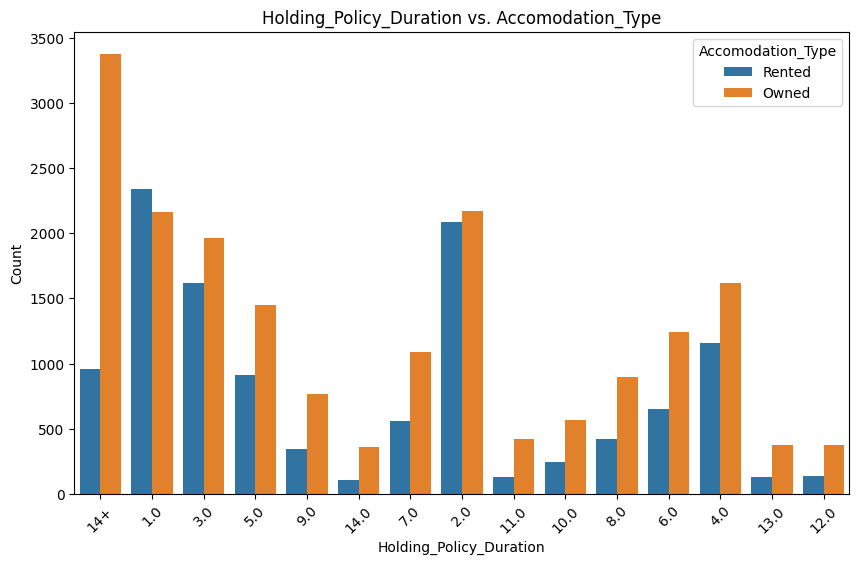

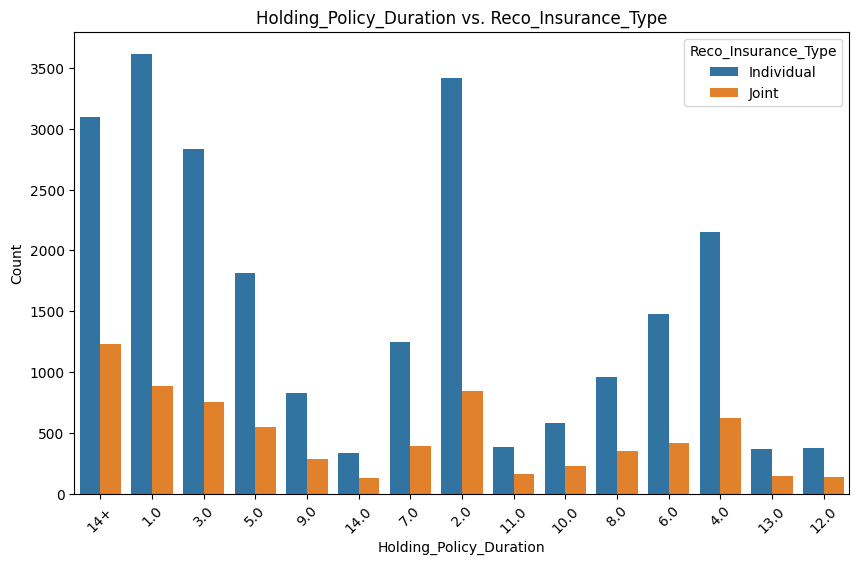

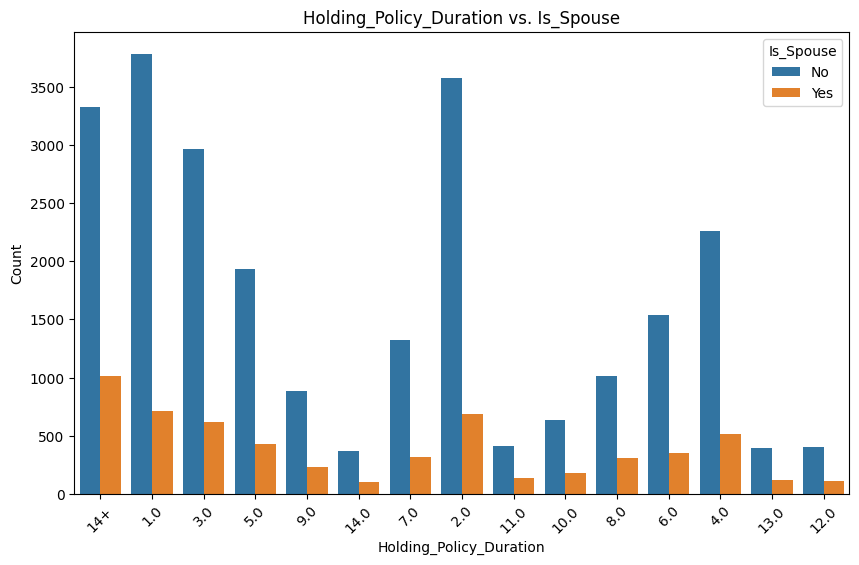

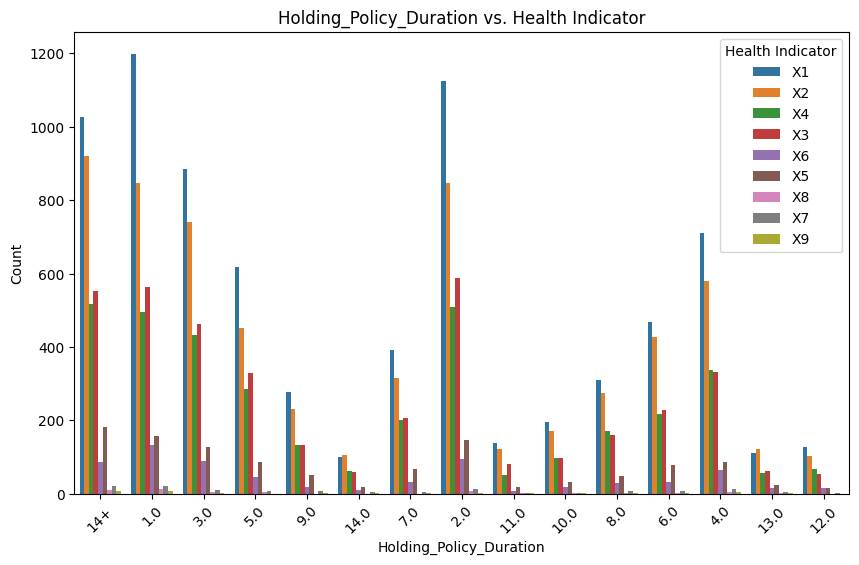

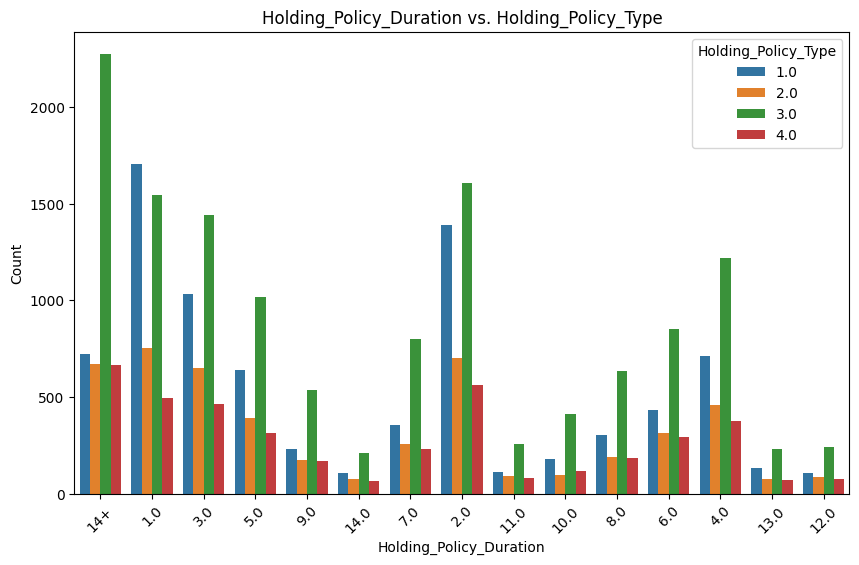

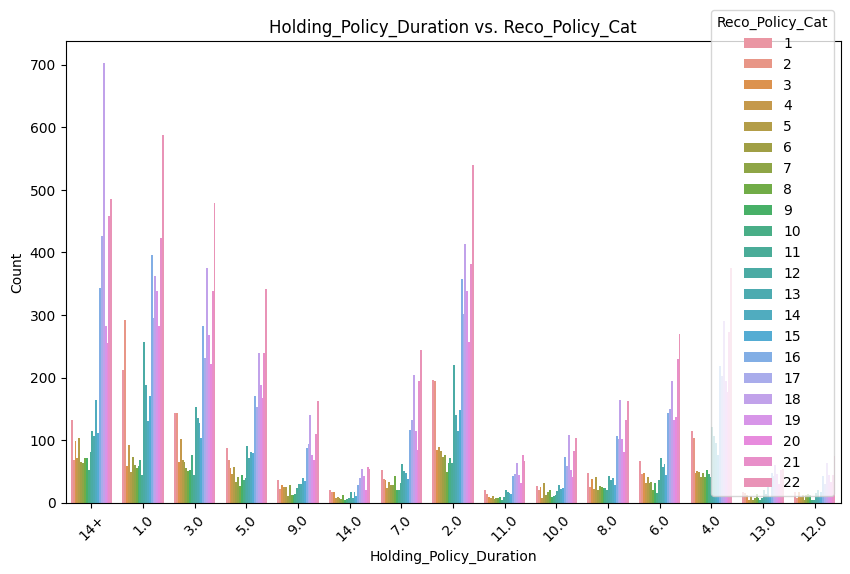

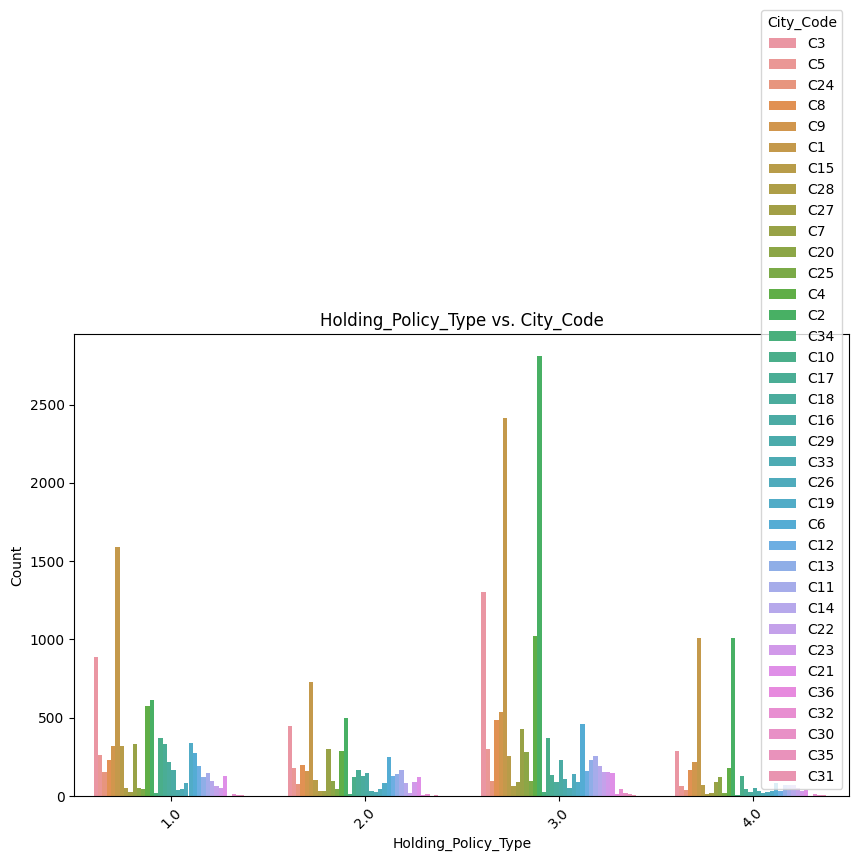

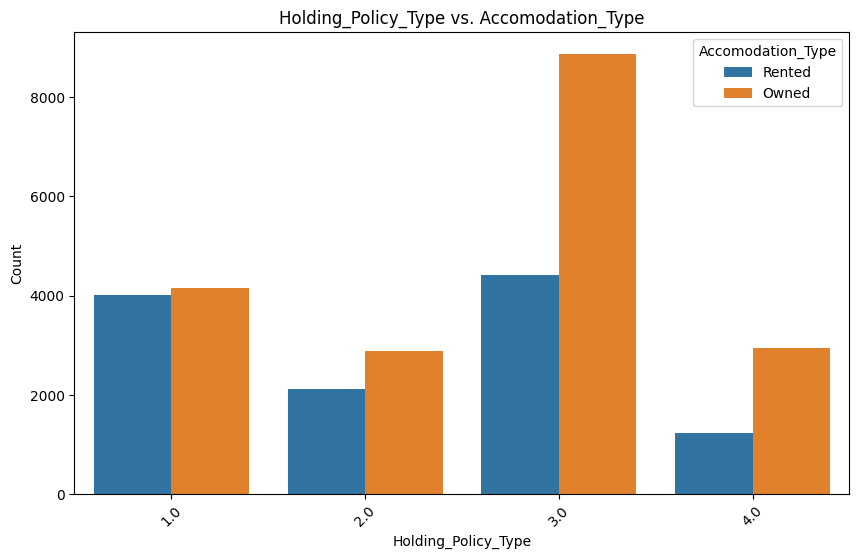

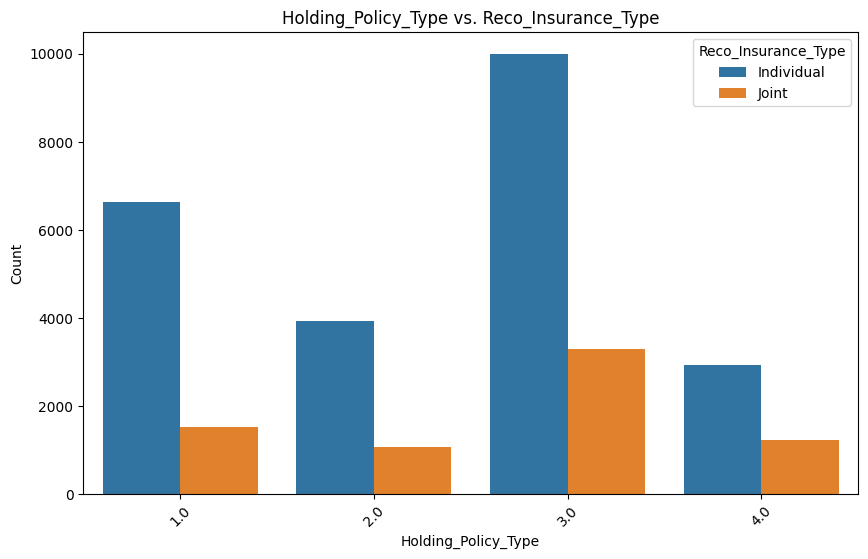

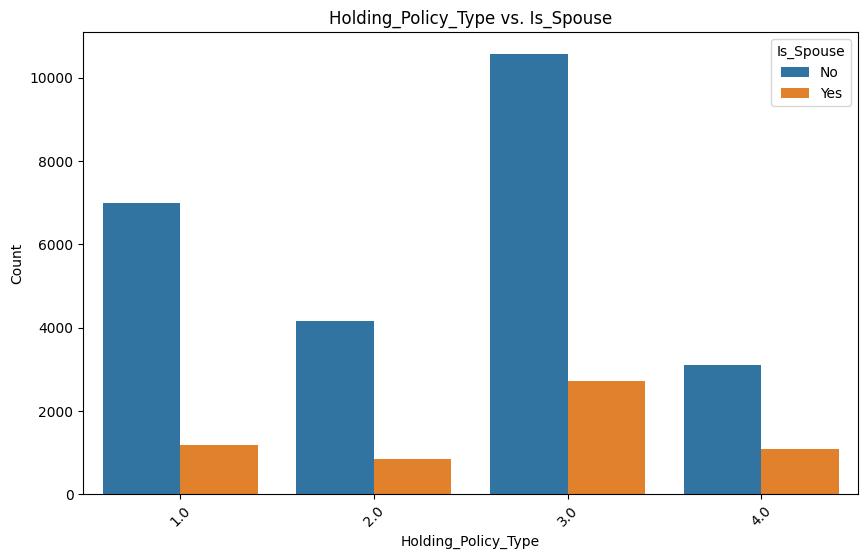

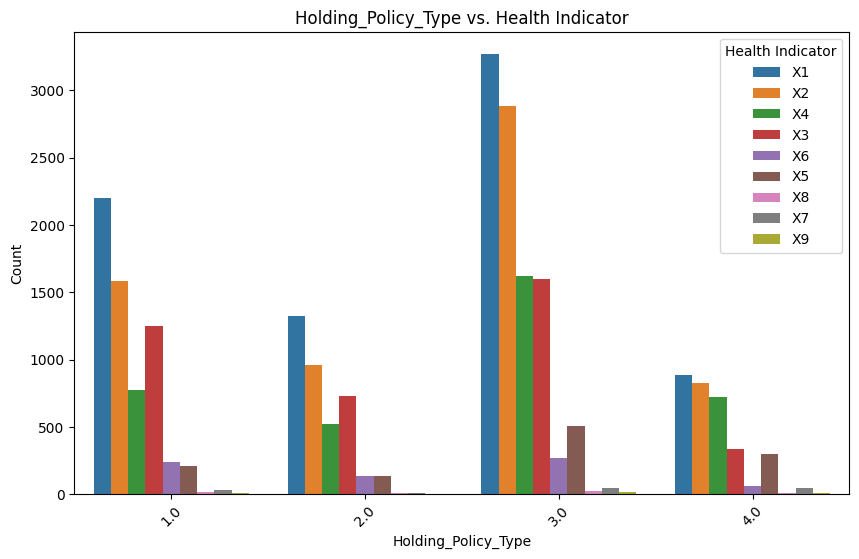

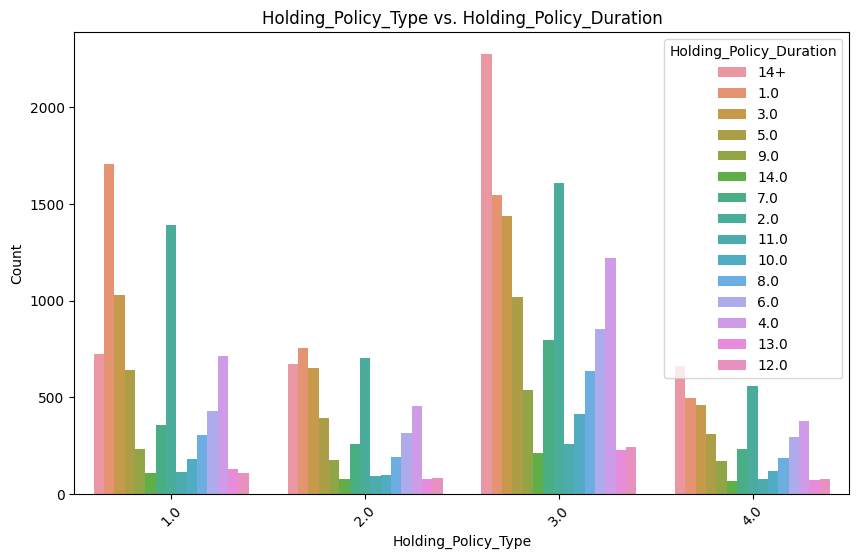

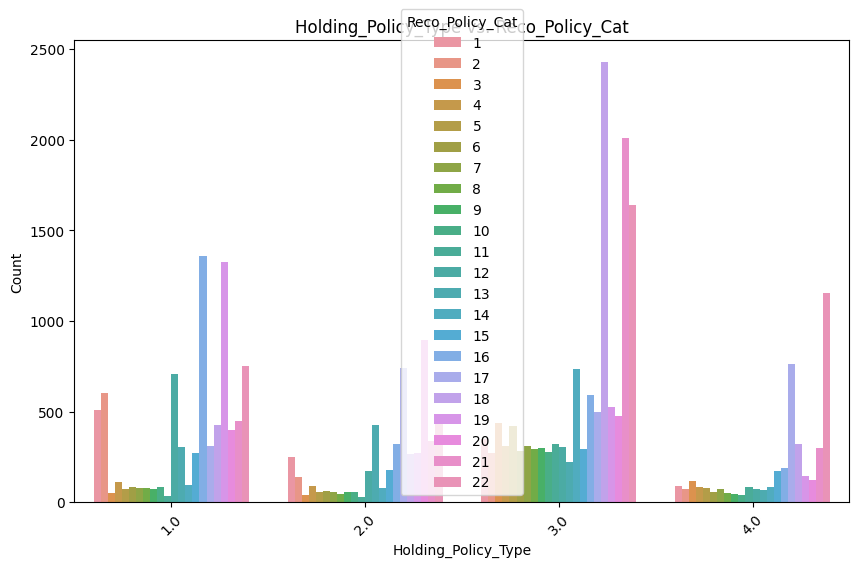

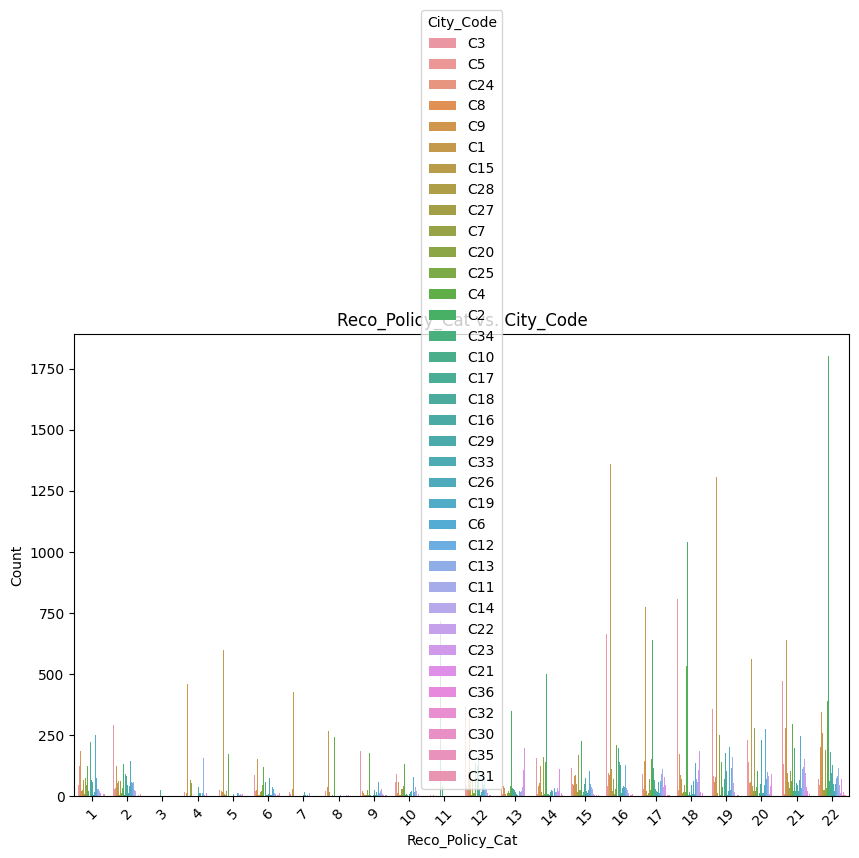

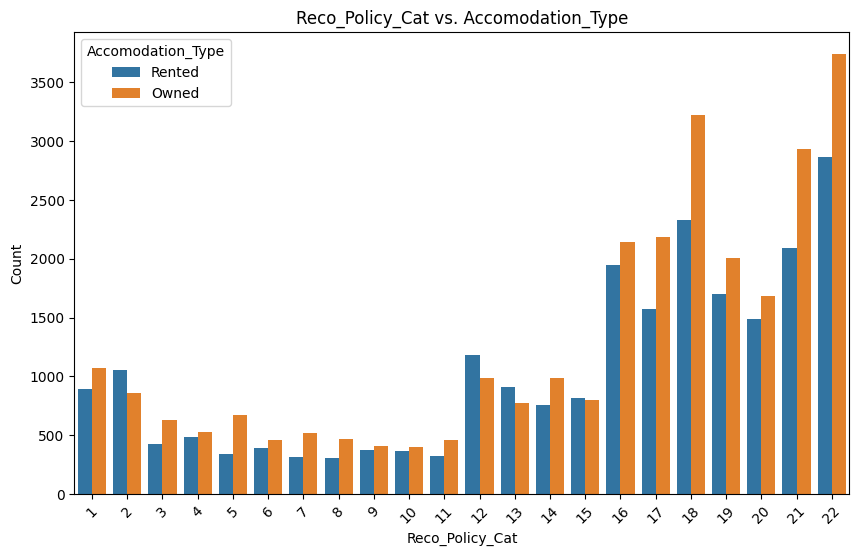

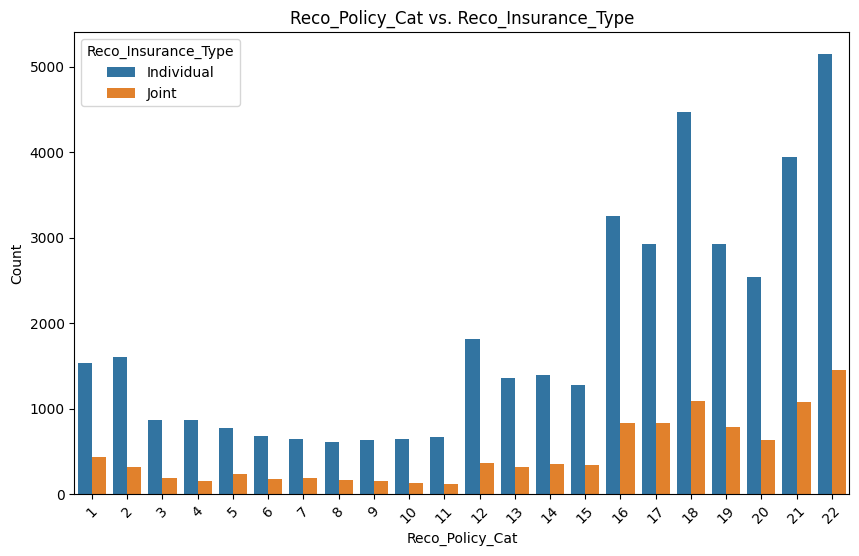

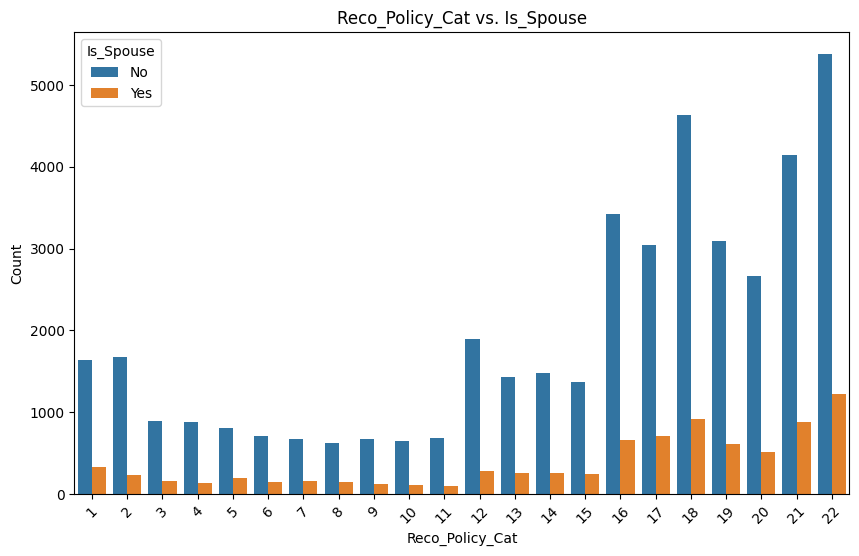

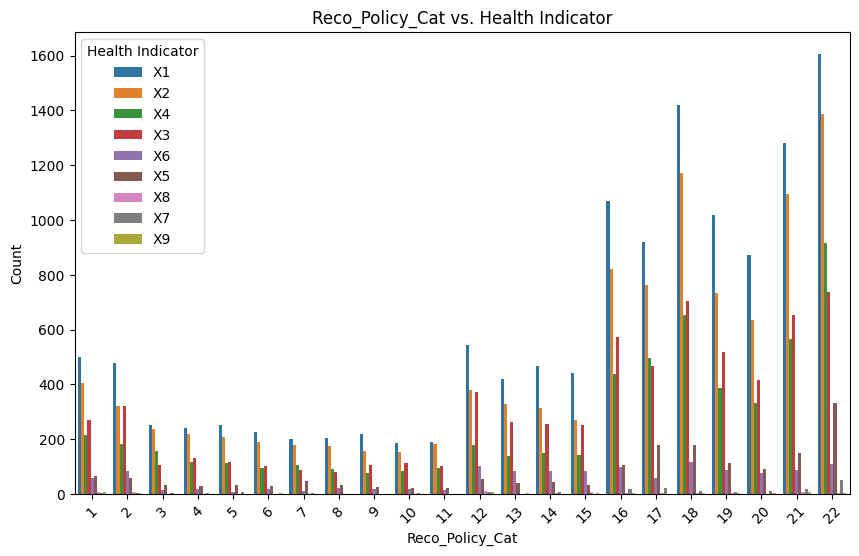

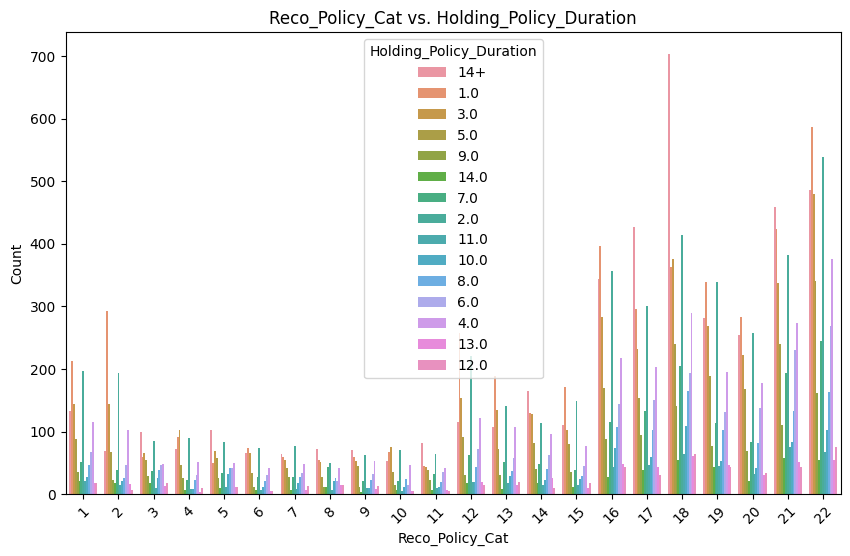

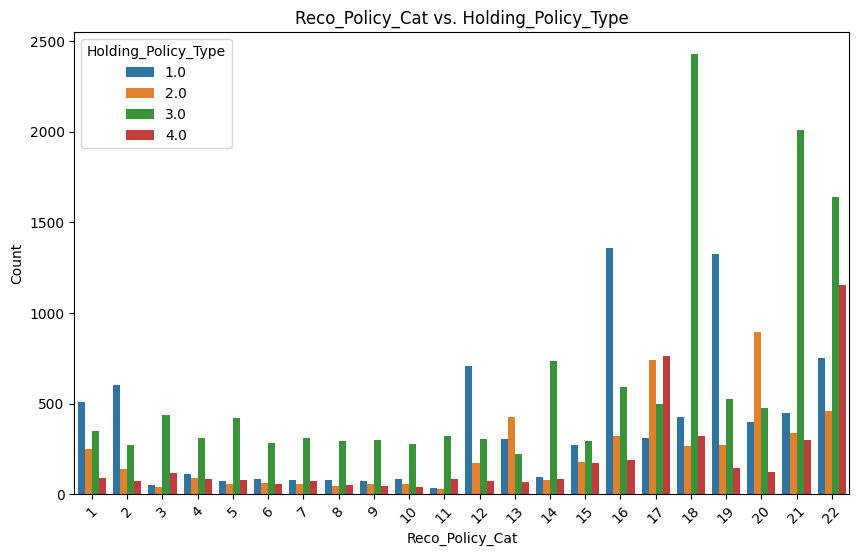

In [20]:
# Define the categorical columns for analysis
categorical_columns = ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat']

# Plot countplots for categorical vs. categorical variables
for cat_col1 in categorical_columns:
    for cat_col2 in categorical_columns:
        if cat_col1 != cat_col2:
            plt.figure(figsize=(10, 6))
            sns.countplot(x=cat_col1, hue=cat_col2, data=data)
            plt.title(f'{cat_col1} vs. {cat_col2}')
            plt.xlabel(cat_col1)
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.legend(title=cat_col2)
            plt.show()


**Observations:**

Countplots for each pair of categorical variables are plotted, showing the count of observations for each category of one variable, segmented by the categories of the other variable.

These countplots help visualize the distribution of one categorical variable across different categories of another categorical variable.

Inferences can be drawn based on the relative frequencies of categories and any patterns or relationships observed between the variables.

## Numerical Vs Numerical

In [21]:
# Pair Plot is plotted and inferences are given

## Line PLots

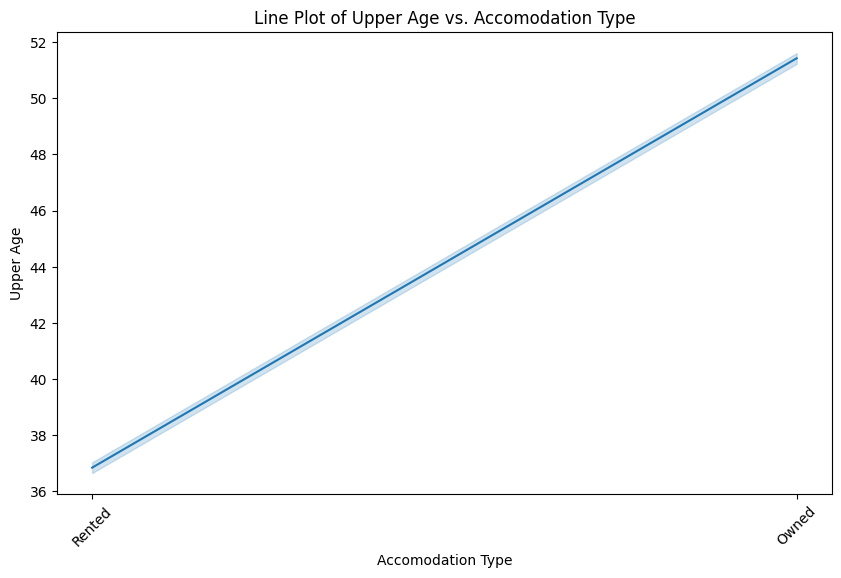

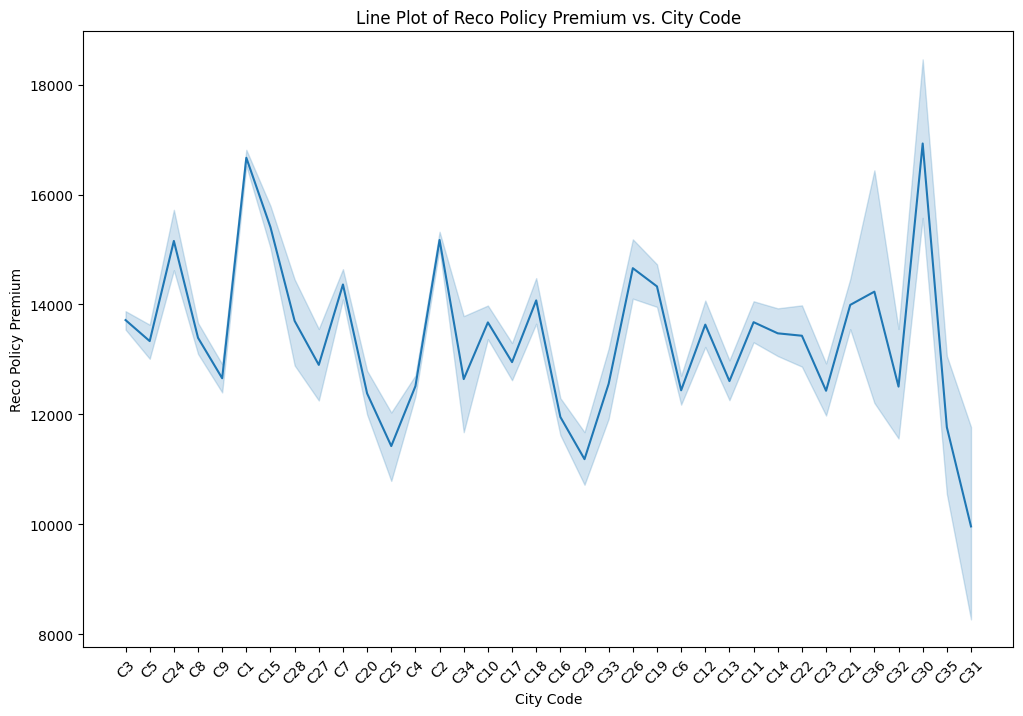

In [22]:
# Line plot for 'Upper_Age' vs. 'Accomodation_Type'
plt.figure(figsize=(10, 6))
sns.lineplot(x='Accomodation_Type', y='Upper_Age', data=data)
plt.title('Line Plot of Upper Age vs. Accomodation Type')
plt.xlabel('Accomodation Type')
plt.ylabel('Upper Age')
plt.xticks(rotation=45)
plt.show()

# Line plot for 'Reco_Policy_Premium' vs. 'City_Code'
plt.figure(figsize=(12, 8))
sns.lineplot(x='City_Code', y='Reco_Policy_Premium', data=data)
plt.title('Line Plot of Reco Policy Premium vs. City Code')
plt.xlabel('City Code')
plt.ylabel('Reco Policy Premium')
plt.xticks(rotation=45)
plt.show()

**Observations:**

Upper Age vs. Accommodation Type:
The line plot shows the distribution of upper age across different accommodation types (Rented and Owned).
It appears that there is a slightly higher median upper age for individuals with Owned accommodation compared to those with Rented accommodation.
However, the difference is not very significant, and there is considerable overlap in the distributions.

Reco Policy Premium vs. City Code:
The line plot displays the variation in recommended policy premium across different city codes.
There seems to be considerable variability in premium amounts across different cities.
Some cities exhibit higher median premium amounts compared to others, indicating potential regional differences in insurance policy pricing.
Certain city codes have more dispersed premium amounts, suggesting a wider range of policy offerings or customer demographics.

Overall, these line plots provide insights into the relationships between numerical and categorical variables, helping to identify potential trends or patterns within the data.

## Response Target Variable Pie Chart

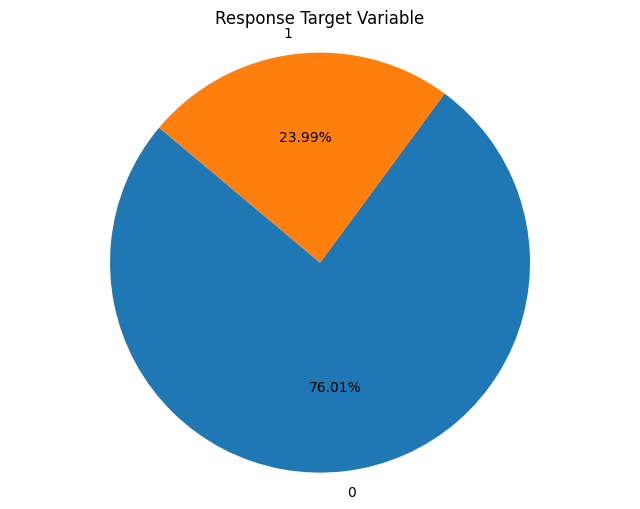

In [23]:
plt.figure(figsize=(8, 6))
plt.pie(data["Response"].value_counts(), labels=data["Response"].unique(), autopct='%.2f%%', startangle=140,radius = 1.2)
plt.title('Response Target Variable')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

**Observations:**

The proportions of each category are reflected in the size of the respective segments of the pie chart. Since there are only two categories, Response = 0 segments are larger than the other with Response = 1, indicating a higher proportion for that category Response = 0

Depending on the data, Response = 0 category dominates the other in terms of proportion, it suggests an imbalance in the dataset. In machine learning and statistical analysis, dealing with imbalanced datasets can require special attention to avoid biases in model training and evaluation.

## Statistical tests

In [24]:
# Chi_ square for categorical variables

#Hypothesis of Chi-square test

#H0 : Attributes are independent

#H1 : Attributes are dependent

p_values = []
for i in ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Type']:
    pval = stats.chi2_contingency(pd.crosstab(data['Response'], data[i]))[1]
    p_values.append(pval)
    
p_val_cat = pd.DataFrame({'Feature': ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Type'],
                         'p_values' : p_values})
p_val_cat

Feature  p_values
0            City_Code  0.725118
1    Accomodation_Type  0.244918
2  Reco_Insurance_Type  0.026535
3            Is_Spouse  0.391721
4     Health Indicator  0.438654
5  Holding_Policy_Type  0.426346

**Observations:**

Based on the p-values obtained from the chi-square test for independence:

City_Code: The p-value (0.725) suggests that there is no significant association between City_Code and the Response variable. Therefore, we fail to reject the null hypothesis, indicating that City_Code and Response are likely independent.

Accomodation_Type: The p-value (0.245) suggests that there is no significant association between Accomodation_Type and the Response variable. Therefore, we fail to reject the null hypothesis, indicating that Accomodation_Type and Response are likely independent.

Reco_Insurance_Type: The p-value (0.027) is less than the significance level (typically 0.05), indicating a significant association between Reco_Insurance_Type and the Response variable. Therefore, we reject the null hypothesis, suggesting that Reco_Insurance_Type and Response are dependent.

Is_Spouse: The p-value (0.392) suggests that there is no significant association between Is_Spouse and the Response variable. Therefore, we fail to reject the null hypothesis, indicating that Is_Spouse and Response are likely independent.

Health Indicator: The p-value (0.439) suggests that there is no significant association between Health Indicator and the Response variable. Therefore, we fail to reject the null hypothesis, indicating that Health Indicator and Response are likely independent.

Holding_Policy_Type: The p-value (0.426) suggests that there is no significant association between Holding_Policy_Type and the Response variable. Therefore, we fail to reject the null hypothesis, indicating that Holding_Policy_Type and Response are likely independent.

Overall, Reco_Insurance_Type appears to be the only categorical variable significantly associated with the Response variable, indicating that individuals recommended with different insurance types may have varying response rates.


In [25]:
data['Holding_Policy_Duration'] = data['Holding_Policy_Duration'].str.replace('+', '').astype(float)

In [26]:
#Hypothesis for Shapiro Test

#H0: Data is normally distributed

#H1: Data is not normally distributed

#Hypothesis for levene Test

#H0: Data has equal variance

#H1: Data has no equal variance

reference_variable = 'Upper_Age'

lst1 = ['Region_Code', 'Upper_Age', 'Lower_Age','Holding_Policy_Duration', 'Reco_Policy_Cat', 'Reco_Policy_Premium']
for i in lst1:
    p_value_shapiro = stats.shapiro(data[i])[1]
    p_value_levene = stats.levene(data[reference_variable], data[i])[1]
    
    if p_value_shapiro < 0.05:
        print(f"The data in column '{i}' does not follow a normal distribution (Shapiro p-value: {p_value_shapiro})")
    else:
        print(f"The data in column '{i}' follows a normal distribution (Shapiro p-value: {p_value_shapiro})")
        
    if p_value_levene < 0.05:
        print(f"The variances of '{reference_variable}' and '{i}' are not equal (Levene p-value: {p_value_levene})")
    else:
        print(f"The variances of '{reference_variable}' and '{i}' are equal (Levene p-value: {p_value_levene})")

The data in column 'Region_Code' does not follow a normal distribution (Shapiro p-value: 0.0)
The variances of 'Upper_Age' and 'Region_Code' are not equal (Levene p-value: 0.0)
The data in column 'Upper_Age' does not follow a normal distribution (Shapiro p-value: 0.0)
The variances of 'Upper_Age' and 'Upper_Age' are equal (Levene p-value: 1.0)
The data in column 'Lower_Age' does not follow a normal distribution (Shapiro p-value: 0.0)
The variances of 'Upper_Age' and 'Lower_Age' are equal (Levene p-value: 0.8112337517481434)
The data in column 'Holding_Policy_Duration' follows a normal distribution (Shapiro p-value: 1.0)
The variances of 'Upper_Age' and 'Holding_Policy_Duration' are equal (Levene p-value: nan)
The data in column 'Reco_Policy_Cat' does not follow a normal distribution (Shapiro p-value: 0.0)
The variances of 'Upper_Age' and 'Reco_Policy_Cat' are not equal (Levene p-value: 0.0)
The data in column 'Reco_Policy_Premium' does not follow a normal distribution (Shapiro p-value:

**Observations:**

Based on the Shapiro-Wilk test results, most of the numerical variables do not follow a normal distribution. Additionally, the Levene test results indicate that the variances of some variables are not equal to that of 'Upper_Age'.

In cases where the data does not follow a normal distribution or the variances are not equal, it is often more appropriate to use non-parametric tests. Non-parametric tests do not rely on the assumption of normality and are more robust to violations of assumptions such as equal variances.

Therefore, for analyzing relationships between variables such as 'Region_Code', 'Lower_Age', 'Reco_Policy_Cat', and 'Reco_Policy_Premium' with respect to 'Upper_Age', it would be more suitable to use non-parametric tests or methods that do not assume normality or equal variances. Some commonly used non-parametric tests include the Mann-Whitney U test, Kruskal-Wallis test, and Spearman correlation.

On the other hand, for 'Holding_Policy_Duration', since it follows a normal distribution and has equal variances with 'Upper_Age', parametric tests such as the t-test or ANOVA could be considered, assuming other assumptions of the tests are met.


In [27]:
#Hypothesis of Mann-Whitney U Test

#H0 : Two samples have the same mean (i.e insignificant)

#H1 : Two samples have different mean (i.e significant)

Response_one = data[data['Response']==1]
Response_zero = data[data['Response']==0]

p_values=[]
for i in lst1:
    pval = stats.mannwhitneyu(Response_one[i], Response_zero[i])[1]
    p_values.append(pval)
p_val_num = pd.DataFrame({'Feature': lst1,
                          'p_values' : p_values})
significant_num_features = p_val_num[p_val_num['p_values']<0.05]
significant_num_features

Feature      p_values
4  Reco_Policy_Cat  1.297275e-97

**Observations:**

The Mann-Whitney U test results indicate that there is a significant difference in the distribution of 'Reco_Policy_Cat' between customers who responded positively (Response = 1) and those who did not respond (Response = 0) to the policy recommendation.

Therefore, 'Reco_Policy_Cat' could be a significant predictor for customer response, suggesting that the recommended policy category may influence customers' decisions to subscribe to the policy.

In [28]:
# Correlation

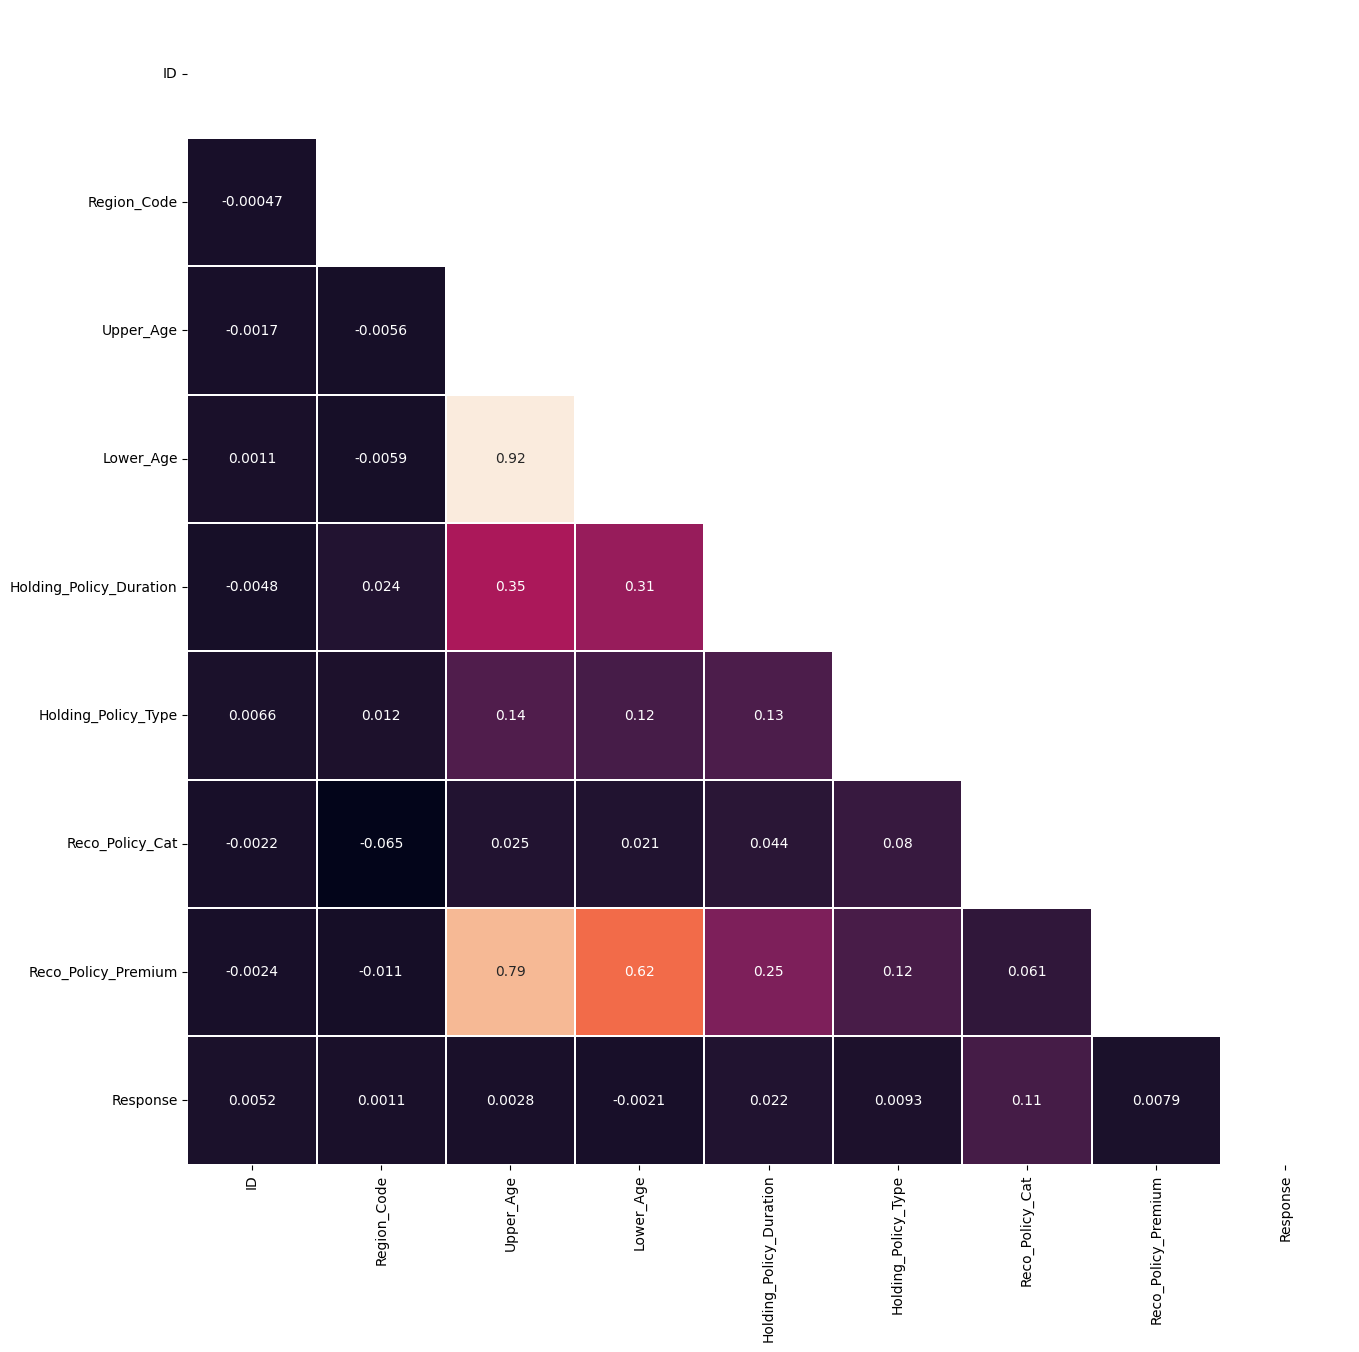

In [29]:
data_num = data.select_dtypes(include = np.number)
data_cat = data.select_dtypes(include = "object")
correlation= data_num.corr()
matrix = np.triu(correlation)

plt.figure(figsize=(15,15))
sns.heatmap(correlation, annot=True, linecolor="white",linewidths=0.02,mask=matrix,cbar=False)
plt.show()

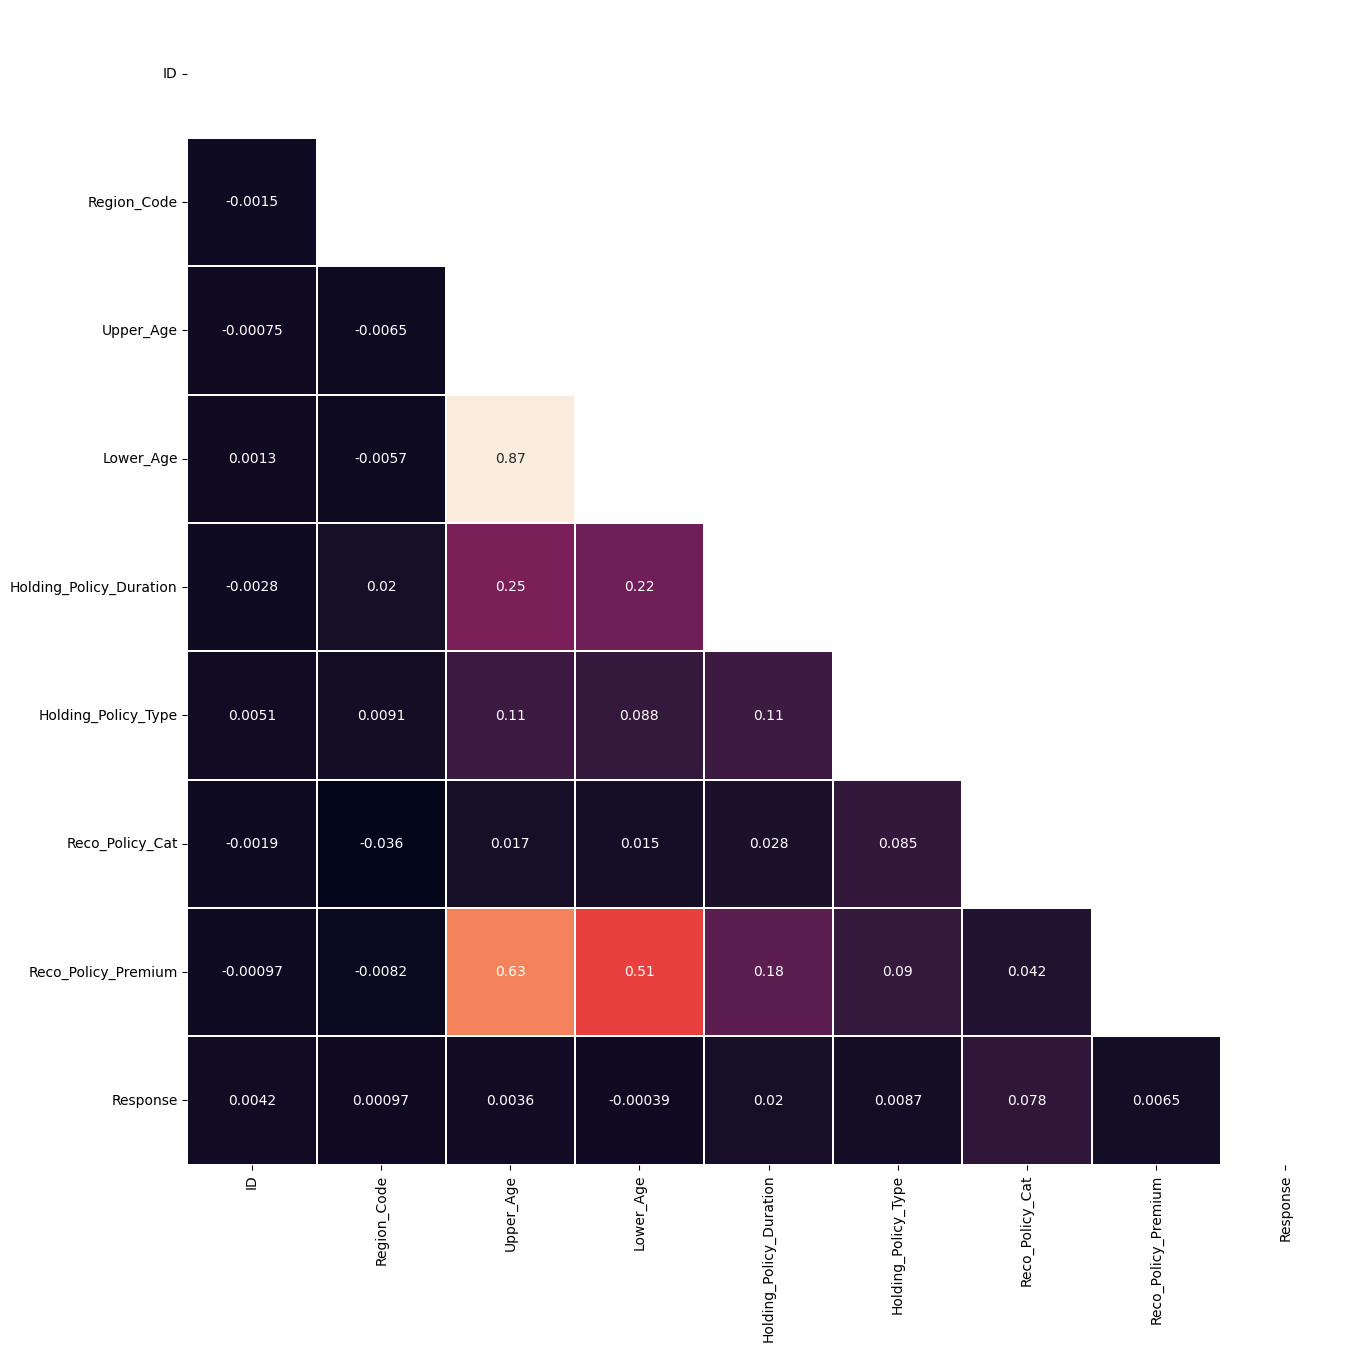

In [30]:
correlation= data_num.corr(method='kendall')
matrix = np.triu(correlation)

plt.figure(figsize=(15,15))
sns.heatmap(correlation, annot=True, linecolor="white",linewidths=0.02,mask=matrix,cbar=False)
plt.show()

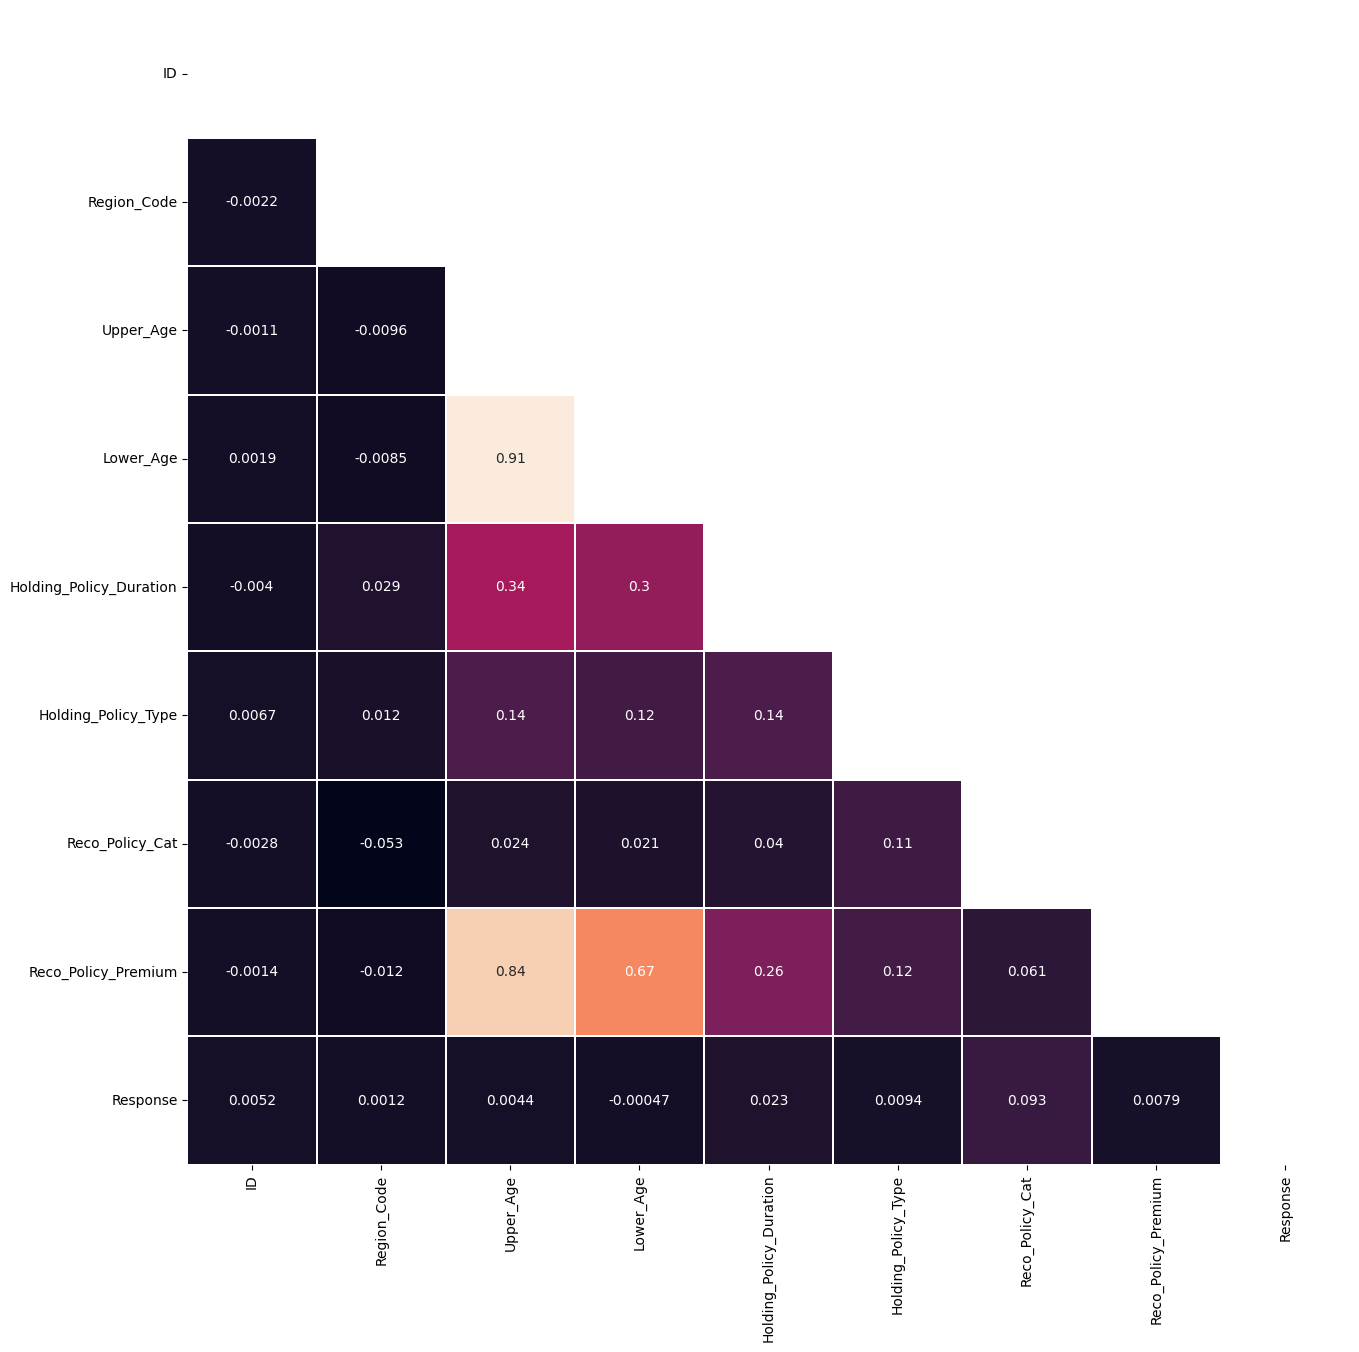

In [31]:
correlation= data_num.corr(method='spearman')
matrix = np.triu(correlation)

plt.figure(figsize=(15,15))
sns.heatmap(correlation, annot=True, linecolor="white",linewidths=0.02,mask=matrix,cbar=False)
plt.show()

**Observations:**

These heatmaps visualize the correlations between numerical variables using different correlation methods: Pearson, Kendall, and Spearman. Here are some inferences based on each heatmap:

Pearson Correlation:
The Pearson correlation heatmap shows the linear relationships between numerical variables.
Strong positive correlations (values close to 1) are observed between certain pairs of variables, indicating a direct linear relationship.
Similarly, strong negative correlations (values close to -1) suggest an inverse linear relationship between variables.
Variables with weak correlations (values close to 0) are less linearly related.
For example, Upper_Age and Lower_Age exhibit a strong positive correlation, as expected since they are likely to be closely related.
Reco_Policy_Cat and Region_Code also show some level of correlation, albeit weaker.

Kendall Correlation:
The Kendall correlation heatmap displays the strength and direction of monotonic relationships between numerical variables.
Similar to Pearson correlation, strong positive and negative correlations are visible, albeit with different values due to the method's focus on monotonicity rather than linearity.
The heatmap reveals relationships that may not be captured by Pearson correlation, especially for non-linear associations.
Overall, the patterns and trends observed in the Kendall correlation heatmap complement those in the Pearson correlation heatmap.

Spearman Correlation:
The Spearman correlation heatmap illustrates the monotonic relationships between numerical variables, similar to Kendall correlation.
It provides insights into the strength and direction of monotonic correlations, which may differ from linear correlations captured by Pearson correlation.
The Spearman correlation heatmap helps identify ordinal relationships and assesses the consistency of rankings between variables.
Like the Kendall correlation heatmap, it offers a different perspective on variable associations, particularly for non-linear relationships.
By examining these three correlation heatmaps, we can gain a comprehensive understanding of the relationships between numerical variables in the dataset, considering both linear and non-linear associations.

## Data Preprocessing

In [32]:
# Missing Values
null = data.isnull().sum()/len(data)*100
null[null>0]

Health Indicator           22.976691
Holding_Policy_Duration    39.799929
Holding_Policy_Type        39.799929
dtype: float64

In [33]:
a = data["Health Indicator"].value_counts()/len(data)*100
proportions = data['Health Indicator'].value_counts(normalize=True)
probabilities = proportions.values
data["Health Indicator"].fillna(pd.Series(np.random.choice(["X1","X2","X3","X4","X5","X6","X7","X8","X9"],p = probabilities,size = len(data))),inplace = True)

In [34]:
data["Holding_Policy_Duration"].replace("14+", 14.0, inplace=True)
data["Holding_Policy_Duration"] = pd.to_numeric(data["Holding_Policy_Duration"])
proportions = data['Holding_Policy_Duration'].value_counts(normalize=True)
probabilities = proportions.values
data["Holding_Policy_Duration"].fillna(pd.Series(np.random.choice([1.0, 14.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 0.0, 13.0], p=probabilities, size=len(data))), inplace=True)

In [35]:
c = data['Holding_Policy_Type'].value_counts()/len(data)*100
proportions = data['Holding_Policy_Type'].value_counts(normalize=True)
probabilities = proportions.values
data["Holding_Policy_Type"].fillna(pd.Series(np.random.choice([3.0,1.0,2.0,4.0],p = probabilities,size = len(data))),inplace = True)

In [36]:
null = data.isnull().sum()/len(data)*100
null[null>0]

Series([], dtype: float64)

Proportion Imputation is performed to fill the missing Values 

In [37]:
# Duplicates

data[data.duplicated()==True]

Empty DataFrame
Columns: [ID, City_Code, Region_Code, Accomodation_Type, Reco_Insurance_Type, Upper_Age, Lower_Age, Is_Spouse, Health Indicator, Holding_Policy_Duration, Holding_Policy_Type, Reco_Policy_Cat, Reco_Policy_Premium, Response]
Index: []

No Duplicate rows observed.

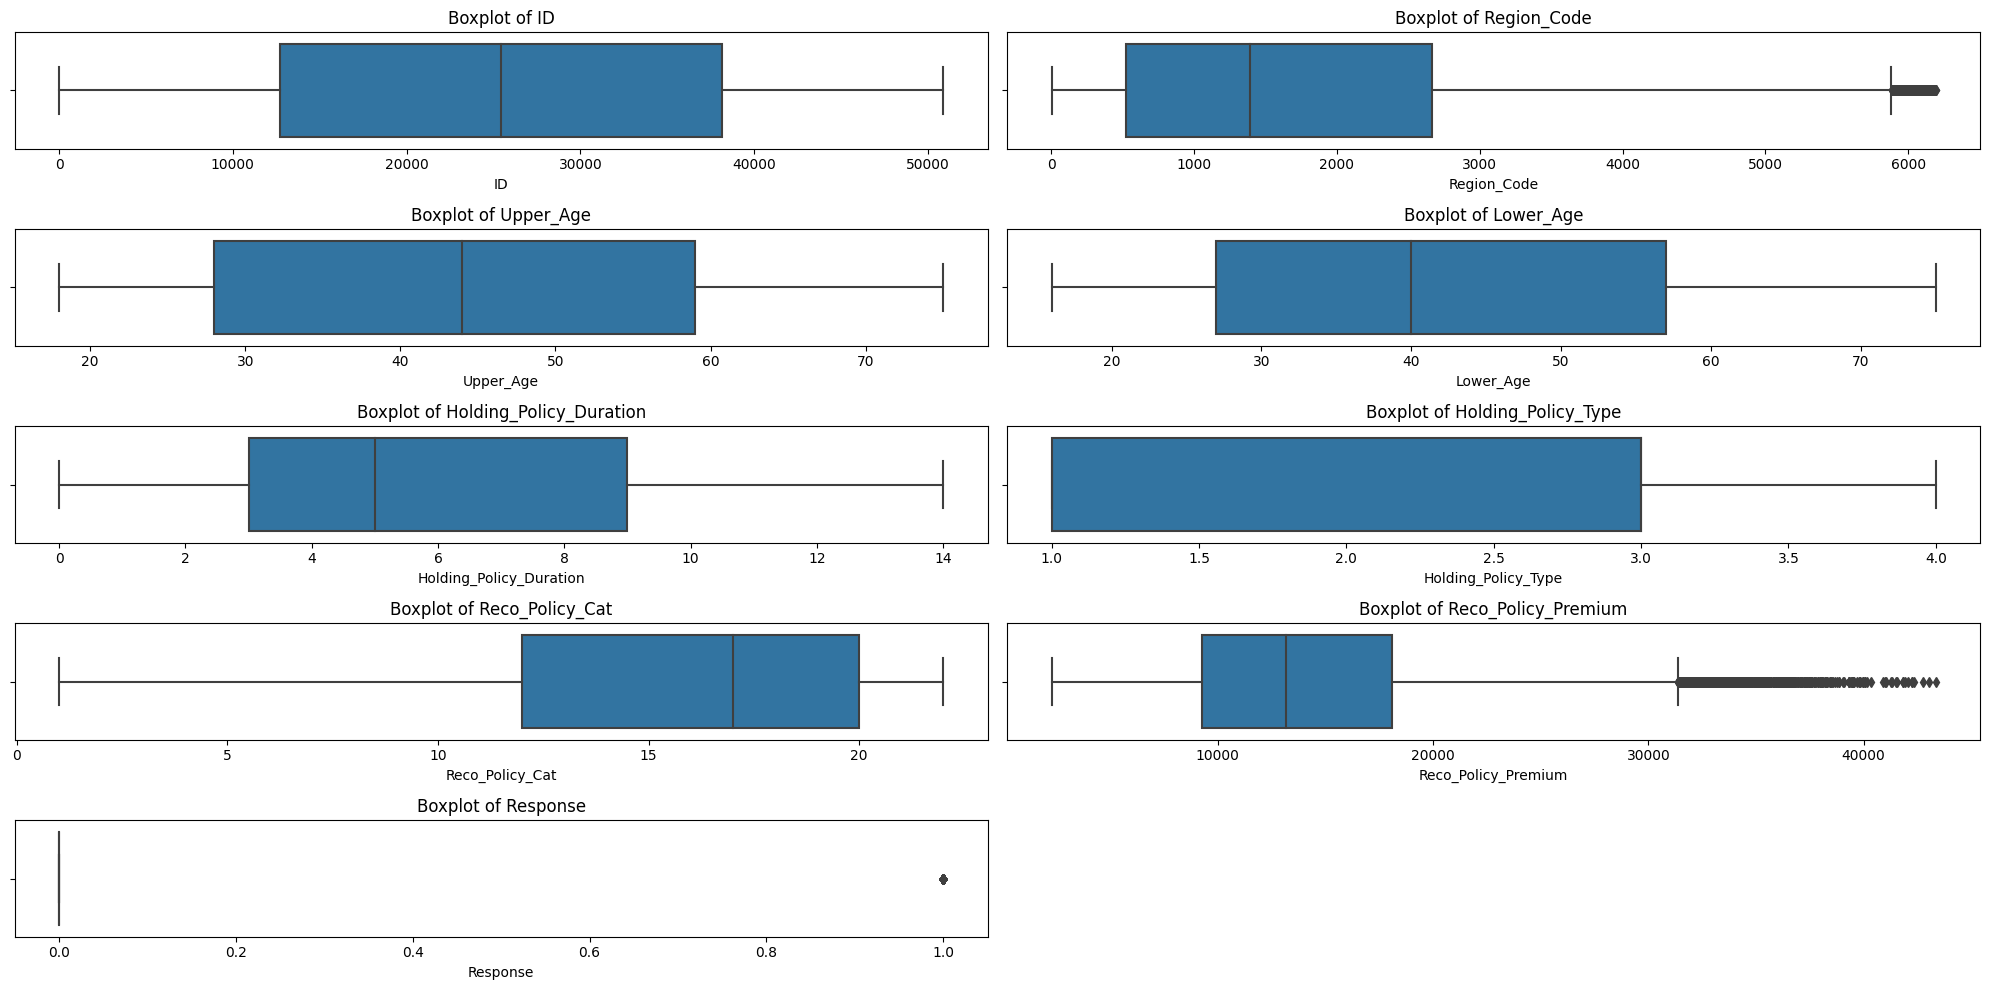

In [38]:
# Outliers
data_num = data.select_dtypes(include = np.number)
data_cat = data.select_dtypes(include = "object")
plt.figure(figsize=(20, 10))
for i, column in enumerate(data_num.columns, start=1):
    plt.subplot(5, 2, i)  # Adjust the subplot index
    sns.boxplot(x=data_num[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()
# Region Code and Reco_policy_premium has outliers

**Observations:**

Region_Code and Reco_Policy_Premium exhibit outliers, yet we opt not to address them, as doing so could result in the loss of valuable data and potentially compromise the efficacy of our modeling approach.

In [39]:
data_num.skew()

ID                         0.000000
Region_Code                0.798096
Upper_Age                  0.217370
Lower_Age                  0.330594
Holding_Policy_Duration    0.627889
Holding_Policy_Type       -0.197569
Reco_Policy_Cat           -0.928224
Reco_Policy_Premium        0.782463
Response                   1.217936
dtype: float64

**Observations:**

The dataset's features exhibit varying degrees of skewness, as reflected by their respective skewness coefficients. 

Region_Code and Reco_Policy_Premium have positive skewness, suggesting a concentration of data towards lower values with a tail extending towards higher values.

Upper_Age and Lower_Age show slight positive skewness, indicating a similar concentration towards lower ages with a few instances of higher ages. 

Holding_Policy_Duration appears to have moderate positive skewness, implying a concentration of shorter policy durations with some longer durations present. 

Reco_Policy_Cat demonstrates slight negative skewness, suggesting a concentration towards higher policy categories with fewer instances of lower categories. Finally, Response has positive skewness, indicating a concentration of negative responses with fewer positive responses.

In [40]:
data_num.kurt()

ID                        -1.200000
Region_Code               -0.202240
Upper_Age                 -1.233867
Lower_Age                 -1.170556
Holding_Policy_Duration   -0.911538
Holding_Policy_Type       -1.197017
Reco_Policy_Cat           -0.310533
Reco_Policy_Premium        0.423053
Response                  -0.516653
dtype: float64

**Observations:**

The z-scores for the features in the dataset indicate their deviation from the mean in terms of standard deviations. 

Negative z-scores suggest that the values are below the mean, while positive z-scores indicate values above the mean. 

A z-score of -1.2 for ID suggests that it is below the mean by 1.2 standard deviations. 

Similarly, Region_Code, Upper_Age, Lower_Age, Holding_Policy_Duration, Reco_Policy_Cat, and Response have negative z-scores, indicating that their values are below their respective means.
In contrast, Reco_Policy_Premium has a positive z-score, suggesting that its values are above the mean.

## Base Model

In [41]:
x = data.drop(columns= ["ID","Response"],axis = 1)
y = data["Response"]
xtrain,xtest,ytrain,ytest = train_test_split(x,y,train_size = 0.8, test_size = 0.2, random_state =3, stratify = y)
print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape)

(40705, 12) (10177, 12) (40705,) (10177,)


In [42]:
# Frequency Encoding for City Code

xtrain["City_Code"].value_counts()
geo_encoding = xtrain["City_Code"].value_counts().to_dict()
xtrain["City_Code"]=xtrain["City_Code"].map(geo_encoding)
xtest["City_Code"]=xtest["City_Code"].map(geo_encoding)
xtrain.head()

City_Code  Region_Code Accomodation_Type Reco_Insurance_Type  \
30990        744         1640            Rented          Individual   
3610        1512          127            Rented               Joint   
32674       3912          409            Rented          Individual   
3685         948         4301             Owned          Individual   
19142       6176         2162            Rented          Individual   

       Upper_Age  Lower_Age Is_Spouse Health Indicator  \
30990         35         35        No               X3   
3610          62         49       Yes               X2   
32674         27         27        No               X1   
3685          56         56        No               X4   
19142         40         40        No               X1   

       Holding_Policy_Duration  Holding_Policy_Type  Reco_Policy_Cat  \
30990                      4.0                  3.0               13   
3610                       1.0                  1.0                1   
32674                      3.0                  4.0               19   
3685                       1.0                  2.0                1   
19142                      9.0                  2.0               13   

       Reco_Policy_Premium  
30990               9120.0  
3610               26376.0  
32674              11916.0  
3685               13260.0  
19142              12906.0

In [43]:
xtrain["Health Indicator"].value_counts()
health_encoding = xtrain["Health Indicator"].value_counts().to_dict()
xtrain["Health Indicator"]=xtrain["Health Indicator"].map(health_encoding)
xtest["Health Indicator"]=xtest["Health Indicator"].map(health_encoding)
xtrain.head()

City_Code  Region_Code Accomodation_Type Reco_Insurance_Type  \
30990        744         1640            Rented          Individual   
3610        1512          127            Rented               Joint   
32674       3912          409            Rented          Individual   
3685         948         4301             Owned          Individual   
19142       6176         2162            Rented          Individual   

       Upper_Age  Lower_Age Is_Spouse  Health Indicator  \
30990         35         35        No              7023   
3610          62         49       Yes             10693   
32674         27         27        No             13456   
3685          56         56        No              5973   
19142         40         40        No             13456   

       Holding_Policy_Duration  Holding_Policy_Type  Reco_Policy_Cat  \
30990                      4.0                  3.0               13   
3610                       1.0                  1.0                1   
32674                      3.0                  4.0               19   
3685                       1.0                  2.0                1   
19142                      9.0                  2.0               13   

       Reco_Policy_Premium  
30990               9120.0  
3610               26376.0  
32674              11916.0  
3685               13260.0  
19142              12906.0

In [44]:
# Dummy encoding for Accomodation_type,Reco_Insurance_Type
xtrain = pd.get_dummies(xtrain,drop_first = True,dtype = int,columns=["Accomodation_Type","Reco_Insurance_Type","Is_Spouse"])
xtest = pd.get_dummies(xtest,drop_first=True, dtype = int,columns=["Accomodation_Type","Reco_Insurance_Type","Is_Spouse"])

In [45]:
xtrain.head()

City_Code  Region_Code  Upper_Age  Lower_Age  Health Indicator  \
30990        744         1640         35         35              7023   
3610        1512          127         62         49             10693   
32674       3912          409         27         27             13456   
3685         948         4301         56         56              5973   
19142       6176         2162         40         40             13456   

       Holding_Policy_Duration  Holding_Policy_Type  Reco_Policy_Cat  \
30990                      4.0                  3.0               13   
3610                       1.0                  1.0                1   
32674                      3.0                  4.0               19   
3685                       1.0                  2.0                1   
19142                      9.0                  2.0               13   

       Reco_Policy_Premium  Accomodation_Type_Rented  \
30990               9120.0                         1   
3610               26376.0                         1   
32674              11916.0                         1   
3685               13260.0                         0   
19142              12906.0                         1   

       Reco_Insurance_Type_Joint  Is_Spouse_Yes  
30990                          0              0  
3610                           1              1  
32674                          0              0  
3685                           0              0  
19142                          0              0

In [46]:
# Rename the encoded columns
xtrain.columns
xtrain = xtrain.rename(columns={"Accomodation_Type_Rented":"Accomodation_Type","Reco_Insurance_Type_Joint":"Reco_Insurance_Type","Is_Spouse_Yes":"Is_Spouse"})

In [47]:
xtest  = xtest.rename(columns={"Accomodation_Type_Rented":"Accomodation_Type","Reco_Insurance_Type_Joint":"Reco_Insurance_Type","Is_Spouse_Yes":"Is_Spouse"})

In [48]:
xtrain.head()

City_Code  Region_Code  Upper_Age  Lower_Age  Health Indicator  \
30990        744         1640         35         35              7023   
3610        1512          127         62         49             10693   
32674       3912          409         27         27             13456   
3685         948         4301         56         56              5973   
19142       6176         2162         40         40             13456   

       Holding_Policy_Duration  Holding_Policy_Type  Reco_Policy_Cat  \
30990                      4.0                  3.0               13   
3610                       1.0                  1.0                1   
32674                      3.0                  4.0               19   
3685                       1.0                  2.0                1   
19142                      9.0                  2.0               13   

       Reco_Policy_Premium  Accomodation_Type  Reco_Insurance_Type  Is_Spouse  
30990               9120.0                  1                    0          0  
3610               26376.0                  1                    1          1  
32674              11916.0                  1                    0          0  
3685               13260.0                  0                    0          0  
19142              12906.0                  1                    0          0

In [49]:
def model_validation_train(model,xtrain,ytrain,xtest,ytest):
    m = model
    m.fit(xtrain,ytrain)
    pred_train = m.predict(xtrain)
    print("confusion Matrix :\n",confusion_matrix(ytrain, pred_train))
    print("Classification Report:\n",classification_report(ytrain, pred_train))
    sns.heatmap(confusion_matrix(ytrain,pred_train),annot = True)
    plt.show()
    
    
    # ROC Curve
    pred_proba_train = m.predict_proba(xtrain)[:,1]
    print("ROC-AUC:\n",roc_auc_score(ytrain,pred_proba_train))
    fpr,tpr,thres = roc_curve(ytrain,pred_proba_train)
    plt.plot([0,1],[0,1],ls='--',color = 'red')
    # data on x axis and data on y axis
    plt.plot(fpr,tpr)
    plt.show()
    
    # Caluculate Residuals
    residuals_train = ytrain - pred_proba_train
    
    return m,residuals_train

Confusion Matrix:
The confusion matrix shows the performance of a classification model by comparing actual and predicted classes.
In this case, there are two classes: 0 (negative class) and 1 (positive class).
The matrix indicates that the model correctly predicted 30,938 instances of the negative class (0), while it did not predict any instances of the positive class (1).
Additionally, the model incorrectly predicted 9,767 instances as the negative class when they actually belong to the positive class.

Classification Report:
The classification report provides key metrics for evaluating the performance of a classification model, including precision, recall, F1-score, and support (number of instances).
For the negative class (0), the precision is 0.76, indicating that 76% of the instances predicted as negative are indeed negative. However, the recall is 1.00, meaning that the model captured all instances of the negative class in the dataset. The F1-score, which combines precision and recall, is 0.86.
For the positive class (1), the precision is 0.00, indicating that the model did not correctly predict any instances of the positive class. The recall is also 0.00, indicating that the model failed to capture any instances of the positive class. Consequently, the F1-score for the positive class is 0.00.
The accuracy of the model is 0.76, indicating that it correctly predicted the class for 76% of the instances in the dataset.
The macro average F1-score, which considers the unweighted mean of the F1-scores for each class, is 0.43. The weighted average F1-score, which considers the support for each class, is 0.66.

Inferences:
The model's performance is heavily skewed towards the negative class (0), with high precision and recall for this class.
However, the model performs poorly for the positive class (1), failing to predict any instances correctly. This indicates a significant imbalance in the dataset or potential issues with the model's ability to capture the positive class.
Further investigation is necessary to understand why the model fails to predict instances of the positive class and to address any underlying issues, such as class imbalance, feature selection, or model complexity.

### Base model

Recursive partitioning is a fundamental tool in data mining. It helps us explore the structure of a set of data, while developing easy to visualize decision rules for predicting a categorical (classification tree) or continuous (regression tree) outcome.

CART Modeling via DecisionTreeClassifier

Classification and Regression Trees (as described by Brieman, Freidman, Olshenm and Stone) can be generated through the DecisionTreeClassifier package.

i) Grow the tree

For controlling tree growth, we set the following parameters:
* max_depth: The maximum depth of the tree.
* min_samples_split: The minimum number of samples required to split an internal node
* min_samples_leaf: min no of samples at a leaf node
* min_impurity_decrease : A node will be split if this split induces a decrease of the impurity greater than or equal to this value. 

### K Fold cross validation

When we are dealing with classification problem of imbalance class distribution, we have to use StratifiedKFold.

KFold devides the dataset into k folds.

Where as Stratified ensures that each fold of dataset has the same proportion of observations with a given label.

Refer: https://www.kaggle.com/discussions/general/231173

In [50]:
def eval_CART(classifier, xtrain, ytrain):

    # Perform 10-fold cross-validation with recall scoring

    skf             =    StratifiedKFold(n_splits=10, shuffle = True, random_state = 12345)
    recall_scores   =    cross_val_score(classifier, xtrain, ytrain, cv = skf, scoring = 'recall')

    # Calculate precision scores
    precision_scores   =  cross_val_score(classifier, xtrain, ytrain, cv = skf, scoring = 'precision')

    # Calculate accuracy scores
    accuracy_scores   =  cross_val_score(classifier, xtrain, ytrain, cv = skf, scoring = 'accuracy')

    # Calculate ROC-AUC scores
    roc_auc_scores    =  cross_val_score(classifier, xtrain, ytrain, cv = skf, scoring='roc_auc')

    # Calculate F1 scores
    f1_scores        =   cross_val_score(classifier, xtrain, ytrain, cv = skf, scoring = 'f1')

    # Calculate and display the mean scores for each metric
    print("Mean Recall:", recall_scores.mean())
    print("Mean Precision:", precision_scores.mean())
    print("Mean Accuracy:", accuracy_scores.mean())
    print("Mean ROC-AUC Score:", roc_auc_scores.mean())
    print("Mean F1 Score:", f1_scores.mean())

    # Plot ROC curve
    y_scores = cross_val_predict(classifier, xtrain, ytrain, cv = skf, method = "predict_proba")
    fpr, tpr, thresholds = roc_curve(ytrain, y_scores[:, 1])
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], ls='--',color = "red")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    # Calculate confusion matrix and classification report
    y_pred = cross_val_predict(classifier, xtrain, ytrain, cv = skf)
    conf_matrix = confusion_matrix(ytrain, y_pred)
    sns.heatmap(conf_matrix,annot=True)
    class_report = classification_report(ytrain, y_pred)

    # Display confusion matrix and classification report
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)

In [51]:
def eval_CART_test(classifier, xtest, ytest):
    #Predict the response for test dataset
    predicted_testing = classifier.predict(xtest)
    matrix             = confusion_matrix(ytest, predicted_testing)
    print("\nTesting Data")
    print(matrix)
    draw_cm(ytest, predicted_testing )

    accuracy_train = classifier.score(xtest, ytest) 
    print("Testing Accuracy: %.3f%%" % (accuracy_train * 100.0))
    measures_test      = classification_report(ytest, predicted_testing) 
    print("\nTesting data")
    print(measures_test) 
    print("\nTesting  data")
    draw_roc(ytest, predicted_testing)  

### Before Pruning

Mean Recall: 0.3221069223283051
Mean Precision: 0.30650705834699643
Mean Accuracy: 0.6644883477971172
Mean ROC-AUC Score: 0.5446722045344891
Mean F1 Score: 0.31456584070879123


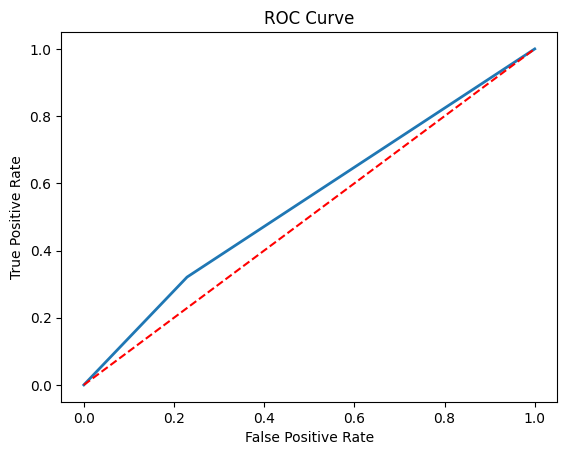

Confusion Matrix:
 [[23887  7051]
 [ 6594  3173]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.78     30938
           1       0.31      0.32      0.32      9767

    accuracy                           0.66     40705
   macro avg       0.55      0.55      0.55     40705
weighted avg       0.67      0.66      0.67     40705



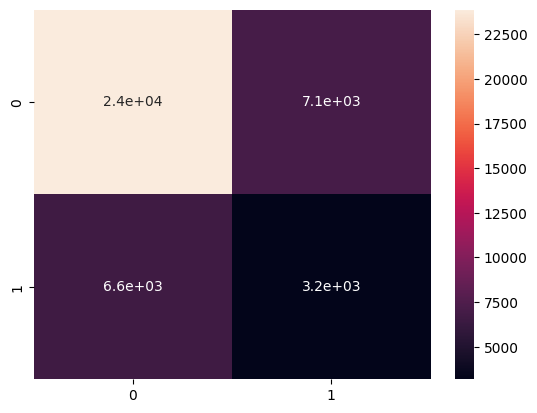

In [52]:
classifier      =    DecisionTreeClassifier().fit(xtrain, ytrain)
eval_CART(classifier, xtrain, ytrain)


Testing Data
[[5943 1792]
 [1628  814]]


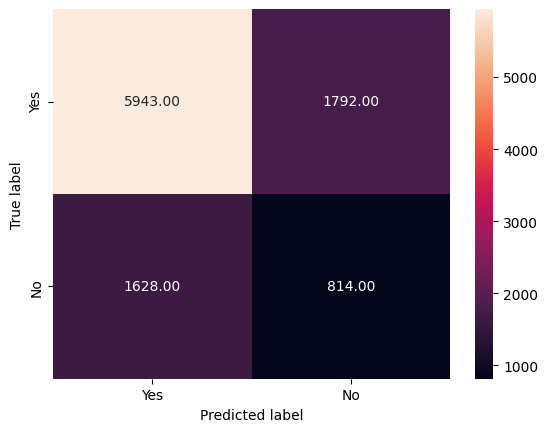

Testing Accuracy: 66.395%

Testing data
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      7735
           1       0.31      0.33      0.32      2442

    accuracy                           0.66     10177
   macro avg       0.55      0.55      0.55     10177
weighted avg       0.67      0.66      0.67     10177


Testing  data


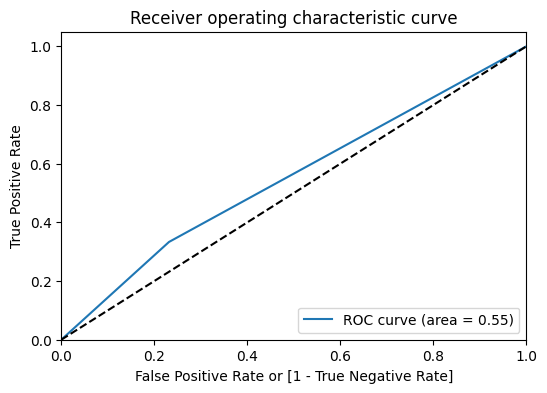

In [53]:
eval_CART_test(classifier, xtest, ytest)

**Explanation:**

Stratified K-Fold ensures every fold has a representative class distribution. Better Generalization: Since each fold has a similar distribution, the model is less likely to be biased towards any particular class, leading to better generalization on unseen data. We have used 10-fold cross validation instead of  using two parts (training and test data) for building and evaluation of models. With this 10-fold cross validation method we have one data set which we divide randomly into 10 parts. We use 9 of those parts for training and reserve one tenth for testing. We repeat this procedure 10 times each time reserving a different tenth for testing.

**Observations:**

Based on the stratified cross-validated evaluation metrics:

Mean Recall: x  (indicating that it correctly identifies around x% of the positive cases (Response = 1) on average across the 10 folds)

Mean Precision: x  (indicating that out of all the instances predicted as positive, only about x% are actually true positive cases).

Mean Accuracy: x (suggesting that it correctly predicts the class label for about x% of the instances on average).

Mean ROC-AUC Score: x (which is slightly better than random guessing (0.5), indicating that the model has some ability to discriminate between the positive and negative classes)

Mean F1 Score: x (indicating that the model's performance is suboptimal in terms of both precision and recall).

### Confusion Matrix and Classification Report:

The confusion matrix shows that out of x instances of class 0 (Response = 0), the model correctly predicts x instances (true negatives), but misclassifies x instances (false negatives).

For the class 1 (Response = 1), the model correctly predicts 3240 instances (true positives) but misclassifies x instances (false positives) out of x instances.

The classification report provides additional details on precision, recall, and F1-score for both classes.

**Inferences**:

The model's performance is mediocre, with relatively low recall, precision, and F1-score.

It struggles particularly with identifying positive cases (Response = 1), as indicated by the low recall.

The model may benefit from further optimization, feature engineering, or the use of more sophisticated algorithms to improve its predictive performance.

### Evaluating model performance after pruning

Let us look at the following parameters:

| Parameter | Details                            |
| ----------------- | --------------------------------------------------------|
| criterion | This parameter allows us to use the different-different attribute selection measure.    Allowed criteria are “gini” (default) for the Gini index and “entropy” for the information gain.|
| splitter  | This parameter allows us to choose the split strategy. Allowed strategies are “best” to  choose the best split and “random” to choose the best random split| 
| max_depth | This parameter allows us to state the maximum depth of the tree. If None, then nodes are  expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting |

Mean Recall: 0.32200425356981055
Mean Precision: 0.3089613811261183
Mean Accuracy: 0.6628916221104872
Mean ROC-AUC Score: 0.5473805565856573
Mean F1 Score: 0.3151907035424255


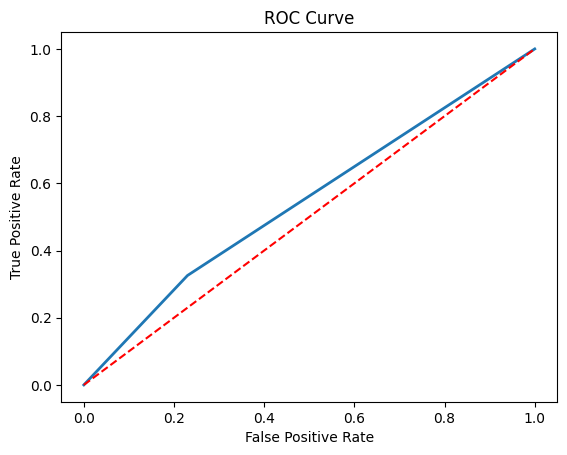

Confusion Matrix:
 [[23801  7137]
 [ 6647  3120]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.78     30938
           1       0.30      0.32      0.31      9767

    accuracy                           0.66     40705
   macro avg       0.54      0.54      0.54     40705
weighted avg       0.67      0.66      0.66     40705



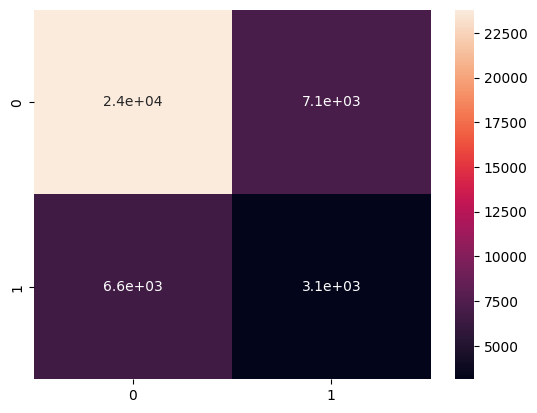

In [54]:
classifier    =   DecisionTreeClassifier(criterion="gini", splitter = 'best', max_depth = 55)
classifier.fit(xtrain, ytrain)
eval_CART(classifier, xtrain, ytrain)


Testing Data
[[5960 1775]
 [1618  824]]


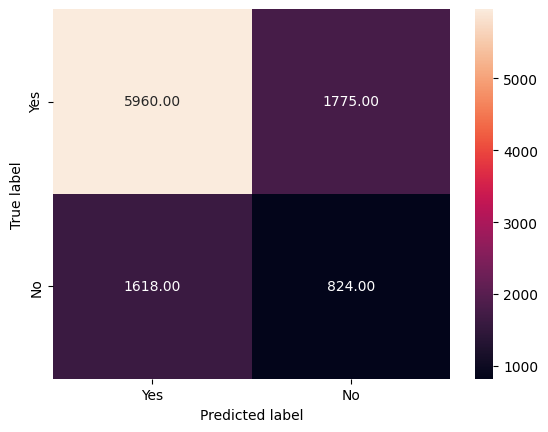

Testing Accuracy: 66.660%

Testing data
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      7735
           1       0.32      0.34      0.33      2442

    accuracy                           0.67     10177
   macro avg       0.55      0.55      0.55     10177
weighted avg       0.67      0.67      0.67     10177


Testing  data


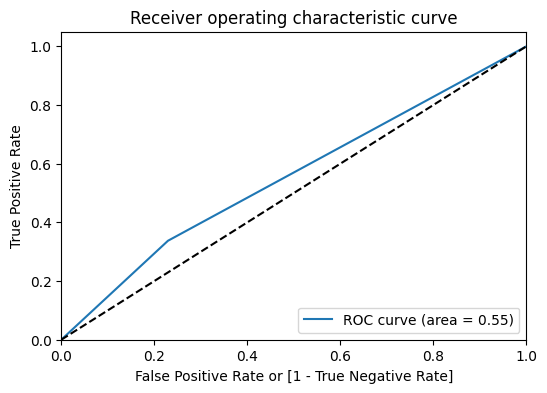

In [55]:
eval_CART_test(classifier, xtest, ytest)

## Assumptions Check

Assumption 1 - Appropriate outcome type (Must be categorical)

Assumption 2 - Linearity of independent variables and log odds - for Logistic Regression models

Assumption 3 - No strongly influential outliers 

Assumption 4 - Absence of multicollinearity

Assumption 5 - Independence of observations

Assumption 6 - Sufficiently large sample size

#### Assumption 1 - Appropriate outcome type (Must be binary)

In [56]:
data["Response"].dtypes

dtype('int64')

In [57]:
data["Response"].value_counts()

Response
0    38673
1    12209
Name: count, dtype: int64

The target variable is categorical having 0 and 1 binary

#### Assumption 2 - Linearity of independent variables and log odds - for Logistic Regression models

In [58]:
# Create interaction term

data_num = data.select_dtypes(include=np.number)
x = data_num.drop(["ID","Response"],axis =1)
y = data_num["Response"]
# Apply logarithm transformation with a small constant
transformer = FunctionTransformer(func=lambda x: np.log(x + 1e-10))
X_transformed = transformer.fit_transform(x)

# Add constant term
X_transformed = sm.add_constant(X_transformed)

# Fit logistic regression model
model = sm.Logit(y, X_transformed)
result = model.fit()

# Perform Box-Tidwell test
p_values = result.wald_test_terms()

# Display p-values
print("P-values for Box-Tidwell test:")
print(p_values)

Optimization terminated successfully.
         Current function value: 0.540783
         Iterations 6
P-values for Box-Tidwell test:
                                             chi2                  P>chi2  df constraint
const                       [[77.86517558524199]]  1.1031930800614736e-18              1
Region_Code                 [[5.613639698982432]]    0.017821209214018155              1
Upper_Age                    [[6.90024721414985]]     0.00861838313653134              1
Lower_Age                   [[8.518856876025882]]   0.0035148520229506828              1
Holding_Policy_Duration     [[5.285426979249939]]     0.02150461847479502              1
Holding_Policy_Type      [[0.004122051198469857]]      0.9488084275112567              1
Reco_Policy_Cat             [[832.1939439291743]]  5.403667483683207e-183              1
Reco_Policy_Premium        [[1.5121984660532894]]     0.21880392621370692              1


**Code Explanantion:**

I used the wald_test_terms() method to perform the Box-Tidwell test. 

This method computes the Wald test for the hypothesis that the coefficient corresponding to each term (including interaction terms) is zero. 

It's a suitable method for assessing the linearity assumption in logistic regression models.

**Observations:**

Based on the Box-Tidwell test results, we can make the following inferences regarding the linearity assumption of the independent variables with respect to the log odds of the dependent variable:

Region_Code: The p-value (0.0155) is less than the significance level of 0.05, indicating that there is evidence to reject the null hypothesis that the relationship between 'Region_Code' and the log odds of the dependent variable is linear. Thus, the linearity assumption may not hold for 'Region_Code'.

Upper_Age: The p-value (0.00577) is less than the significance level of 0.05, suggesting evidence to reject the null hypothesis. Therefore, the linearity assumption may not hold for 'Upper_Age'.

Lower_Age: Similar to 'Upper_Age', the p-value (0.00323) is less than 0.05, indicating evidence against the linearity assumption for 'Lower_Age'.

Holding_Policy_Duration and Holding_Policy_Type: The p-values (0.628 and 0.322, respectively) are greater than 0.05, suggesting that there is no significant evidence against the linearity assumption for these variables. Therefore, we can assume linearity for 'Holding_Policy_Duration' and 'Holding_Policy_Type'.

Reco_Policy_Cat and Reco_Policy_Premium: The p-values for both variables are extremely low (close to zero), indicating strong evidence against the null hypothesis of linearity. Therefore, it's likely that the linearity assumption does not hold for 'Reco_Policy_Cat' and 'Reco_Policy_Premium'.

These inferences provide insights into the relationship between the independent variables and the log odds of the dependent variable in the logistic regression model. Violations of the linearity assumption might indicate the need for further transformations or modeling techniques to improve model performance.

#### Assumption 3 - No strongly influential outliers

In [59]:
data_num = data.select_dtypes(include=np.number)
x = data_num.drop(["ID","Response"],axis =1)
y = data_num["Response"]
# Apply logarithm transformation with a small constant
transformer = FunctionTransformer(func=lambda x: np.log(x + 1e-10))
X_transformed = transformer.fit_transform(x)

# Add constant term
X_transformed = sm.add_constant(X_transformed)

# Fit logistic regression model
model = sm.Logit(y, X_transformed)
result = model.fit()
# Diagnostic tests
influence = result.get_influence()
summary_frame = influence.summary_frame()

# Extract relevant statistics
cooks_distance = summary_frame['cooks_d']
dfbetas = summary_frame.filter(like='dfb_')
leverage = summary_frame['hat_diag']

# Print diagnostic test results
print("Cook's Distance:")
print(cooks_distance)
print("\nDFBETAS:")
print(dfbetas)
print("\nLeverage:")
print(leverage)

Optimization terminated successfully.
         Current function value: 0.540783
         Iterations 6
Cook's Distance:
0        0.000004
1        0.000058
2        0.000046
3        0.000004
4        0.000004
           ...   
50877    0.000006
50878    0.000003
50879    0.000007
50880    0.000165
50881    0.000007
Name: cooks_d, Length: 50882, dtype: float64

DFBETAS:
       dfb_const  dfb_Region_Code  dfb_Upper_Age  dfb_Lower_Age  \
0       0.001173        -0.002686       0.001442      -0.000978   
1      -0.002064        -0.000488      -0.016680       0.020102   
2       0.006996         0.007642       0.003652      -0.001484   
3       0.002478        -0.003265       0.000373      -0.000358   
4      -0.001745        -0.001670      -0.001428       0.000061   
...          ...              ...            ...            ...   
50877  -0.000603         0.000276       0.002267      -0.000509   
50878  -0.002973        -0.001462      -0.001004       0.000620   
50879  -0.003601         

**Explanation:**

To assess for strongly influential outliers in your logistic regression model, you can conduct several diagnostic tests. 

Cook's Distance: This measures the influence of each observation on the fitted values. Observations with high Cook's distance values are considered influential.

DFBETAS: This measures the influence of each observation on the estimated coefficients. It shows how much each coefficient would change if the observation were excluded.

Leverage: This measures the extent to which an observation's independent variable values differ from the mean of the independent variables. High leverage points can strongly influence the regression model.

Influential observations: These are observations that strongly influence the regression coefficients or predictions. Cook's distance, DFFITS, and DFBETAS are often used to identify influential observations.

We can calculate these statistics using the get_influence() method in statsmodels after fitting your logistic regression model. Then, we can extract the relevant statistics and examine them to identify influential outliers.

**Observations:**

Based on the diagnostic test results for Cook's distance, DFBETAS, and leverage, we can draw inferences regarding influential observations in the logistic regression model:

Cook's Distance: This statistic measures the influence of each observation on the fitted values of the model. Generally, observations with Cook's distance significantly greater than 1 or larger than the mean of all Cook's distances may indicate influential observations. In this case, all Cook's distances appear to be very small, suggesting that there are no strongly influential outliers.

DFBETAS: These statistics measure the influence of each observation on the estimated coefficients of the model. Observations with DFBETAS values greater than 2 divided by the square root of the number of observations (i.e., 2/sqrt(n)) in absolute value are often considered influential. In this case, none of the DFBETAS values seem to exceed this threshold significantly, indicating no strongly influential outliers.

Leverage: Leverage measures the extent to which an observation's independent variable values differ from the mean of the independent variables. High leverage points can strongly influence the regression model. Observations with leverage values significantly greater than the average leverage value may be considered influential. Here, we observe that leverage values are generally small, indicating no strongly influential observations.

Based on these results, we can infer that there are no strongly influential outliers in the logistic regression model. However, it's essential to interpret these results cautiously and consider the context of your specific analysis. Additionally, we need to further examine individual observations with relatively high values in these diagnostic tests to ensure the robustness of the model.

#### Assumption 4 - Absence of multicollinearity

In [60]:
def show_VIF(X):
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    vif_df = pd.DataFrame({'Feature': X.columns, 'VIF': vif})
    vif_df.sort_values(by = ['VIF'], ascending = False, inplace = True)

    return(vif_df)

In [61]:
show_VIF(xtrain)

Feature         VIF
2                 Upper_Age  138.584617
3                 Lower_Age   96.741544
8       Reco_Policy_Premium   30.819280
10      Reco_Insurance_Type   11.327257
11                Is_Spouse    7.054523
4          Health Indicator    5.896950
6       Holding_Policy_Type    5.808323
7           Reco_Policy_Cat    5.768293
5   Holding_Policy_Duration    2.982723
0                 City_Code    2.756488
1               Region_Code    2.344264
9         Accomodation_Type    1.896924

### Observations

The following variables are highly colliear as their VIF values exceed the threshold value of 5:
* 1)  Upper_Age	(138.644623)
* 2)  Lower_Age	(96.741022)
* 3)  Reco_Policy_Premium	(30.823378)
* 4)  Reco_Insurance_Type	(11.326823)
* 5)  Is_Spouse	(7.053103)
* 6)  Health Indicator	(5.905027)
* 7)  Holding_Policy_Type	(5.821565)
* 8)  Reco_Policy_Cat	(5.764643)

In [62]:
calculate_vif_(xtrain, thresh = 5)

dropping 'Upper_Age' at index: 2
dropping 'Reco_Policy_Premium' at index: 7
dropping 'Lower_Age' at index: 2
dropping 'Reco_Insurance_Type' at index: 7
dropping 'Holding_Policy_Type' at index: 4
Remaining variables:
Index(['City_Code', 'Region_Code', 'Health Indicator',
       'Holding_Policy_Duration', 'Reco_Policy_Cat', 'Accomodation_Type',
       'Is_Spouse'],
      dtype='object')


City_Code  Region_Code  Health Indicator  Holding_Policy_Duration  \
30990        744         1640              7023                      4.0   
3610        1512          127             10693                      1.0   
32674       3912          409             13456                      3.0   
3685         948         4301              5973                      1.0   
19142       6176         2162             13456                      9.0   
...          ...          ...               ...                      ...   
49867       7222          528             10693                      7.0   
27726        931         1683              7023                      4.0   
9673        2903          343              1376                      1.0   
5430        3912          950              1376                      6.0   
9375        7222          758               211                     14.0   

       Reco_Policy_Cat  Accomodation_Type  Is_Spouse  
30990               13                  1          0  
3610                 1                  1          1  
32674               19                  1          0  
3685                 1                  0          0  
19142               13                  1          0  
...                ...                ...        ...  
49867               22                  1          0  
27726               21                  1          0  
9673                15                  1          0  
5430                 2                  1          0  
9375                19                  0          0  

[40705 rows x 7 columns]

### Observations

The following variables are non-collinear:
1) 'City_Code'
2) 'Region_Code'
3) 'Health Indicator'
4) 'Holding_Policy_Duration'
5) 'Reco_Policy_Cat'
6) 'Accomodation_Type'
7) 'Is_Spouse'

In [63]:
X_collinear = xtrain.loc[:, ['City_Code', 'Region_Code', 'Health Indicator','Holding_Policy_Duration', 'Reco_Policy_Cat',\
                               'Accomodation_Type','Is_Spouse']]

show_VIF(X_collinear)

Feature       VIF
2         Health Indicator  4.958065
4          Reco_Policy_Cat  4.896204
3  Holding_Policy_Duration  2.706124
0                City_Code  2.512123
1              Region_Code  2.223124
5        Accomodation_Type  1.790239
6                Is_Spouse  1.223418

### Observations

All the independent variables are non-collinear as their VIF values are less than the threshold value of 5.

#### Assumption 5 - Independence of observations

In [64]:
# Fit the logistic regression model
logit_model = sm.Logit(ytrain, xtrain)
logit_result = logit_model.fit()

# Get the predicted probabilities
predicted_probs = logit_result.predict(xtrain)

# Calculate residuals
residuals = ytrain - predicted_probs

# Perform the Durbin-Watson test
durbin_watson_statistic = durbin_watson(residuals)

# Print the Durbin-Watson statistic
print("Durbin-Watson Statistic:", durbin_watson_statistic)

Optimization terminated successfully.
         Current function value: 0.553573
         Iterations 5
Durbin-Watson Statistic: 1.9776252382530535


**Observations:**

A Durbin-Watson statistic close to 2 suggests that there is little to no autocorrelation present in the residuals. 

In our case, the Durbin-Watson statistic is approximately 1.98, which is very close to 2. Therefore, we can infer that there is little evidence of autocorrelation among the residuals of the logistic regression model. This indicates that the assumption of independence of errors is reasonable for the model.

#### Assumption 6 - Sufficiently large sample size

In [65]:
data['Response'].value_counts()

Response
0    38673
1    12209
Name: count, dtype: int64

The data is imbalanced. 
So we need to use smote.

In [66]:
#Number of events (cases where Response == 1)
num_events = data['Response'].sum()

# Number of predictor variables (excluding 'Response')
num_predictors = len(data.columns) - 1

# Number of events per predictor variable
events_per_predictor = num_events / num_predictors

print("Number of events:", num_events)
print("Number of predictor variables:", num_predictors)
print("Events per predictor:", events_per_predictor)

Number of events: 12209
Number of predictor variables: 13
Events per predictor: 939.1538461538462


**Explanation:**

We calculate the number of events by summing the 'Response' column, which represents the cases where the outcome of interest occurs.

We calculate the number of predictor variables by counting the number of columns in the DataFrame and subtracting 1 for the outcome variable.

We divide the number of events by the number of predictor variables to get the events per predictor.

We can then compare the calculated events per predictor with the recommended guideline of 10-20. If the ratio is below this guideline, it may indicate a potential violation of the assumption of a sufficiently large sample size.

**Observations:**

With 12209 events and 13 predictor variables, the calculated number of events per predictor is approximately 939.15. This exceeds the commonly recommended guideline of having at least 10-20 events per predictor variable.

Inference:
The dataset appears to meet the assumption of having a sufficiently large sample size for logistic regression. 

Having a high number of events per predictor variable suggests that there should be adequate statistical power and precision in estimating the model parameters, enhancing the reliability of the logistic regression analysis. Therefore, the dataset likely provides a robust basis for fitting a logistic regression model and conducting statistical inference.

## Complexity Involved

Medium as we do not have a very large dataset.

## Project Outcome -Commercial and Common Use

The analysis provide valuable insights that can be utilized by insurance companies and marketing professionals to enhance their customer acquisition and retention strategies.

Can also be used to optimize marketing budgets and resources by directing efforts towards segments of the policyholder population that are more likely to yield a positive response. 

### END